Notebook by **Jakob R. Jürgens** - Final project for the course **Computational Statistics** in the summer semester 2021 - Find me at [jakobjuergens.com](https://jakobjuergens.com) <br>
# Comparison of Variable Importance Feature Selection Methods in Continuous Response Random Forest
---

## Introduction <a name="introduction"></a>
---
When using tree based methods such as random forests there are typically two appraoches. In the vocabulary of *Hapfelmeier and Ulm (2013)* which will be an important part of this project:
1. "**Performance-based**" approaches that try to achieve the best prediction accuracy without meaningful interest in interpreting the results of the procedure beyond its predictive capabilities
2. "**Test-based**" approaches typically used to identify variables with predictive qualities for a response variable with the intention of building a model on top of this information

This project will compare methods that are supposed to fulfill the second purpose and illustrate the differences in their choice of variables that are supposedly informative on a continuous response variable by comparing the distribution of variable importance measures that are the basis of these choice procedures. <br>
Therefore, I first introduce a selection of variable importance measures and selection criteria built up on them as well as a collection of biases that have been identified in the literature associated with different methods. Then I present some specificities of the packages in use during the simulation and additional functions written by me. Third, I present the simulation conducted to compare the variable selection methods presented before and its results. Then an application to a data set from medicine is introduced and probed with the same methods to determine the most informative variables. Finally, I summarize my findings and give an outlook on further possible extensions to the framework presented before.


## Table of Contents <a name="tableofcontents"></a>
---
1. [Introduction](#introduction)
2. [Table of Contents](#tableofcontents)
3. [Preliminary Steps & Important Information](#preliminaries)
4. [Theory Prerequisites](#Theory)
    1. [Classification and Regression Trees](#CART)
    1. [Random Forests](#RF)
    1. [Feature Selection and Importance Measures](#FS_IM)
    1. [Selection Biases](#selbias)
    1. [Conditional Variable Importance for Random Forests](#CVI)
    1. [Conditional Inference Trees](#CIT)
    1. [Conditional Inference Random Forests](#CIRF)
    1. [Permutation Approach by Altmann et al. (2010)](#altmnn)
    1. [Permutation Approach by Hapfelmeier and Ulm (2013)](#hpflmr_ulm)
5. [Implementations](#implementation)
    1. [package randomForest](#pckg_rf)
    1. [package party & partykit](#pckg_party)
6. [Simulation Study](#simulation)
    1. [Functions for Simulation](#functions)
    1. [Simulation Code](#code)
    1. [Simulation Results](#res)
7. [Application](#application)
8. [Conclusion](#conclusion)
9. [Outlook and possible Extensions](#outlook)
10. [Bibliography](#bibliography)

## Preliminary Steps & Important Information<a name="preliminaries"></a>
---

* In the following, blocks of word for word quotes are marked by indentations as the following example illustrates:
> EXAMPLE

* Some of the simulations take multiple hours to run on a high-end desktop. Reasonably most of these are better suited for a computation cluster - especially the *Hapfelmann and Ulm (2013)* simulations using Conditional Inference Random Forests are extremely computationally expensive (calculating more than one million conditional inference trees for a single simulation run is expected) and future simulations should be done on large multicore systems.

* Seeds for random number generation are set more often than is necessary for replicability. However, the way it is set up makes it easier to follow why this is the case.

Package Installations if necessary:

In [11]:
#install.packages("qut")
#install.packages("randomForest")
#install.packages("party")
#install.packages("partykit")
#install.packages("parallel")
#install.packages("MASS")
#install.packages("tidyverse")
#install.packages("repr")
#install.packages("patchwork")

Load packages:

In [152]:
suppressMessages(library(qut)) # for data set "riboflavin"
suppressMessages(library(randomForest)) # for normal random forests
suppressMessages(library(party)) # to allow for conditional inference trees
suppressMessages(library(partykit)) # to allow for conditional inference random forests
suppressMessages(library(parallel)) # for parallelisation of the simulations
suppressMessages(library(MASS)) # for multivariate normal distributions
suppressMessages(library(tidyverse)) # for general programming (mostly purrr & ggplot used)
suppressMessages(library(repr)) # for changing plot sizes
suppressMessages(library(patchwork)) # for combining plots

options(repr.plot.width=30, repr.plot.height=8)

options(warn=-1)

Import from Auxiliary files:

In [13]:
source("Auxiliary/Visualizations.R")
source("Auxiliary/sim_functions.R")

Setup for Parallelization:

In [14]:
print(n_cores <- parallel::detectCores())

[1] 12


## Theory Prerequisites<a name="theory"></a>
---
Before going into the details of the simualtion study conducted in this project, I first introduce some theoretical concepts that are necessary to get an informed understanding of the simulation procedures and to interpret the results of said simulations. As the focus of the simulation will lie on different variable importance based feature seclection methods, I will introduce a selection of increasingly complex methods that in turn try to address biases of proviously developped methods. Since most of these methods are either not based on hypothesis testing (**CART**) or test for the violation of slightly different hypotheses, it will be important to spell out the methods and hypotheses in detail to allow for interpretation of the results in a later part of this project. <br>

Additionally I give references to papers that lay the theoretical foundation of these concepts or prove the stated features of the statistical objects as a thorough presentation of the theoretical background of especially the methods based on a framework of permutation tests is out of the scope of this project. This is also meant to serve as a historical motivation for the simulation study as the methods presented follow an evolution of tree based methods to address a specific class of problems found over time. <br>

Typical tasks, where tree based methods are used, include for example the selection of variables in high-dimensional data sets or to do prediction in settings where a specific parametric model is hard to find due to complex interactions of many predictors. These settings are often found in fields such as biostatistics and are less popular in comparison for example in economical contexts. 

### Classification and Regression Trees <a name="CART"></a>
---
I take the Classification and Regression Tree Algorithm (**CART**) introduced by *Breiman, Friedman, Olshen, and Stone (1984)* as a baseline for the points made in the next paragraphs. So when a bias in the original procedure is addressed, this is to be taken as a statement relating to **CART** and Random Forests built on top of it. Therefore, I am introducing this algorithm first to make the differences clearer when talking about later approaches. I am limiting my description to the regression case of **CART** as regression problems in distinction to classification problems will be the focus of this project. For my presentation of the algorithm I am following Chapter 8 in *James, Witten, Hastie, and Tibshirani (2013)* in my description of the algorithm. <br>
The authors split up the process of building a regression tree into the following two steps (quoting from the book)

> 1. <em> We divide the predictor space [$X$] — that is, the set of possible values for X<sub>1</sub> , X<sub>2</sub> , . . . , X<sub>p</sub> — into J distinct and non-overlapping regions, R<sub>1</sub> , R<sub>2</sub> , . . . , R<sub>J</sub>. </em>
> 2. <em> For every observation that falls into the region R<sub>j</sub>, we make the same prediction, which is simply the mean of the response values for the training observations in R<sub>j</sub>. </em>

and elaborate on  both steps in more detail after. <br>
Relating to the creating of the distinct non-overlapping regions mentioned in step one choices have to be made in multiple dimensions:
* What types of regions are to be considered? 
* In what sense should a set of regions be optimal i.e. what criterion is used to evaluate a sets performance?
* Shall there be a stopping criterion, that prohibits further splitting, even if it would improve the tree's performance according to the chosen criterion?
* What method shall be used to find the optimal set?

Typical choices for these points are the following:
* Only consider regions that are p-dimensional rectangles. This allows for splits to be decided according to the value of one covariate at each node. <br>
Other possibilities could be linear combinations of covariates leading to a different tree concept for example.
* The criterion to evaluate a set's performance can be chosen quite freely, but a typical choice is the sum of squared residuals (**RSS**).

\begin{equation}
    \text{RSS} = \sum_{j=1}^J \sum_{i \in R_j} (y_i - \hat{y}_{R_j})^2
\end{equation}

* A typical choice for a stopping criterion is a minimal number of observations in a region. Even if an optimal split would decrease **RSS** for the overall tree, the split is not performed as to not fall under this threshold.
* In a setting with a finite amount of observations, it is theoretically possible to evaluate all possible splits (up to identical fitted values) corresponding to regions as described above. <br>
This, however, is computationally infeasible. Therefore, an approach called **Recursive Binary Splitting** is taken that follows a greedy, top-down structure.

Again quoting from *James, Witten, Hastie, and Tibshirani (2013)*: <br>
> <em> The approach is top-down because it begins at the top of the tree [...] and then successively splits the predictor space; each split is indicated via two new branches further down on the tree. </em> <br>
> <em> It is greedy because at each step of the tree-building process, the best split is made at that particular step, rather than looking ahead and picking a split that will lead to a better tree in some future step. </em> 

At each step of the tree building process, splits are constructed according to a criterion that evaluates their performance. <br>
Assume that **RSS** was chosen as a criterion and that at a node $N_k$ currently represents a p-dimensional rectangle $R_k$. We then construct the next split at this node by minimizing the **RSS** of the full tree over all possible splits at this node. This is equivalent to minimizing the **RSS** on $R_i$ by splitting up $R_k$ into two disjoint p-dimensional rectangles in some in some dimension $j \in \{1, \dots, p\}$ at a threshold value $s$. In mathematical terms, slightly modifying the definitions from *James, Witten, Hastie, and Tibshirani (2013)*, let 

\begin{equation}
R_{k,1}(j,s) = R_k \cap \{X | X_j < s\} \quad \text{and} \quad R_{k,2}(j,s) = R_k \cap \{X | X_j \geq s\}
\end{equation}

and choose $j$ and $s$ to minimize

\begin{equation}
\sum_{i: x_{i} \in R_{k,1}(j, s)}\left(y_{i}-\hat{y}_{R_{k,1}}\right)^{2}+\sum_{i: x_{i} \in R_{k,2}(j, s)}\left(y_{i}-\hat{y}_{R_{k,2}}\right)^{2}
\end{equation}

where $\hat{y}_{R_{k,1}}$ and $\hat{y}_{R_{k,2}}$ are the means of the dependent variable of the observations in the resulting rectangles. <br>

A tree is constructed by recursively applying this procedure to nodes until no further splits can be made without violating the stopping condition (or until no more splits can be made that improve the **RSS**). <br>
Given a tree, prediction of the dependent variable given observed covariates is done by checking which p-dimensional rectangle a new observation falls into and using the assigned value of this rectangle. <br>

As can be seen in this description of the building process there is no significance testing and no formulation of a hypothesis in creating splits or in the stopping condition. This can be problematic for interpretability, but as regression trees and later random forests are often treated as black boxes in the sense that their splits are not to be interpreted in a real world sense, but used more for their properties in prediction accuracy the underlying simplicity of this procedure might be more desirable than more advanced methods presented in later sections that allow for more statistical insight in their interpretation.
    

### Random Forests <a name="RF"></a>
---
Building up on this rather simple way to construct a tree, there are multiple ways to improve predictive performance among other properties by combining multiple trees. One such method introduced by *Ho (1995)* and extended by *Breiman (2001)* is Random Forest. <br>
In contrast to Boosting which uses a combination of weak learners to improve its bias, Random Forest is based on the averaging of strong learners to decrease variance. Analoguous to a simple scalar case concerning for example the estimation of the population mean from a sample, the decrease in variance via averaging depends on the correlation between the data points. In case of Random Forests this relates to the correlation between the predictions of each individual tree. 

The idea is to construct multiple trees, often deliberately overfitting the data, and to average their results to obtain an overall prediction of the forest. This can for example be used to improve prediction quality but also to improve the procedures qualities for feature selection. <br>To decorrelate the trees, Random Forest deploys two important variations on the original regression tree idea.
* Like in bagging each tree is constructed on a bootstrapped sample of the original data. 
* At each split in a tree, only a subset of dimensions is considered during its creation. A typical choice in the case of p covariates is to randomly choose $m \approx \sqrt{p}$ covariates that are considered for the new split. <br>
(m = p corresponds to bagging)

Mathematically speaking, the construction of each tree happens as follows:
1. Construct a bootstrap sample $B_l = \{b_1^l, \dots, b_w^l\}$ of size w from the original data set. <br>
(This can also be varied to build trees on subsamples without replacement. For the sake of simplicity, I focus on the bootstrapping approach and later elaborate on cases where subsampling without replacement is used instead.)
2. Construct a tree on $B_l$ instead of the original data set as described in the previous section with the following modification:

Assume again, that a node $N_k^l$ represents a p-dimensional rectangle $R_k^l$ and that a new split is to be implemented at $N_k^l$. For the sake of simplicity assume that the chosen stopping condition is not violated. <br>
Let $M_k^l \subseteq \{1, \dots, p\}$ with $|M_k^l| = m$ for some $m \in \mathcal{N}$. <br>

As previously defined, let

\begin{equation}
R_{k,1}^l(j,s) = R_k^l \cap \{X | X_j < s\} \quad \text{and} \quad R_{k,2}^l(j,s) = R_k^l \cap \{X | X_j \geq s\}
\end{equation}

be the p-dimensional rectangles created by a new split in dimension $j$ at threshold $s$. <br>
Now choose $j \in M_i^l$ and $s$ to minimize

\begin{equation}
\sum_{i: x_{i} \in R_{k,1}^l(j, s)}\left(y_{i}-\hat{y}_{R_{k,1}^l}\right)^{2}+\sum_{i: x_{i} \in R_{k,2}^l(j, s)}\left(y_{i}-\hat{y}_{R_{k,2}^l}\right)^{2}
\end{equation}

where $\hat{y}_{R_{k,1}^l}$ and $\hat{y}_{R_{k,2}^l}$ are the means of the dependent variable of the bootstrap observations in the resulting rectangles. <br>

Aggregation of results can happen in a multitude of ways: typical choices in the case of prediction are mean or median of the predicted values from the constructed trees. In random forests it is typical to not prune trees and to deliberately overfit as to efficiently use the low bias while reducing the variance with averaging. Therefore it is often advisable to set a liberal stopping criterion, if one even chooses to implement a binding stopping criterion.

### Feature Selection and Importance Measures <a name="FS_IM"></a>
---

As this project is mostly concerned with the selection of features with predictive qualities for the dependent variable over raw predictive performance of the overall model, it is important to elaborate on the procedures used to determine a covariate's importance in this regard. Depending of the context the notion of importance for the prediction of a dependent variable can be different. Two reasonable concepts of variable importance employed in different real world scenarios are the following:

1. Variables that are informative for the value of the dependent variable themselves or correlated to informative variables should have high variable importance.
2. Only variables that are informative for the dependent variable themselves should have high variable importance.

As the focus of this project lies on cases with continuous response variables, the importance measures used in the case of regression trees and random forests derived from them are of bigger importance in this context. However, similar measures based on the Gini impurity or Shannon entropy are available for classification problems and much of the following theory carries over. Nevertheless, focus will lie on the case of continuous response variables in the following. In general the question of the predictive quality of a covariate $X_j$ for a response variable $Y$ in the first sense shown above is typically associated with an orthogonality hypothesis as follows:

\begin{equation}
H_0: Y \perp X_j
\end{equation}

However, typical independence measures used in the literature often either check a slightly different hypothesis or only rank possible predictors according to an importance criterion without making statements on the hypothesis above. Additionally slightly more advanced hypotheses actually referring to independence not only orthogonality are used if the second notion of informative covariates is used. In the following I will therefore give an overview over some typical and more advanced variable importance criteria to compare them in a simulation study.

#### Variance Reduction

A typical importance measure for covariates in regression trees is the sum of reduction in **RSS** that is achieved at notes corresponding to a specific covariate. Recall the explanation of the splitting procedure in regression trees given a few paragraphs above. As the defining factor for the choice of dimension and threshold was the resulting reduction in **RSS**, it seems reasonable to evaluate the importance of a covariate by looking at the reduction in **RSS** in the whole tree attributable to splits in the corresponding dimension. <br>
Let $N^j(T)$ be the set of nodes of tree $T$ that implement splits in $X_j$. At each of these nodes there is a corresponding value of **RSS** pre-splitting and post-splitting. Call these values $\textbf{RSS}_{pre}(N)$ and $\textbf{RSS}_{post}(N)$ for a generic node $N \in N^j(T)$. A typical importance measure for the case of the regression variant of **CART** is then given by:

\begin{equation}
\textbf{VIM}_{RSS}(T, X_j) = \sum_{N \in N^j(T)}\big[ \textbf{RSS}_{pre}(N) - \textbf{RSS}_{post}(N) \big]
\end{equation}

For the case of Random Forests, one idea is to carry over this metric and enter consideration via averaging over all trees of the forest. <br>
Assuming that $L$ trees $T_{B_1}, \dots, T_{B_L}$ were constructed based on bootstrap samples $B_1, \dots, B_L$ as described in the section on random forests, an overall importance measure of covariate $X_j$ could then be implemented as

\begin{equation}
\textbf{VIM}_{RF}(X_j) = \frac{1}{L} \sum_{l = 1}^L \textbf{VIM}_{RSS}(T_{B_l}, X_j).
\end{equation}

This is a rather intuitive criterion. However, it has some flaws and can be improved in some regards using a little more sophistication. As this method will not be in the focus of the later simulations, I limit the extent of this presentation to a short list of ideas as an appropriate discussion is out of the scope of this project. These points can serve as a starting grounds for further literature review for an interested reader.

* Instead of using the bootstrapped training data to evaluate the importance of a feature, it is possible and in some cases advisable to base the importance measure on the out of bag (**OOB**) observations that are not part of the bootstrap sample.
* The squared sum of residuals is not necessarily optimal in this regard. Prediction accuracy on the **OOB** observations is another reasonable choice.
* Weighted averages or the median could be employed instead of the unweighted mean.

This importance measure belongs to the category of measures that only rank predictors according to a criterion without an underlying hypothesis of orthogonality or independence. This however must not be a disadvantage in some scenarios, when interpretation of a model is not of utmost importance and achieving high predictive accuracy with a limited set of predictors is the goal.

#### Permutation Accuracy Importance in Random Forests

There is also a different kind of importance measure derived from random forests based on a framework of permutation. These methods, though a little more complex than those based on averaging, gained popularity and are more typical in applied work using random forests for feature selection. In my presentation of the basic permutation based importance measures for Random Forest, I am going to follow *Strobl, Boulesteix, Zeileis, and Hothorn (2007)*. The authors give the following rationale for this class of importance measures

> By randomly permuting the predictor variable X<sub>j</sub>, its original association with the response Y is broken. When the permuted variable X<sub>j</sub>, together with the remaining unpermuted predictor variables, is used to predict the response, the prediction accuracy [...] decreases substantially, if the original variable X<sub>j</sub> was associated with the response. Thus, a reasonable measure for variable importance is the difference in prediction accuracy before and after permuting X<sub>j</sub>.

The example made in the paper relates to a classification problem, where prediction accuracy can be identified by the share of correctly classified observations. In a later paper (*Strobl, Boulesteix, Kneib, Augustin, and Zeiles (2008)*) the authors give the following formula for the case of a classification random forest, which can easily be adjusted to define a similar measure for regression random forests. The following formula describes the importance measure derived for a single tree:

\begin{equation}
    \textbf{VI}^{(t)}\left(\mathbf{X}_{j}\right)=\frac{\sum_{i \in {\overline{\mathcal{B}}}^{(t)}} I\left(y_{i}=y_{i}^{(t)}\right)}{|\overline{\mathcal{B}}^{(t)}|}-\frac{\sum_{i \in {\overline{\mathcal{B}}}^{(t)}} I\left(y_{i}=y_{i, \pi_{j}}^{(t)}\right)}{|\overline{\mathcal{B}}^{(t)}|}
\end{equation}

where 
* $\overline{\mathcal{B}}^{(t)}$ is the out of bag (**OOB**) sample for a tree $t$ of the forest
* $y_{i}$ is the class of an observation
* $y_{i}^{(t)}$ is the class assigned to an observation by tree $t$
* $y_{i, \pi_{j}}^{(t)}$ is the class assigned to an observation with permuted dimension $X_j$ by tree $t$

Again, this criterion depends on an aggregation over all trees in the forest, for which the authors suggest an unweighted mean over the importance measures given by the individual trees.

\begin{equation}
\textbf{VI}\left(\mathbf{X}_{j}\right) = \frac{\sum_{t=1}^{\text{ntree}}{\textbf{VI}^{(t)}}\left(\mathbf{X}_{j}\right)}{\text{ntree}}
\end{equation}

Adjusting these measures to work for continuous response variables leads to something akin to the following formulas:

\begin{equation}
    \textbf{VI}^{(t)}\left(\mathbf{X}_{j}\right)=\frac{\sum_{i \in {\overline{\mathcal{B}}}^{(t)}} \left(y_{i} - y_{i, \pi_{j}}^{(t)}\right)^2}{|\overline{\mathcal{B}}^{(t)}|} - \frac{\sum_{i \in {\overline{\mathcal{B}}}^{(t)}} \left(y_{i} - y_{i}^{(t)}\right)^2}{|\overline{\mathcal{B}}^{(t)}|}
\end{equation}

where 
* $\overline{\mathcal{B}}^{(t)}$ is the out of bag (**OOB**) sample for a tree $t$ of the forest
* $y_{i}$ is the response variable of an observation
* $y_{i}^{(t)}$ is the predicted response variable assigned to an observation by tree $t$
* $y_{i, \pi_{j}}^{(t)}$ is the predicted response variable assigned to an observation with permuted dimension $X_j$ by tree $t$

and aggregation is again done via averaging.

In the same paper (*Strobl et al.(2008)*) the authors relate this approach to a slightly different hypothesis then the independence of $X_j$ and $Y$ presented in the beginng. The authors argue that this simple permutation approach instead also incorporates the covariates $Z = X_1, \dots, X_{j-1}, X_{j+1}, \dots, X_p$ that $X_j$ is permuted relative to in addition to $Y$. Therefore the implied hypothesis of this approach is instead the following:

\begin{equation}
H_0: X_j \perp Y, Z
\end{equation}

This leads to the possibility that a change in the correlation structure due to the premutation can influence a possible test statistic in the direction of discarding the hypothesis. This, however, is typically not a desired property of a feature selection method which led to the devellopment of their conditional importance measures presented in a later paragraph, that tries to remedy this problem. Interestingly this can even lead to cases where correlation between uninformative predictors that are also not correlated with informative predictors can lead to a violation of the independence hypothesis, due to the change in correlation structure after one of them was permuted.

It is important to see that contrary to the importance measures in a single non-random tree the importance measures in a random forest are inherently stochastic. Not only due to the random nature of the trees themselves but also due to the randomness of the permutations used to calcualte a permutation variable importance. Therefore it is important to not use a small number of trees in a random forest for variable selection and in some cases it is even advisable to do multiple permutations per tree for the calculation of permutation based importance measures. The latter part, however, is often overgone in favor of increasing the number of trees, which provide sufficient accuracy of the importance measure. <br>

Like the previous method, this version of permutation importance serves as a means to rank predictors according to some importance criterion but does not immediately provide a testing framework to determine if individual variables have predictive qualities.

#### Remarks
When looking at the previously made categorization, both of these measures fall into category 1. and cannot easily be used to separate intrinsically informative variables from those that are only correlated to directly informative variables. 


### Selection Biases <a name="selbias"></a>
---
The methods for feature selection described in the previous section have been employed successfully in a plethora of applications. However, theoretical analyses have shown, that there are systematic biases towards specific types of variables exhibited by these methods. *Strobl, Boulesteix, Zeileis, and Hothorn (2007)* summarise previous findings on variable selection biases in random forests due to biases present in the individual trees (*Kononenko (1995)*, *Dobra and Gehrke (2001)*, and others) and extend the attention to biases present due to bootstrapping in the construction of the forest. The authors conduct a simulation study to compare different random forest based importance measures and to study their inherent biases when confronted with data of different structure.

Important findings summarised by the authors and supported by the simulaton studies are the following:
* Methods based on **CART** have an inherent bias towards predictors with many categories or a continuous scale over predictors with a low number of categories. This bias is inherited by the bias of trees created by **CART** and can be addressed in multiple ways.<br> 
This can intuitively be explained by the greater number of possible splits in a dimension with more levels. By pure chance some of these will lead to a larger reduction in **RSS** due to their greater number when compared to a predictor with a low number of categories. Due to exponential growth of possible splits with the number of categories this effect becomes very pronounced for predictors with a large number of categories of a continuous measuring scale.
* A second bias is introduced by a difference in ranges of prediction accuracy realized by variables preferred at different (nearly hierachical) levels of the tree. <br>
Variables that appear in nodes high up the tree more often are inherently linked to greater changes in prediction accuracy than those that more typically appear close to the bottom of a tree. Thies becomes clear when looking at the set of variables influenced at each node, which is bigger at the top of the tree. Due to this effect, the deviation of variable importance measures associated to such predictors is typically large and therefore biases the selection of features when using permutation importance.
* An additional bias is caused by the bootstrapping procedure used to construct a random forest in most cases. <br>
The authors explain this by giving an analogy from independence testing, specifically $\chi^2$-tests. The p-values of this test in a setting of uninforamtive predictors (so under the Null-hypothesis of independence) should be uniformly distributed on $[0,1]$. This property is shown as expected in a simulation study where no bootstrapping is performed. If however testing is done on bootstrapped data drawn from data sets generated under the Null-hypothesis, this distribution gets increasingly skewed as predictors have increasingly high numbers of categories. The authors use this example to illustrate that theoretical contributions of *Bickel and Ren (2001)* also apply to variable selection in random forests constructed by bootstrapping. <br>
However, the authors also elaborate on the strngth of this bias when compared to the one introduced by using **CART** and show by comparing multiple simulation studies that the bias generated by bootstrapping is by far weaker and therefore superposed by the inherent selection bias of **CART** towards variables with more categories.

In *Strobl, Boulesteix, Kneib, Augustin, and Zeileis (2008)* the authors additionally go into further detail on biases towards correlated predictor variables and develop a conditional permutation scheme to improve the computed variable importance measures to combat these biases. This is especially interesting when using the second notion of variable importance mentioned above, meaning that variables that are not intrinsically informative on the response variable but only correlated with at least one such variable are not to be considered relevant. To do so they introduce a modified permutation scheme to base an importance measure on which is explained in the next section. <br>

One further bias addressed by *Hapfelmeier, Hothorn, and Ulm (2014)* is relevant when missing data is introduced to the underlying data set. This will not be part of the simulation study, but due to interesting properties that could be part of further analysis shall be adressed here shortly. It is dealing with different methods that deal with the problem of missing data, as many typical approaches are not applicable in such a setting. To do so, they compare methods like complete case analysis, multiple imputation and a new selection criterion originally developped by the authors. They come to the conclusion that methods like complete case analysis can add to significant biases an address these problems with more advanced methods.

### Conditional Variable Importance for Random Forests <a name="CVI"></a>
---

As mentioned in the previous subsection, *Strobl, Boulesteix, Kneib, Augustin, and Zeiles (2008)* identify additional biases and develop a new approach to compute unbiased variable importance measures. These belong to a new class called conditional variable importance measures and are based on permutation in the same sense as previously described methods. However, to improve on certain properties permutation only takes place within specified subsets of the data used to create the tree.

The bias identified by the authors comes into effect when multiple covariates are correlated and it becomes important to distinguish between the marginal effect of an increase in one dimension and the conditional influence in relation to a set of conditioning variables. The authors describe that in a setting like random forest based on **CART** variable importance measures will not be able to effectively distinguish truly influential predictor variables from those that are only correlated with influential predictors and perform a simulaton study to illustrate this point. The theoretical intuition given for this phenomenon is provided in form of an analogy to permutation tests, where a typical (unconditional) permutation approach as described before relates to a different hypothesis that can be violated by a change in the test statistic not attributable to a change in the relation to the response variable but in the correlation structure of the observables as presented in the section of the simple permutation approach. <br>
As this is often not the intended outcome in feature selection the authors present a rationale to limit permutations of individual covariates in **OOB** observations to regions of predictor spaced defined by the tree's structure as to adequately address conditioning on other predictors in feature selection. <br>
The authors also extend this structure to cases where the conditioning variables can be chosen manually but describe the typical case of conditioning induced by the tree structure in the following sense (for the sake of simplicity visualizations are done with two predictor variables):

Imagine that a tree came up with the following partitioning of a two dimensional predictor space and the derived regions for permutation of a covariate:

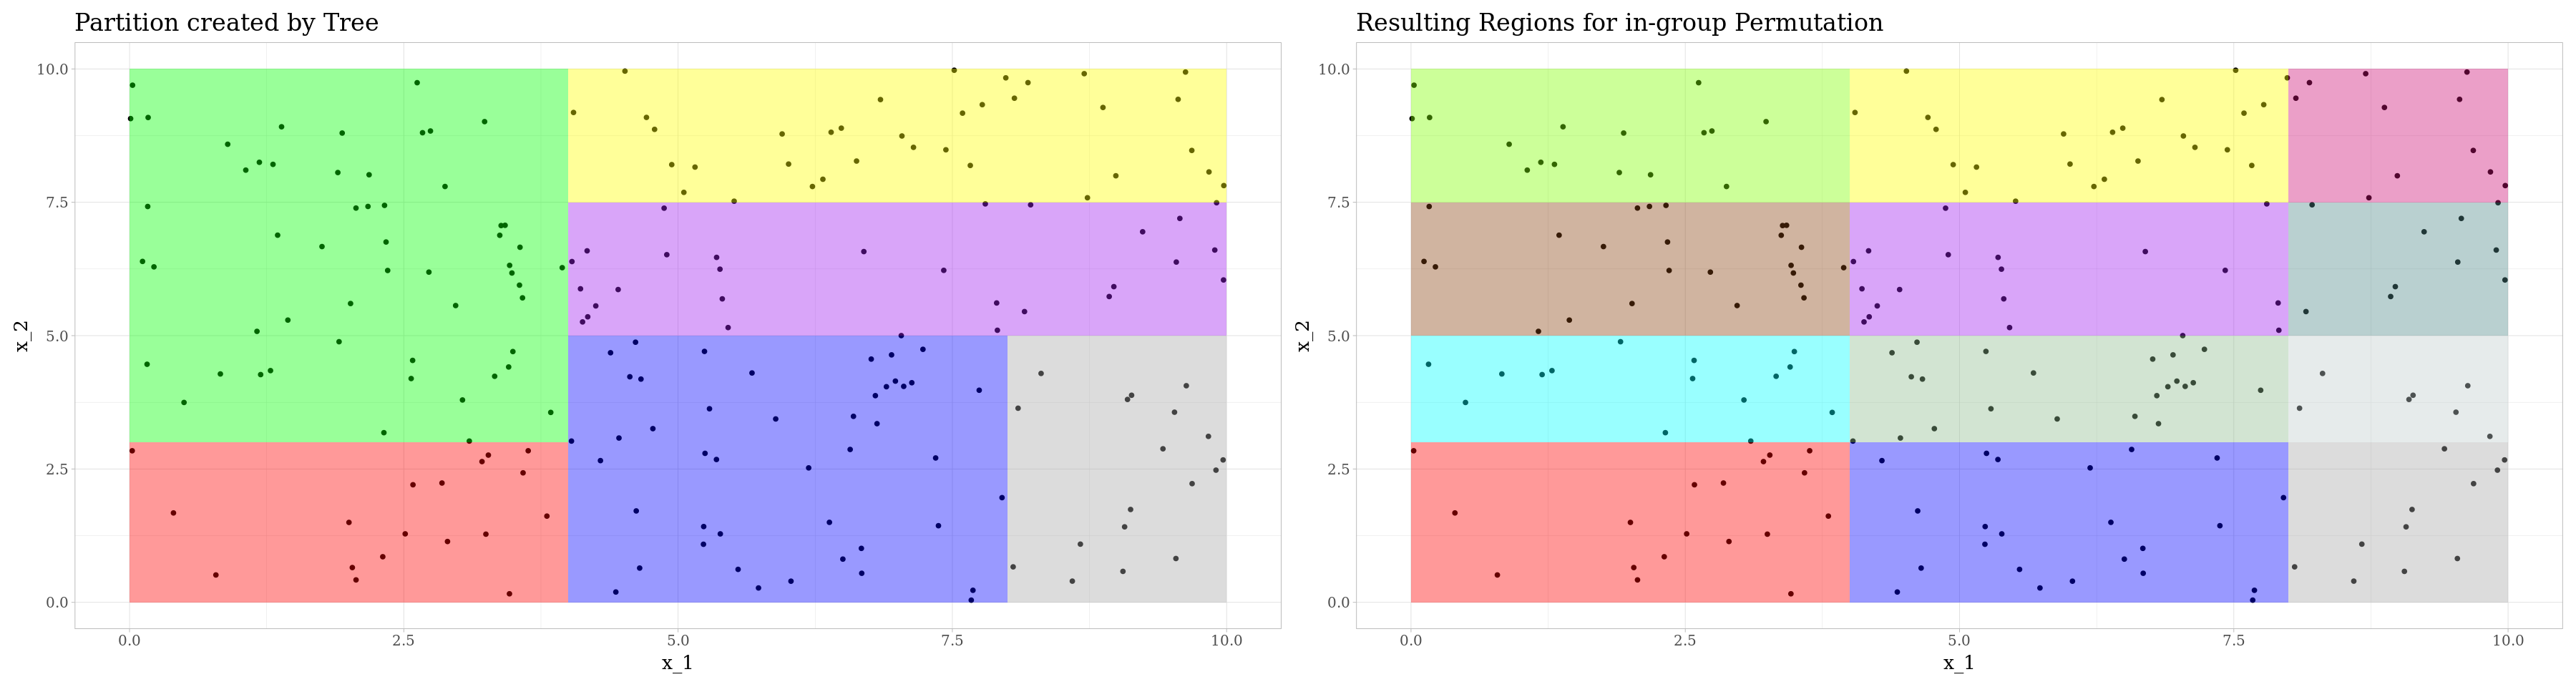

In [97]:
source("Auxiliary/Visualizations.R")
CVI_vis()

The permutation scheme relies on extending each split not only to the subtree used for its creation, but to the whole predictor space. This partition of the predictor space is then used to determine which observations form groups in which permutation takes place. The authors argue that this serves to changes the hypothesis implied in the variable importance to

\begin{equation}
H_0: (X_j \perp Y)\: | \:Z.
\end{equation}

In a continuous setting where the precise argument is more difficult to make, they argue that this serves as a reasonable approximation as observations with identical realizations of covariates are unlikely but observations in the same region are suitably comparable to apply the procedure nevertheless. It is easy to see, that this hypothesis is identical to to the original one under the assumption of independence between $X_j$ and $Z$, in case of correlated predictors however, there is an important difference in the conditioning. In more recent literature conditional importance measures are sometimes linked to approaches that are only supposed to identify inherently informative variables and not those that are correlated to them. This approach however is still under development and therefore will only have a limited role in the simulation parts of this project.

### Conditional Inference Trees <a name="CIT"></a>
---
Introduced by *Hothorn, Hornik, and Zeileis (2006)*, Conditional Inference Trees (**CIT**) try to address the problem of selection bias of typical random trees based for example on **CART** decribed in a previous paragraph by modifying the recursive binary partitioning procedure. To do so they devise a method based on a testing framework for permutation tests by *Strasser and Weber (1999)*. The authors describe the algorithm used to construct the tree in the following three steps (quote):
> 1. For case weights $w$ test the global null hypothesis of independence between any of the
$m$ covariates and the response. Stop if this hypothesis cannot be rejected. Otherwise
select the $j^{*}$th covariate $X_{j^{*}}$ with strongest association to $Y$.
> 2. Choose a set $A^{*} \subset \mathcal{X}_{j^{*}}$ in order to split $\mathcal{X}_{j^{*}}$ into two disjoint sets $A^{*}$ and $\mathcal{X}_{j^{*}} \setminus A^{*}$. The case weights $w_{\text{left}}$ and $w_{\text{right}}$ determine the two subgroups with $w_{\text{left}, i} = w_i I(\mathcal{X}_{j^{*} \: i} \in A^{*})$ and $w_{\text{right}, i} = w_i I(\mathcal{X}_{j^{*} \: i} \notin A^{*})$ for all $i = 1, \dots , n\quad$ ($I(\:)$ denotes
the indicator function).
> 3. Recursively repeat Steps 1 and 2 with modified case weights $w_{\text{left}}$ and $w_{\text{right}}$, respectively.

Here the non-negative integer-valued weights $w$ serve as indicators as to which region of predictor space an observation lies in.

Where in **CART** the variable $X_j$ with strongest association to $Y$ would be chosen by comparing the reduction in **RSS**, this method employs a different approach. Given the global hypothesis of independence $H_0$ between $X$ and $Y$ at a node, partial independence hypotheses $H_0^j$ for each dimension $X_j$ are constructed and tested using a linear hypothesis in the framework of permutation tests. If the global hypothesis cannot be discarded from the teststatistic constructed from the calculations of the partial hypotheses, an additional split is performed in the dimension where the test statistic for the partial independence hypothesis is associated with the smallest p-value. Here a multiple testing correction for the partial hypotheses becomes important due to the interaction of testing multiple hypotheses while also wanting to control the family wise error rate (**FWER**). Concerning this correction the authors name a simple bonferroni correction while also referring to more advanced multiple testing literature.<br>
Mathematically, the authors represent this interaction of hypotheses as follows (adjusted to the notation previously used in this project):

\begin{equation}
H_0 = \bigcap_{j = 1}^p H_0^j \quad \text{where} \quad H_0^j: D(Y|X_j) = D(Y) \quad \text{or formulated as in previous hypotheses} \quad H_0^j: Y \perp X_j
\end{equation}

A theoretical presentation of the testing framework is out of the scope of this project, but intuitively this method leads to a stopping criterion based on statistical testing theory and fixed levels of significance and thereby improves interpretability of results (at each split an uninformative variable is chosen with a probability of $\alpha$ or less) and works against overfitting (by introducing an alternative stopping criterion based on the global hypothesis of independence at a node). In simulations performed by the authors this mehod is competitive with optimally pruned trees created by **CART** while also improving on the variable selection biases exhibited by previous methods.

### Conditional Inference Random Forests <a name="CIRF"></a>
---
Given that conditional inference trees are only based on a different method to construct a structurally similar tree to **CART** it is not surprising that a random forest can be based on **CIT** as well. This has been done previously and apart from a considerably higher computational cost from **CIT** random forest has shown expected improvements over **CART** random forest in addressing the inherent biases of **CART** towards variables with more categories or continuous scale. However, as previously mentioned simulation studies have shown that constructing a random forest via bootstrapping has its own biases which are not corrected by simply switching the basal tree type of a random forest to **CIT**. <br>

However, one additional important difference to the random forests employed in most implementations, conditional inference random forest is typically paired not with a bootstrapping procedure, but instead uses subsampling without replacement due to desirable properties illustrated in *Strobl, Boulesteix, Zeileis, and Hothorn (2007)* associated to the bootstrapping bias motivated above. This for example also applies to the functions used in the simulations and is further elaborated on in the part on implementation.

### Permutation Approach by Altmann et al. (2010) <a name="altmnn"></a>
---
In *Altmann, Toloşi, Sander, and Lengauer (2010)* the authors develop a different approach on permutation based importance called p-values computed with permutation importance (**PIMP**). Their idea is to calculate any importance measure and to then apply a bias correction as follows. The notion of importance used by the authors again <br>

For $s$ iterations randomly permute the response variable before constructing a random forest on the partially permuted data set. Calculate the same importance measure as in the original data set for each possible predictor. This produces a vector of length $s$ for each predictor containing importance measures under the hypothesis of independence between the predictors and the response variable, called the null importances. Using this vector of null importances a selection of distributions can be fit to the observed importance measures, which in turn can be used to calculate a p-value for the hypothesis that the original importance measure was drawn from this distribution. This also allows for a testing procedure where variables are chosen for a predictive model if their p-value lies above a specific threshold. In the original paper the formulation is slightly unclear, whether multivariate distributions are fit to the matrix of observed importance measures or univariate distributions are fit to each individual predictor. Supplementary material provided by the authors and later implementations however use the second approach and fit univariate distributions to the Null importances for each predictor. <br>
The authors also include a non-parametric approach to estimate the p-values of the original importance measure based on the fraction of null-importances more extreme than the original importance, which is equivalent to a testing approach based on a Monte-Carlo approximation of the distribution of importance measures under the Null-hypothesis.

One important difference comparing this method to the previous permutation approach is the conservation of the correlation structure of the predictors. In this case, even if the test statistic was sensitive to changes in their structure, it could not influence the final assessment of a predictor due to no relative permutation between the predictors. It is also developed as a correction tool for other variable importance measures and therefore quite generally applicable. Additionally it introduces the possibility to use significance testing for variable selection which can be desirable for interpretation and model building to variable importance measures that typically do not inherently have this possibility.

### Permutation Approach by Hapfelmeier and Ulm (2013) <a name="hpflmr_ulm"></a>
---
Developed by *Hapfelmeier and Ulm (2013)* there is another permutation based approach for feature selection that at the cost of further icreasing computational cost improves on certain properties of previous approaches. Their idea again relies on approximating the distribution of an importance measure for each covariate under a specific independence hypothesis using a form of Monte-Carlo simulation to employ possible tests for feature selection as *Altmann, Toloşi, Sander, and Lengauer (2010)* did before them. Due to a theoretical argument made in *Strobl and Zeileis (2008)*, the authors conclude that the approach followed by *Altmann, Toloşi, Sander, and Lengauer (2010)* is not theoretically sound in analysing hypotheses of independence for individual covariates as *"alarming statistical properties [...] any statement of significance made with this test is nullified" (from *Strobl and Zeileis (2008)*). This theoretical argument is based on a dependence of such a test's power on the number of trees. Therefore they propose an approach based also on creating random forests on partially permuted data sets, which instead of applying permutation to the response variable is based on permuting predictors one by one to approximate the distribution of interest. <br>

Quoting from the paper the algorithm works as follows:
> 1. Compute any kind of importance measure using the original data.
> 2. Permute each variable separately and several times to assess the empirical distribution of its importance measure under
$H_0 (1)$.
> 3. Assess the p-value for each variable by means of the empirical distributions and the original importance measures.
> 4. Select the variables with a p-value below a certain threshold, optionally with Bonferroni-Adjustment (or any other method
that controls the FDR [false discovery rate] or FWER [family-wise error rate]).

where 
\begin{equation}
    H_0(1): Y, \mathbf{Z} \perp X_j \quad \text{and} \quad \mathbf{Z} = \mathbf{X} \setminus X_j
\end{equation}

As this formalization of the underlying hypothesis shows, a change in correlation structure within $\mathbf{X}$ due to permutation could in this case also add to an indicated violation of the hypothesis. However, the authors give the argument, that typical importance measures for trees are not dependent on the relation to other covariates as the test statistics in some of the previous tests inherently are. Therefore, in praxis this formal difference in hypotheses should not be of relevance in practice for most importance measures. <br> 
A practical concern with this feature selection procedure is inherent computational cost due to the recalculation of many random forests for each variable. This can quickly be costly to the point of becoming infeasible timewise in very high dimensional settings. This can be remedied by the structure of the calculations which allow for simple paralleliztaion due to the process falling into a category of problems called "embarassingly parallel" as creation of many permutations and the creation of random forests can happen independently in a parallelized procedure.

## Implementations <a name="implementation"></a>
---
To understand the simulations conducted in the later parts of this project it is also important to understand what is actually calculated when using the preimplemented functions of the packages. These will mainly include **randomForest**, **party**, and **partykit**.
The relevant citations for these packages are included in the biobliography and can additionally be accessed using the *citation("\<packagename\>")* command. For more detailed information on the packages refer to the manuals provided on **CRAN** by the authors.

### package randomForest <a name="pckg_rf"></a>
---
The package R *randomForest* is mostly known for the function of the same name *randomForest()*. I implmenets the random forest described above based on **CART** and boostrapping. <br>
When using the R package *randomForest* (*Liaw and Wiener (2001)*) as I will be in parts of the simulation studies, up to four importance measures are calculated when applying the function *randomForest*. For their definitions the authors refer to *Breiman (2002)*. In this text however, only definitions for classification are given. The following excerpts are quoted from the manual:

Measure 1:
> To estimated the importance of the mth variable. In the left out
cases for the kth tree, randomly permute all values of the mth
variable Put these new covariate values down the tree and get
classifications. <br>
> Proceed as though computing a new internal error rate. The amount
by which this new error exceeds the original test set error is defined
as the importance of the mth variable.

Measures 2 and 3:
>For the nth case in the data, its margin at the end of a run is the
proportion of votes for its true class minus the maximum of the
proportion of votes for each of the other classes. The 2nd measure
of importance of the mth variable is the average lowering of the
margin across all cases when the mth variable is randomly permuted
as in method 1. <br>
>
>The third measure is the count of how many margins are lowered
minus the number of margins raised.

Measure 4:
> The splitting criterion used in RF is the gini criterion--also used in
CART. At every split one of the mtry variables is used to form the
split and there is a resulting decrease in the gini. The sum of all
decreases in the forest due to a given variable, normalized by the
number of trees, froms (sic) measure 4.

Measure 1 is the typical case of a permutation based importance measure as previously motivated. 

In the documentation on CRAN for the package *randomForest* the authors explain the reported importance measures as follows:

> importance a matrix with nclass + 2 (for classification) or two (for regression) columns.
For classification, the first nclass columns are the class-specific measures computed as mean descrease in accuracy. The nclass + 1st column is the mean
descrease in accuracy over all classes. The last column is the mean decrease
in Gini index. For Regression, the first column is the mean decrease in accuracy and the second the mean decrease in MSE. If importance=FALSE, the last
measure is still returned as a vector

This is slightly ambiguous on whether simple importance measures are averaged over trees, or permutation importances are calculated. When referring to the sources above, it seems logical to assume that the importances calculated are permutation importances as this keeps the authors statements consistent. Due to the complexity of the implementation and the possibly contradictory nature of these equally official sources, I cannot, however, completely negate the possibility that simple importance measures such as the one described under "Feature Selection and Importance Measures - Variance Reduction" is actually what is calculated and averaged.

Therefore, the reported measures such as %IncMSE and %IncNP are seen as **OOB** increase in the corresponding statistic after permutation (averaged over all trees). For deeper interpretation of the simulation results, further analysis of the source code should be performed to gain a more general understanding of the calculated importance measures.

### package party & partykit <a name="pckg_party"></a>
---

The R packages *party* and *partykit* will be mostly used for their implementations of **CIT** and random forests based on **CIT**. The latter is based on subsampling without replacement instead of bootstrapping to address the biases associated with bootstrapping procedures in random forests. The following information is taken from the official documentation on **CRAN** for the corresponding packages.

**partykit::cforest()** <br>
The function *cforest()* implements a random forest based on **CIT** with subsampling without replacement instead of bootstrapping as described in *Strobl, Boulesteix, Zeileis, and Hothorn (2007)*. Resons for this choice are given above in the theoretical section.

**partykit::varimp()** <br>
Given a random forest generated by *cforest()*, this function is used to calculate variable importance measures " permutation principle of the ‘mean decrease in accuracy’ importance in ‘randomForest’." <br>
The argument *conditional* decides whether a conditional variable importance as described in *Strobl, Boulesteix, Kneib, Augustin, and Zeiles (2008)* (**conditional == TRUE**) or a non-conditional importance measure is computed.

## Simulation Study <a name="simulation"></a>
---
For the simulation part of this project I am going to conduct two simulations to compare how the previously presented methods deal with different data generating processes. These are meant to exemplify the biases addressed in the earlier parts of the theoretical introduction. <br>

The simulation settings I decided to pursue are the following:
1. Uncorrelated, uninformative predictors in a low dimensional setting with differing numbers of categories (from binary to continuous)
    * Response variable Y: uniformly distributed on $[0,1]$
    * 6 predictors: 
        * 5 uniformly distributed categorical variables with increasing number of categories (2,4,6,8,10) <br>
        * 1 continuous predictor uniformly distributed on $[0,1]$
    * All variables are drawn independently from eachother
    * 100 observations
2. Correlated, informative predictors in a low dimensional setting with continuous scale
    * Response variable Y: generated by a linear process $Y = X\beta + \epsilon$
    * $X$ is drawn from a p-dimensional normal distribution with zero mean and variance-covariance matrix $\Sigma$
    * $\epsilon$ is drawn from a standard normal
    * 100 observations
    
\begin{equation}
    \Sigma = 
    \begin{bmatrix}
        1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
        0.0 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
        0.0 & 0.0 & 1.0 & 0.8 & 0.0 & 0.0 & 0.0 & 0.0 \\
        0.0 & 0.0 & 0.8 & 1.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
        0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.5 & 0.0 & 0.0 \\
        0.0 & 0.0 & 0.0 & 0.0 & 0.5 & 1.0 & 0.0 & 0.0 \\
        0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.0 & 0.2 \\
        0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.2 & 1.0 \\
    \end{bmatrix}
    \quad \text{and} \quad
    \beta = (1, 0, 1, 0, 1, 0, 1, 0)^{T}
\end{equation}

The first is meant to identify biases towards variables with a larger number of categories or a continuous measuring scale, as an unbiased criterion should choose variables with an equal frequency. As correlation is not the focus of this simulation, I decided not to calculate conditional cariable importances, as it does not address the problem that is under scrutiny in this simulation and to not overload one simulation.<br>
The second simulation is meant to address problems related to correlated predictors and to serve as a means to differentiate between the different concepts of informative predictors. As to not confound the biases due to number of categories or measuring scale, these predictors are all measured on a continuous scale. <br>

It would also be interesting to do simulations on high dimensional data. However, especially the Methods proposed by *Altmann, Toloşi, Sander, and Lengauer (2010)* and *Hapfelmeier and Ulm (2013)* are too computationally intensive when used in conjunction with random forests based on **CIT** to perform scientifially interesting simulations in a meaningful high dimensional setting on a personal computer. These simulations most likely would have to be performed on a cluster which could be done quite easily with the codes provided in this project due to the chosen route of parallelization. This is sadly out of the scope of this project due to the associated cost of using High Performance Computing Resources (**HPC**), that are prohibitive in the context of a term project.

### Functions for Simulation <a name="functions"></a>
---
To make the actual simulation code easier to follow, I define a set of functions that are used in the latter parts of the code to improve readability. These are all tasked with a small subset of the overall simulation as dictated by the functional programming paradigm inherent to languages such as R. The code for the functions can be found in the file *Auxiliary/sim_functions.R* including comments that serve as documentation and descriptions of the arguments. I will quickly explain the high level functions used in the simulation below.

In [5]:
source('Auxiliary/sim_functions.R')

#### Altmann et al. (2010) - Null Importance Generator
*Altm_Null_Imp()* generates Null importances in the sense of *Altmann, Toloşi, Sander, and Lengauer (2010)* given a set of arguments:
* **cl**: a cluster object generated by the parallel package (for UNIX based systems use Forking Cluster, for Windows switch function calls to PSOCK Cluster and ensure that functions are available in the scope of the respective nodes)
* **seed**: seed for random number generation
* **df**: data.frame containing the data
* **ntree**:number of trees used in the construction of the random forests
* **reps**: number of repetitions for **parallel helper**.
* **rf_type**: a string determining the type of random forest to be calculated
* **conditional**: if rf_type == cforest, this boolean decides whether conditional importances are calculated  

There actually are premade implementations of the **PIMP** algorithm in packages such as *vita* (https://cran.r-project.org/web/packages/vita/index.html). To follow an approach more comparable to *Hapfelmeier and Ulm (2013)* I still decided to implement the method myself due to their inherent similarities to increase comparability when using the nonparametric approach for *Altmann, Toloşi, Sander, and Lengauer (2010)*.

#### Hapfelmeier and Ulm (2013) - Null Importance Generator
*HU_Null_Imp()* generates Null importances in the sense of *Hapfelmeier and Ulm (2013)* given a set of arguments:
* **cl**: a cluster object generated by the parallel package (for UNIX based systems use Forking Cluster, for Windows switch function calls to PSOCK Cluster and ensure that functions are available in the scope of the respective nodes)
* **seed**: seed for random number generation
* **df**: data.frame containing the data
* **ntree**: number of trees used in the construction of the random forests
* **reps**: number of repetitions for **parallel helper**.
* **rf_type**: a string determining the type of random forest to be calculated
* **conditional**: if rf_type == cforest, this boolean decides whether conditional importances are calculated  

#### Altmann et al. (2010) - Transformation of Output
*Altm_NullImp_Transf()* takes output from *Altm_Null_Imp()* and transforms it into a more human readable and more easily usable format for further processing.
* **Atlm_RF_Null_Imp**: Output of *Altm_Null_Imp()*
* **rf_type**: a string determining the type of random forest used in the input
* **conditional**: if rf_type == cforest, this boolean decides whether conditional importances are contained in the object 

#### Hapfelmann and Ulm (2013) - Extraction of relevant importances and Transformation of Output
*HU_NullImp_RF_Transf()* takes output from *HU_Null_Imp()* and transforms it into a more human readable and more easily usable format for further processing.
* **HU_RF_Null_Imp**: Output of *HU_Null_Imp()*
* **rf_type**: a string determining the type of random forest used in the input
* **conditional**: if rf_type == cforest, this boolean decides whether conditional importances are contained in the object 

#### Determine non-parametric p-value of importance measure
*imp_p_val()* takes a vector of Null importances and a value for an importance measure and returns an approximation of the p-value corresponding to this realization of the importance measure under the Null hypothesis.
* **imp**: realized importance measure without permutation
* **vec_null_imp**: vector of null importances

### Simulation Code <a name="code"></a>
---

#### Simulation 1
---
The following code does multiple things:
1. Generate a data set as described above for Simulation 1
2. Calculate variable importances using *randomForest()*
3. Calculate unconditional variable importances using *cforest()* and *varimp()*
4. Calculate *Altmann et al. (2010)* Null Importances for both *randomForest()* and *cforest()* (only unconditional importance)
5. Calculate *Hapfelmeier and Ulm (2013)* Null Importances for *randomForest()* and *cforest()* (only unconditional importance)

All of these are done for 1000 values of a seed and apart from the data sets, output is saved to the folder "/Data/Simulation_1" in the corresponding sub-directories. <br>

The execution of this code takes multiple days on even a very strong personal computer (Intel 8086k based system - about 100 hours of simulation - fully parallelized). So take this into consideration when planning a replication and consider using **HPC** resources. On weaker machines the code based on **randomForest()** and not **cforest()** is more feasible to replicate due to its inherent lower computational cost. <br>
For the Methods based on *Hapfelmeier and Ulm (2013)* and **CIT** random forests, I reduced the number of simulation runs from 1000 to 600 due to run-time concerns. <br>

The output of those functions is saved to subdirectories of *Data/Simulation_1* for further processing.

In [15]:
simulate_1 <- FALSE

# Simulation 1: low dimensional data, uninformative, uncorrelated predictors
if(simulate_1 == TRUE){
    
    runs <- 1000
    num_trees <- 200
    
    set.seed(2834765)
    sim_seeds <- sample(1:10e5, size = runs, replace = FALSE)
    
    cl <- parallel::makeForkCluster(n_cores - 1)
    
    for(i in 1:runs){
        data_1 <- data_generator_A(seed = sim_seeds[i], n = 100, catvec = c(2,4,6,8,10), ncont = 1)
        
        ### CART random forest
        rf_1 <- randomForest::randomForest(Y ~ ., data = data_1, importance = TRUE, ntree = num_trees)$importance
        saveRDS(object = rf_1, file = paste0("Data/Simulation_1/CART_rf/CART_rf_it", i, ".RDS"))
        
        ### CIT random forest
        tmp <- cforest(Y ~ ., data = data_1, ntree = num_trees)
        CIRF_1 <- varimp(tmp, conditional = FALSE)
        saveRDS(object = CIRF_1, file = paste0("Data/Simulation_1/CIT_rf/CIT_rf_it", i, ".RDS"))
        
        ### Altmann et al. (2010) - CART random forests
        Altm_CART_1 <- Altm_Null_Imp(cl = cl, seed = sim_seeds[i], df = data_1, ntree = num_trees,
                                 reps = 200, rf_type = 'randomForest')
    
        Altm_CART_NULLIMP_1 <- Altm_NullImp_Transf(Altm_CART_1, rf_type = 'randomForest')
        
        saveRDS(object = Altm_CART_NULLIMP_1, file = paste0("Data/Simulation_1/Altmann/CART/it_", i, ".RDS"))
        
        ### Altmann et al. (2010) - CIT random forests
        Altm_CIT_1 <- Altm_Null_Imp(cl = cl, seed = sim_seeds[i], df = data_1, ntree = num_trees,
                                    reps = 200, rf_type = 'cforest', conditional = FALSE)
    
        Altm_CIT_NULLIMP_1 <- Altm_NullImp_Transf(Altm_CIT_1, rf_type = 'cforest')
        
        saveRDS(object = Altm_CIT_NULLIMP_1, file = paste0("Data/Simulation_1/Altmann/CIT/it_", i, ".RDS"))
        
        ### Hapfelmeier and Ulm (2013) - CART random forests
        
        HU_CART_1 <- HU_Null_Imp(cl = cl, seed = sim_seeds[i], df = data_1, ntree = num_trees,
                                 reps = 200, rf_type = 'randomForest')
    
        HU_CART_NULLIMP_1 <- HU_NullImp_RF_Transf(HU_CART_1, rf_type = 'randomForest')
        
        saveRDS(object = HU_CART_NULLIMP_1, file = paste0("Data/Simulation_1/Hapfelmeier/CART/it_", i, ".RDS"))
        
        if(i <= 600){
        ### Hapfelmeier and Ulm (2013) - CIT random forests
        
        HU_CIT_1 <- HU_Null_Imp(cl = cl, seed = sim_seeds[i], df = data_1, ntree = num_trees,
                             reps = 200, rf_type = 'cforest', conditional = FALSE)
    
        HU_CIT_NULLIMP_1 <- HU_NullImp_RF_Transf(HU_CIT_1, rf_type = 'cforest')
        
        saveRDS(object = HU_CIT_NULLIMP_1, file = paste0("Data/Simulation_1/Hapfelmeier/CIT/it_", i, ".RDS"))
        }
        
    }
    
    stopCluster(cl)
}

The following code reads in the data for the different procedures and combines them into objects that are more useful for the further analysis. <br>
The output is saved to the directory "Data/Simulation_1/Summary". The execution of this code is not dependent on **simulate_1 == TRUE** as it is not computationally expensive and puts the data into a format that is easily readable by humans.

In [17]:
runs <- 1000
num_predictors <- dim(readRDS(file = "Data/Simulation_1/CART_rf/CART_rf_it1.RDS"))[1]

INC_MSE <- matrix(data = NA, nrow = num_predictors, ncol = runs)
INC_NP <- matrix(data = NA, nrow = num_predictors, ncol = runs)
UNCOND_IMP <- matrix(data = NA, nrow = num_predictors, ncol = runs)

for(i in 1:runs){
    tmp_CART <- readRDS(file = paste0("Data/Simulation_1/CART_rf/CART_rf_it", i, ".RDS"))
    INC_MSE[,i] <- tmp_CART[,1]
    INC_NP[,i] <- tmp_CART[,2]
    
    tmp_CIT <- readRDS(file = paste0("Data/Simulation_1/CIT_rf/CIT_rf_it", i, ".RDS"))
    UNCOND_IMP[,i] <- tmp_CIT
}

saveRDS(object = as.data.frame(x = INC_MSE, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_1/Summary/INC_MSE_CART_rf.RDS")

saveRDS(object = as.data.frame(x = INC_NP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_1/Summary/INC_NP_CART_rf.RDS")

saveRDS(object = as.data.frame(x = UNCOND_IMP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_1/Summary/UNCOND_IMP_CIT_rf.RDS")

These data.frames can now be used for two purposes:
1. Evaluate the corresponding importance measures on their own in the context of uninformative predictors and biases associated to number of categories and measurement scale
2. As a baseline for the methods of *Altmann et al. (2010)* and *Hapfelmeier and Ulm (2013)* using the calculated Null importances

To do the latter, it is necessary to calculate the corresponding non-parametric p-values for the realized importance measures using the Null importances. For this purpose the function *imp_p_val()* exists. <br>
The following code performs this task for the Null Importances generated by the method described in *Altmann et al. (2010)*.

In [47]:
INC_MSE <- readRDS(file = "Data/Simulation_1/Summary/INC_MSE_CART_rf.RDS")
INC_NP <- readRDS(file = "Data/Simulation_1/Summary/INC_NP_CART_rf.RDS")
UNCOND_IMP <- readRDS(file = "Data/Simulation_1/Summary/UNCOND_IMP_CIT_rf.RDS")

num_predictors <- dim(INC_MSE)[1]
runs <- 1000

Altm_p_vals_INC_MSE <- matrix(data = NA, nrow = num_predictors, ncol = runs)
Altm_p_vals_INC_NP <- matrix(data = NA, nrow = num_predictors, ncol = runs)
Altm_p_vals_UNCOND_IMP <- matrix(data = NA, nrow = num_predictors, ncol = runs)

HU_p_vals_INC_MSE <- matrix(data = NA, nrow = num_predictors, ncol = runs)
HU_p_vals_INC_NP <- matrix(data = NA, nrow = num_predictors, ncol = runs)
HU_p_vals_UNCOND_IMP <- matrix(data = NA, nrow = num_predictors, ncol = 600)

for(i in 1:1000){
    
    tmp_Altm_CART_NULLIMP <- readRDS(file = paste0("Data/Simulation_1/Altmann/CART/it_", i, ".RDS"))
    tmp_Altm_INC_MSE_NULLIMP <- tmp_Altm_CART_NULLIMP$MSE_inc
    tmp_Altm_INC_NP_NULLIMP <- tmp_Altm_CART_NULLIMP$node_impur
    
    tmp_Altm_CIT_UNCOND_NULLIMP <- readRDS(file = paste0("Data/Simulation_1/Altmann/CIT/it_", i, ".RDS"))$uncond
    
    Altm_p_vals_INC_MSE[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = INC_MSE[j,i], vec_null_imp = tmp_Altm_INC_MSE_NULLIMP[j,])))
            
    Altm_p_vals_INC_NP[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = INC_NP[j,i], vec_null_imp = tmp_Altm_INC_NP_NULLIMP[j,])))
            
    Altm_p_vals_UNCOND_IMP[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = UNCOND_IMP[j,i], vec_null_imp = tmp_Altm_CIT_UNCOND_NULLIMP[j,])))
    
    
    tmp_HU_CART_NULLIMP <- readRDS(file = paste0("Data/Simulation_1/Hapfelmeier/CART/it_", i, ".RDS"))
    tmp_HU_INC_MSE_NULLIMP <- tmp_HU_CART_NULLIMP$MSE_inc
    tmp_HU_INC_NP_NULLIMP <- tmp_HU_CART_NULLIMP$node_impur
          
    HU_p_vals_INC_MSE[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = INC_MSE[j,i], vec_null_imp = tmp_HU_INC_MSE_NULLIMP[j,])))
            
    HU_p_vals_INC_NP[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = INC_NP[j,i], vec_null_imp = tmp_HU_INC_NP_NULLIMP[j,])))
            
    if(i <= 600){        
    tmp_HU_CIT_UNCOND_NULLIMP <- readRDS(file = paste0("Data/Simulation_1/Hapfelmeier/CIT/it_", i, ".RDS"))$uncond
    HU_p_vals_UNCOND_IMP[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = UNCOND_IMP[j,i], vec_null_imp = tmp_HU_CIT_UNCOND_NULLIMP[j,])))   
    }        
}

saveRDS(object = as.data.frame(x = Altm_p_vals_INC_MSE, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_1/Summary/Altm_INC_MSE_pval.RDS")

saveRDS(object = as.data.frame(x = Altm_p_vals_INC_NP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_1/Summary/Altm_INC_NP_pval.RDS")

saveRDS(object = as.data.frame(x = Altm_p_vals_UNCOND_IMP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_1/Summary/Altm_UNCOND_pval.RDS")
            
saveRDS(object = as.data.frame(x = HU_p_vals_INC_MSE, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_1/Summary/HU_INC_MSE_pval.RDS")

saveRDS(object = as.data.frame(x = HU_p_vals_INC_NP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_1/Summary/HU_INC_NP_pval.RDS")

saveRDS(object = as.data.frame(x = HU_p_vals_UNCOND_IMP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_1/Summary/HU_UNCOND_pval.RDS")

#### Simulation 2
---
Performing the same operations for simulation 2, yields similar code. However, due the biases that are supposed to be addressed in this simulations different statistics, including the conditional variable importances are calculated. <br>
Similar to the first simulation, the following steps are performed:
1. Generate a data set as described above for Simulation 2
2. Calculate variable importances using *randomForest()*
3. Calculate unconditional and conditional variable importances using *cforest()* and *varimp()*
4. Calculate *Altmann et al. (2010)* Null Importances for both *randomForest()* and *cforest()* including conditional importances
5. Calculate *Hapfelmeier and Ulm (2013)* Null Importances for *randomForest()* and *cforest()* including conditional importances

Again for the sake of reducing computation time, the number of iterations for *Hapfelmeier and Ulm (2013)* based methods in conjunction with **CIT** random forests is reduced to 600. <br>
The output of those functions is saved to subdirectories of *Data/Simulation_1* for further processing. <br>
Due to increases of computational cost, the number of simulations for *Altmann et al. (2010)* and *Hapfelmeier and Ulm (2013)* methods in combination with **CIT** random forests is reduced to 500 and XXXXXXX respectively. For *Hapfelmeier and Ulm (2013)* the number of Null importances is additionally reduced to 100 from 200 to reduce simulation time. A full run of both simulations with 1000 repetitions and full number of Null importances will be provided on the github repository in a future revision.

The following code sections perform the same tasks as previously described for simulation 1 for the second data generating process and include the calculation of conditional importance measures for the calculations based on **CIT** random forests.

In [ ]:
simulate_2 <- TRUE

# Simulation 2: low dimensional data, informative predictors and predictors correlated to informative ones
if(simulate_2 == TRUE){
    
    my_Sigma <- matrix(data = c(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                                0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                                0.0, 0.0, 1.0, 0.8, 0.0, 0.0, 0.0, 0.0,
                                0.0, 0.0, 0.8, 1.0, 0.0, 0.0, 0.0, 0.0,
                                0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0,
                                0.0, 0.0, 0.0, 0.0, 0.5, 1.0, 0.0, 0.0,
                                0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.2,
                                0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 1.0),
                      nrow = 8, ncol = 8)
    
    my_beta <- c(1,0,1,0,1,0,1,0)
    
    runs <- 1000
    num_trees <- 200
    
    set.seed(2834765)
    sim_seeds <- sample(1:10e5, size = runs, replace = FALSE)
    
    cl <- parallel::makeForkCluster(n_cores - 1)
    
    for(i in 131:runs){
        data_2 <- data_generator_B(seed = sim_seeds[i], n = 100, Sigma = my_Sigma, beta = my_beta)
        
        ### CART random forest
        #rf_2 <- randomForest::randomForest(Y ~ ., data = data_2, importance = TRUE, ntree = num_trees)$importance
        #saveRDS(object = rf_2, file = paste0("Data/Simulation_2/CART_rf/CART_rf_it", i, ".RDS"))
        
        ### CIT random forest
        #tmp <- cforest(Y ~ ., data = data_2, ntree = num_trees)
        #CIRF_2_uncond <- varimp(tmp, conditional = FALSE)
        #CIRF_2_cond <- varimp(tmp, conditional = TRUE)
        #CIRF_2 <- data.frame(uncond = CIRF_2_uncond,
        #                     cond = CIRF_2_cond)
        #saveRDS(object = CIRF_2, file = paste0("Data/Simulation_2/CIT_rf/CIT_rf_it", i, ".RDS"))
        
        ### Altmann et al. (2010) - CART random forests
        #Altm_CART_2 <- Altm_Null_Imp(cl = cl, seed = sim_seeds[i], df = data_2, ntree = num_trees,
        #                         reps = 200, rf_type = 'randomForest')
    
        #Altm_CART_NULLIMP_2 <- Altm_NullImp_Transf(Altm_CART_2, rf_type = 'randomForest')
        
        #saveRDS(object = Altm_CART_NULLIMP_2, file = paste0("Data/Simulation_2/Altmann/CART/it_", i, ".RDS"))
        
        #if(i <= 500){
        ### Altmann et al. (2010) - CIT random forests
        #Altm_CIT_2 <- Altm_Null_Imp(cl = cl, seed = sim_seeds[i], df = data_2, ntree = num_trees,
        #                        reps = 200, rf_type = 'cforest', conditional = TRUE)
    
        #Altm_CIT_NULLIMP_2 <- Altm_NullImp_Transf(Altm_CIT_2, rf_type = 'cforest', conditional = TRUE)
        
        #saveRDS(object = Altm_CIT_NULLIMP_2, file = paste0("Data/Simulation_2/Altmann/CIT/it_", i, ".RDS"))
        #}
        
        ### Hapfelmeier and Ulm (2013) - CART random forests
        
        #HU_CART_2 <- HU_Null_Imp(cl = cl, seed = sim_seeds[i], df = data_2, ntree = num_trees,
        #                         reps = 200, rf_type = 'randomForest')
    
        #HU_CART_NULLIMP_2 <- HU_NullImp_RF_Transf(HU_CART_2, rf_type = 'randomForest')
        
        #saveRDS(object = HU_CART_NULLIMP_2, file = paste0("Data/Simulation_2/Hapfelmeier/CART/it_", i, ".RDS"))
        
        if(i <= 500){
        ### Hapfelmeier and Ulm (2013) - CIT random forests
        
        HU_CIT_2 <- HU_Null_Imp(cl = cl, seed = sim_seeds[i], df = data_2, ntree = num_trees,
                             reps = 100, rf_type = 'cforest', conditional = TRUE)
    
        HU_CIT_NULLIMP_2 <- HU_NullImp_RF_Transf(HU_CIT_2, rf_type = 'cforest', conditional = TRUE)
        
        saveRDS(object = HU_CIT_NULLIMP_2, file = paste0("Data/Simulation_2/Hapfelmeier/CIT/it_", i, ".RDS"))
        }
    }
    
    stopCluster(cl)
}

In [52]:
runs <- 1000
num_predictors <- dim(readRDS(file = "Data/Simulation_2/CART_rf/CART_rf_it1.RDS"))[1]

INC_MSE <- matrix(data = NA, nrow = num_predictors, ncol = runs)
INC_NP <- matrix(data = NA, nrow = num_predictors, ncol = runs)
UNCOND_IMP <- matrix(data = NA, nrow = num_predictors, ncol = runs)
COND_IMP <- matrix(data = NA, nrow = num_predictors, ncol = runs)

for(i in 1:runs){
    tmp_CART <- readRDS(file = paste0("Data/Simulation_2/CART_rf/CART_rf_it", i, ".RDS"))
    INC_MSE[,i] <- tmp_CART[,1]
    INC_NP[,i] <- tmp_CART[,2]
    
    tmp_CIT <- readRDS(file = paste0("Data/Simulation_2/CIT_rf/CIT_rf_it", i, ".RDS"))
    UNCOND_IMP[,i] <- tmp_CIT$uncond
    COND_IMP[,i] <- tmp_CIT$cond
}

saveRDS(object = as.data.frame(x = INC_MSE, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/INC_MSE_CART_rf.RDS")

saveRDS(object = as.data.frame(x = INC_NP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/INC_NP_CART_rf.RDS")

saveRDS(object = as.data.frame(x = UNCOND_IMP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/UNCOND_IMP_CIT_rf.RDS")

saveRDS(object = as.data.frame(x = COND_IMP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/COND_IMP_CIT_rf.RDS")

In [55]:
INC_MSE <- readRDS(file = "Data/Simulation_2/Summary/INC_MSE_CART_rf.RDS")
INC_NP <- readRDS(file = "Data/Simulation_2/Summary/INC_NP_CART_rf.RDS")
UNCOND_IMP <- readRDS(file = "Data/Simulation_2/Summary/UNCOND_IMP_CIT_rf.RDS")
COND_IMP <- readRDS(file = "Data/Simulation_2/Summary/COND_IMP_CIT_rf.RDS")

num_predictors <- dim(INC_MSE)[1]
runs <- 1000

Altm_p_vals_INC_MSE <- matrix(data = NA, nrow = num_predictors, ncol = runs)
Altm_p_vals_INC_NP <- matrix(data = NA, nrow = num_predictors, ncol = runs)
Altm_p_vals_UNCOND_IMP <- matrix(data = NA, nrow = num_predictors, ncol = 500)
Altm_p_vals_COND_IMP <- matrix(data = NA, nrow = num_predictors, ncol = 500)

HU_p_vals_INC_MSE <- matrix(data = NA, nrow = num_predictors, ncol = runs)
HU_p_vals_INC_NP <- matrix(data = NA, nrow = num_predictors, ncol = runs)
#HU_p_vals_UNCOND_IMP <- matrix(data = NA, nrow = num_predictors, ncol = 600)
#HU_p_vals_COND_IMP <- matrix(data = NA, nrow = num_predictors, ncol = 600)

for(i in 1:1000){
    
    tmp_Altm_CART_NULLIMP <- readRDS(file = paste0("Data/Simulation_2/Altmann/CART/it_", i, ".RDS"))
    tmp_Altm_INC_MSE_NULLIMP <- tmp_Altm_CART_NULLIMP$MSE_inc
    tmp_Altm_INC_NP_NULLIMP <- tmp_Altm_CART_NULLIMP$node_impur
      
    Altm_p_vals_INC_MSE[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = INC_MSE[j,i], vec_null_imp = tmp_Altm_INC_MSE_NULLIMP[j,])))
            
    Altm_p_vals_INC_NP[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = INC_NP[j,i], vec_null_imp = tmp_Altm_INC_NP_NULLIMP[j,])))      
    
    if(i <= 500){        
        
    tmp_Altm_CIT_UNCOND_NULLIMP <- readRDS(file = paste0("Data/Simulation_2/Altmann/CIT/it_", i, ".RDS"))$uncond
    tmp_Altm_CIT_COND_NULLIMP <- readRDS(file = paste0("Data/Simulation_2/Altmann/CIT/it_", i, ".RDS"))$cond      
        
    Altm_p_vals_UNCOND_IMP[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = UNCOND_IMP[j,i], vec_null_imp = tmp_Altm_CIT_UNCOND_NULLIMP[j,])))
           
    Altm_p_vals_COND_IMP[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = COND_IMP[j,i], vec_null_imp = tmp_Altm_CIT_COND_NULLIMP[j,])))                
    }
            
    tmp_HU_CART_NULLIMP <- readRDS(file = paste0("Data/Simulation_2/Hapfelmeier/CART/it_", i, ".RDS"))
    tmp_HU_INC_MSE_NULLIMP <- tmp_HU_CART_NULLIMP$MSE_inc
    tmp_HU_INC_NP_NULLIMP <- tmp_HU_CART_NULLIMP$node_impur
            
    HU_p_vals_INC_MSE[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = INC_MSE[j,i], vec_null_imp = tmp_HU_INC_MSE_NULLIMP[j,])))
            
    HU_p_vals_INC_NP[,i] <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = INC_NP[j,i], vec_null_imp = tmp_HU_INC_NP_NULLIMP[j,])))
                    
    
    #if(i <= 600){
            
    #tmp_HU_CIT_UNCOND_NULLIMP <- readRDS(file = paste0("Data/Simulation_2/Hapfelmeier/CIT/it_", i, ".RDS"))$uncond
    #tmp_HU_CIT_COND_NULLIMP <- readRDS(file = paste0("Data/Simulation_2/Hapfelmeier/CIT/it_", i, ".RDS"))$cond    
            
    #tmp_HU_CIT_UNCOND_NULLIMP <- readRDS(file = paste0("Data/Simulation_2/Hapfelmeier/CIT/it_", i, ".RDS"))$uncond
    #HU_p_vals_UNCOND_IMP[,i] <- unlist(
    #    map(.x = 1:num_predictors,
    #        .f = function(j) imp_p_val(imp = UNCOND_IMP[j,i], vec_null_imp = tmp_HU_CIT_UNCOND_NULLIMP[j,])))  
            
    #tmp_HU_CIT_COND_NULLIMP <- readRDS(file = paste0("Data/Simulation_2/Hapfelmeier/CIT/it_", i, ".RDS"))$cond
    #HU_p_vals_COND_IMP[,i] <- unlist(
    #    map(.x = 1:num_predictors,
    #        .f = function(j) imp_p_val(imp = COND_IMP[j,i], vec_null_imp = tmp_HU_CIT_COND_NULLIMP[j,])))             
    #}        
}

saveRDS(object = as.data.frame(x = Altm_p_vals_INC_MSE, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/Altm_INC_MSE_pval.RDS")

saveRDS(object = as.data.frame(x = Altm_p_vals_INC_NP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/Altm_INC_NP_pval.RDS")

saveRDS(object = as.data.frame(x = Altm_p_vals_UNCOND_IMP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/Altm_UNCOND_pval.RDS")
            
saveRDS(object = as.data.frame(x = Altm_p_vals_COND_IMP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/Altm_COND_pval.RDS")            
            
saveRDS(object = as.data.frame(x = HU_p_vals_INC_MSE, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/HU_INC_MSE_pval.RDS")

saveRDS(object = as.data.frame(x = HU_p_vals_INC_NP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
        file = "Data/Simulation_2/Summary/HU_INC_NP_pval.RDS")

#saveRDS(object = as.data.frame(x = HU_p_vals_UNCOND_IMP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
#        file = "Data/Simulation_2/Summary/HU_UNCOND_pval.RDS")
            
#saveRDS(object = as.data.frame(x = HU_p_vals_COND_IMP, row.names = c(paste0('X_', as.character(1:num_predictors)))), 
#        file = "Data/Simulation_2/Summary/HU_COND_pval.RDS") 

### Simulation Results <a name="res"></a>
---

In [156]:
source("Auxiliary/Visualizations.R")

#### Simulation 1
---
Using the first simulation it is possible to get an idea on the biases that are present in different methdos due to differences in the number of categories or the measuring scale. The following violin plots show the distribution of the importance measures for the increase in **RSS** (**MSE**), the increase in Node purity and the unconditional permutation importance  calculated by *varimp()* for a forest of **CIT**s. Absent any biases these should approximately follow the same distribution for different predictors, as no predictors contains any information on the response variable. <br>
For p-values approximated by Monte-Carlo-Simulation (**MC**) generated for the methods of *Altmann, Toloşi, Sander, and Lengauer (2010)* and *Hapfelmeier and Ulm (2013)* an unbiased method should show an approximately uniform distribution of p-values. <br>
In the following I present the individual results associated to the different methods.

#### **CART**-Importances <br>
The percentual increase in **MSE** (or **RSS**) shows clear signs of biases towards variables with more categories or a continuous scale. This can be seen as the distribution has more extreme realizations which will lead to more choices of the corresponding variables over predictors with fewer categories. This is consistent with the literature and replicates findings of *Strobl, Boulesteix, Zeileis, and Hothorn (2007)* for the case of a continuous response variable. What can be seen in the violin plot below is that the median of the distribution of importances does not change in a relevant way. However, the height of the individual violin plot increases as the number of categories increases, which is a sign of a larger variance in the realized measures. Since extreme realizations tend to be chosen by methods that evaluate these values, this will lead to an increased frequency of uninformatiive varibles with more categories being chosen.

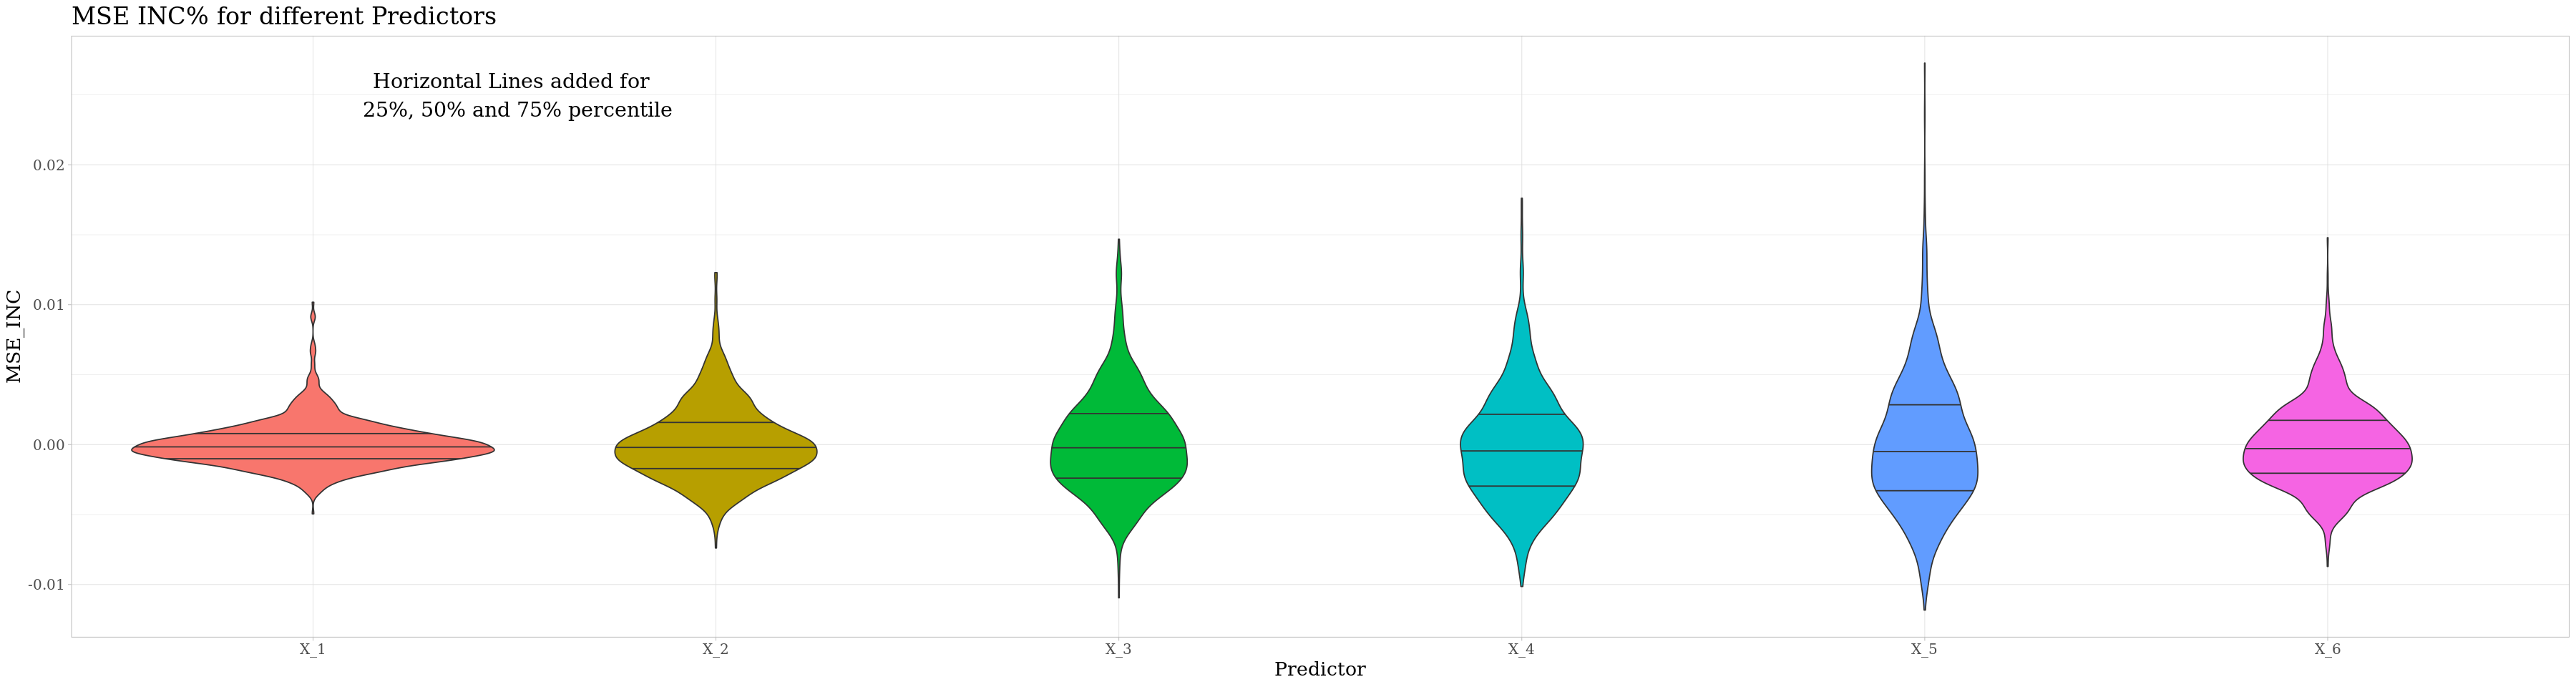

In [157]:
CART_rf_INC_MSE_vis()

The Node Purity Increase shows an even more stark picture as not only an increase in variance, but also a shift of the whole distribution can be observed. This will lead to even stronger bias towards predictors with more categories, as not only the frequency of extreme observations is increased, but also the level of the average realization. This disqualifies this measure in a setting of differing number of categories of different measuring niveau for continuous response variables which again is consistent with the existing literature. An interesting feature of this simulation is the difference between $X_5$ and $X_6$ which indicates that not only is $X_5$ preferred over the other categorical variables but also over its continuous counterpart. This cannot reasonably be explained by an increased number of possible splits and indicates the possibility of further theoretical work to identify the source of bias towards categorical predictors with many categories over continuous predictors.

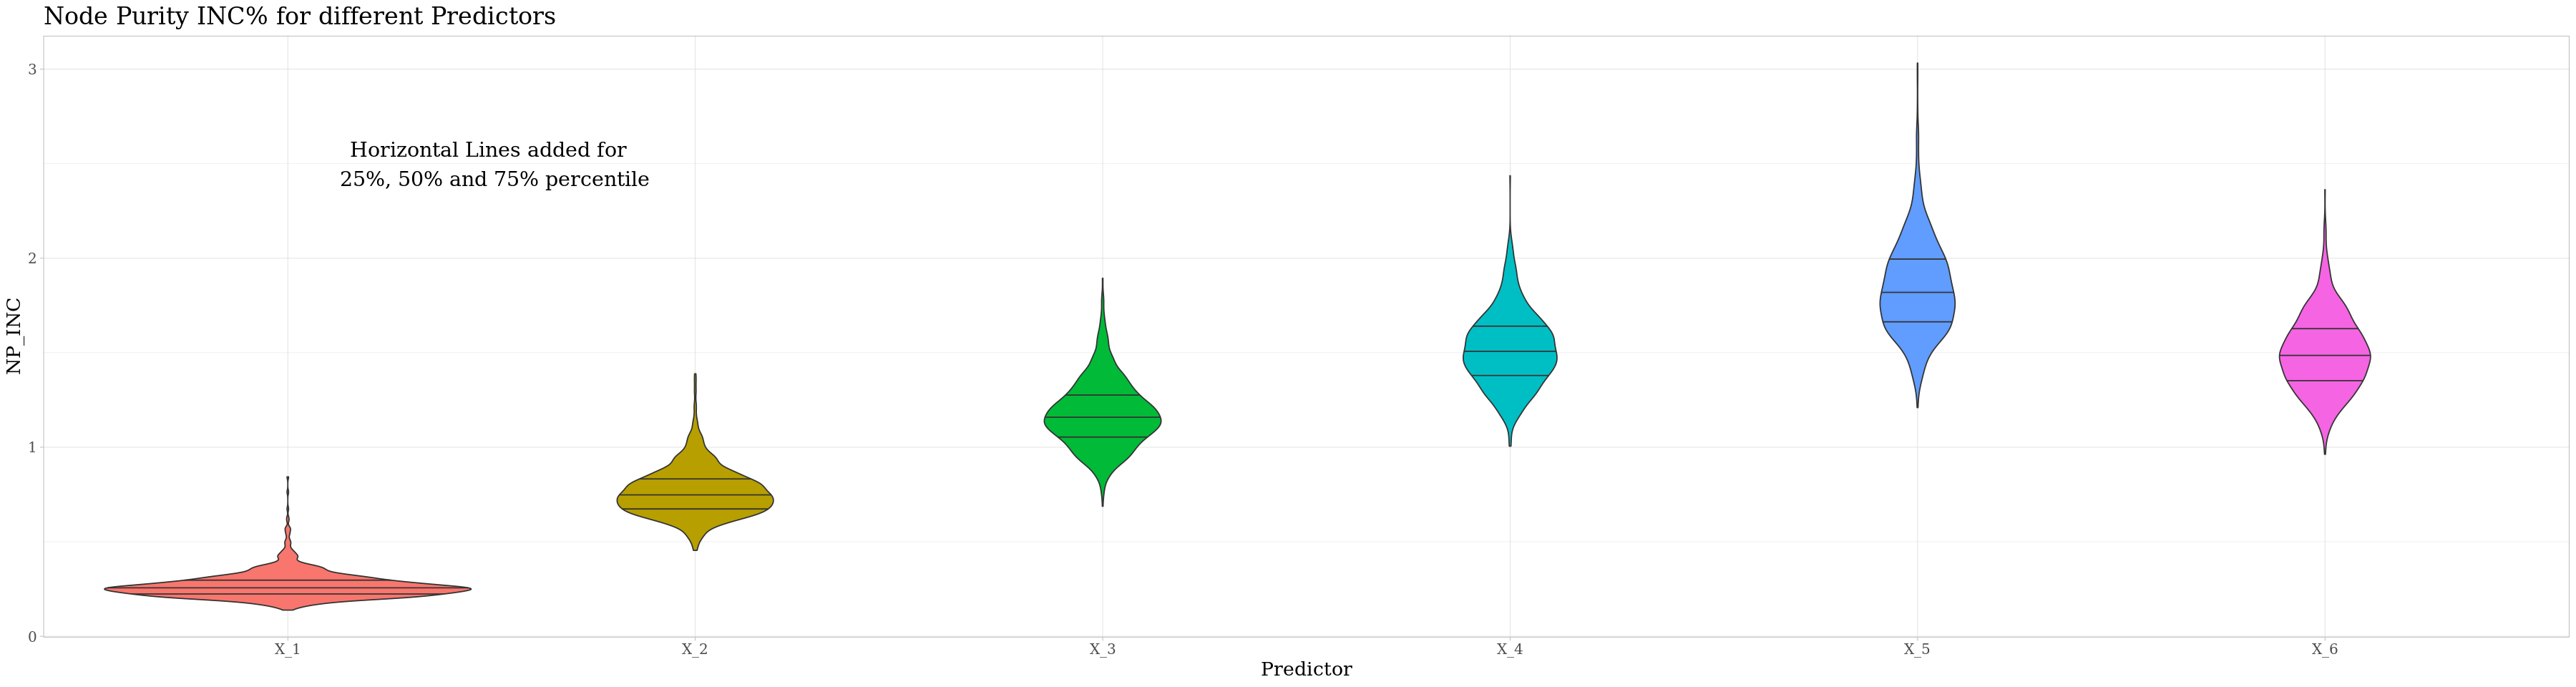

In [158]:
CART_rf_INC_NP_vis()

#### Unconditional **CIT**-Importance <br>

When using a Random Forest constructed from Conditional Inference Trees and with subsampling without replacement a different picture emerges. <br>
Even though there are still differences in the observed distributions, these are by far weaker than those observed for the previous importance measures. A slight difference that could also be an artifact from simulation is the slight upwards shift in the continuous predictor (becomes apparent when looking at the quantile lines). Further simulations to study this phenomenon could be of interest. The observation of no apparent distributional differences between the importances measures of the variables is expected due to the postulated properties of **CIT** in *Hothorn, Hornik, and Zeileis (2006)* and the result of this simulation is further evidence of the improvement in variable selection when using *cforest()* over *randomForest()*.

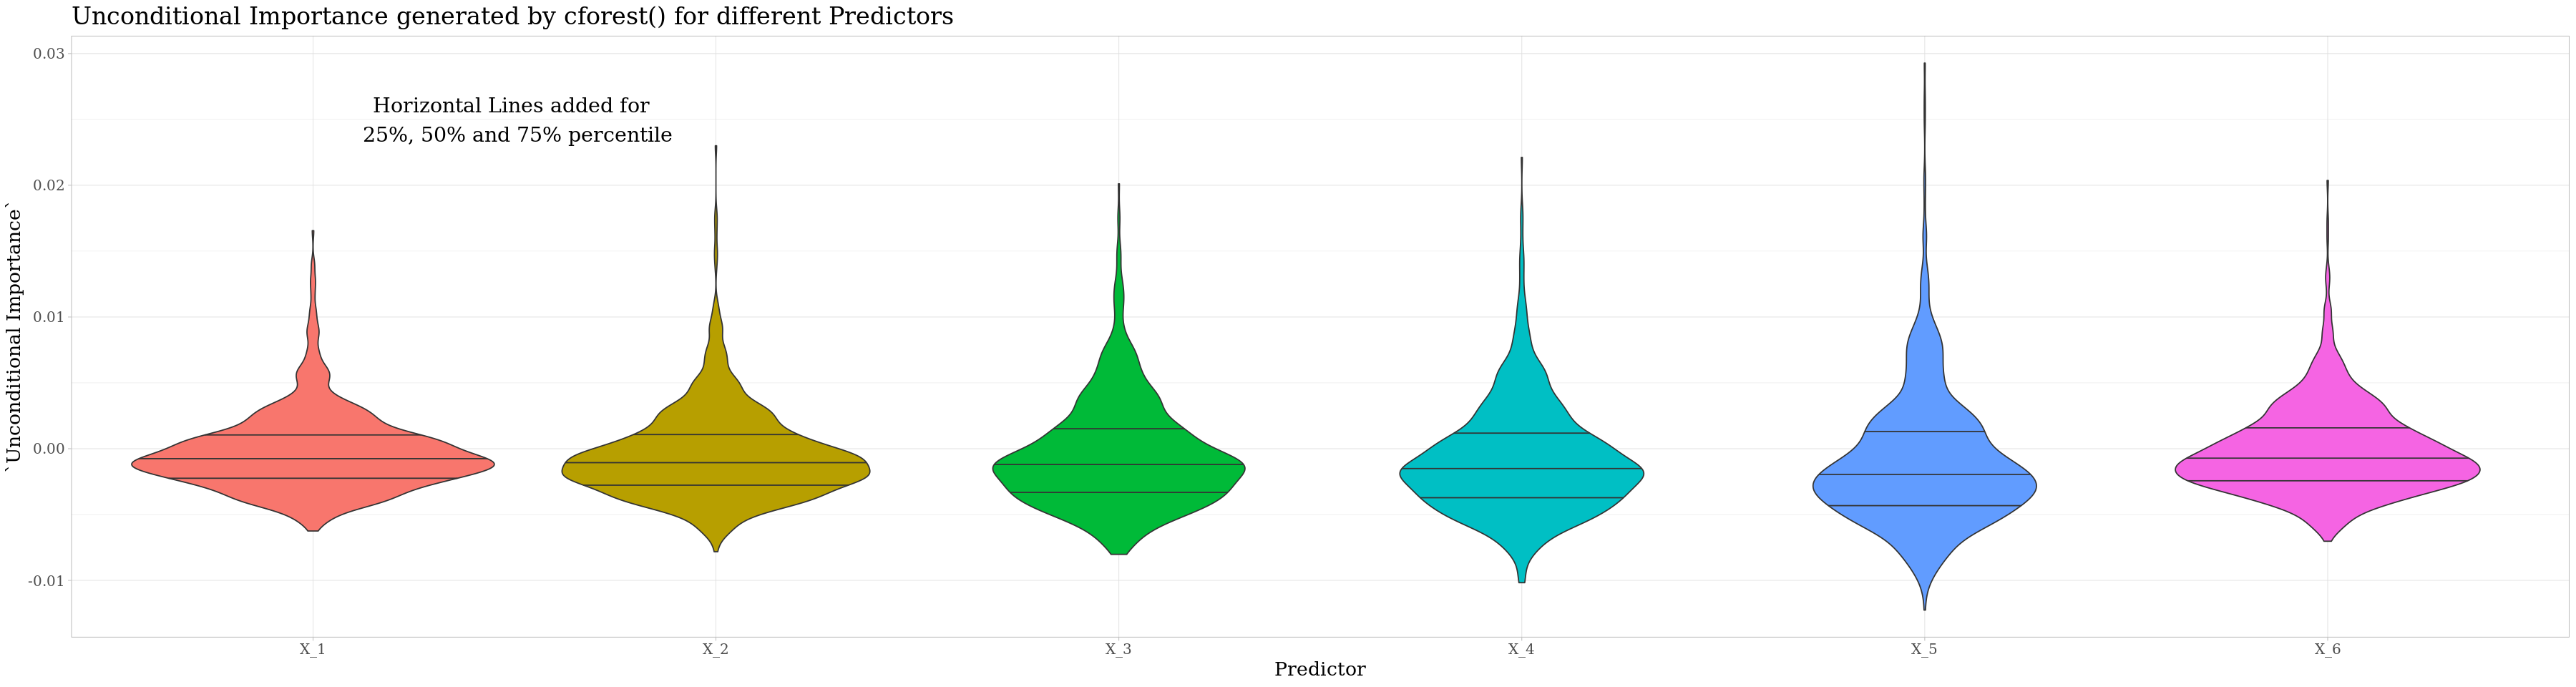

In [159]:
CIT_rf_UNCOND_IMP_vis()

#### Altmann et al. Method

As previously stated, under the Null hypothesis of independence between the predictors and the response variable, the following distributions should be approximately uniform. Since the predictors are not correlated there is also no information due to changes in correlation structure of the predictor variables, which could be confounded with biases associated with differing number of categories or measuring niveau. Using the method from *Altmann, Toloşi, Sander, and Lengauer (2010)* to calculate a set of Null Importances and to construct a p-value leads to the approximate distributions shown below. These fit the idea of a uniform distribution and therefore seem to correctly address the biases in this simple case.

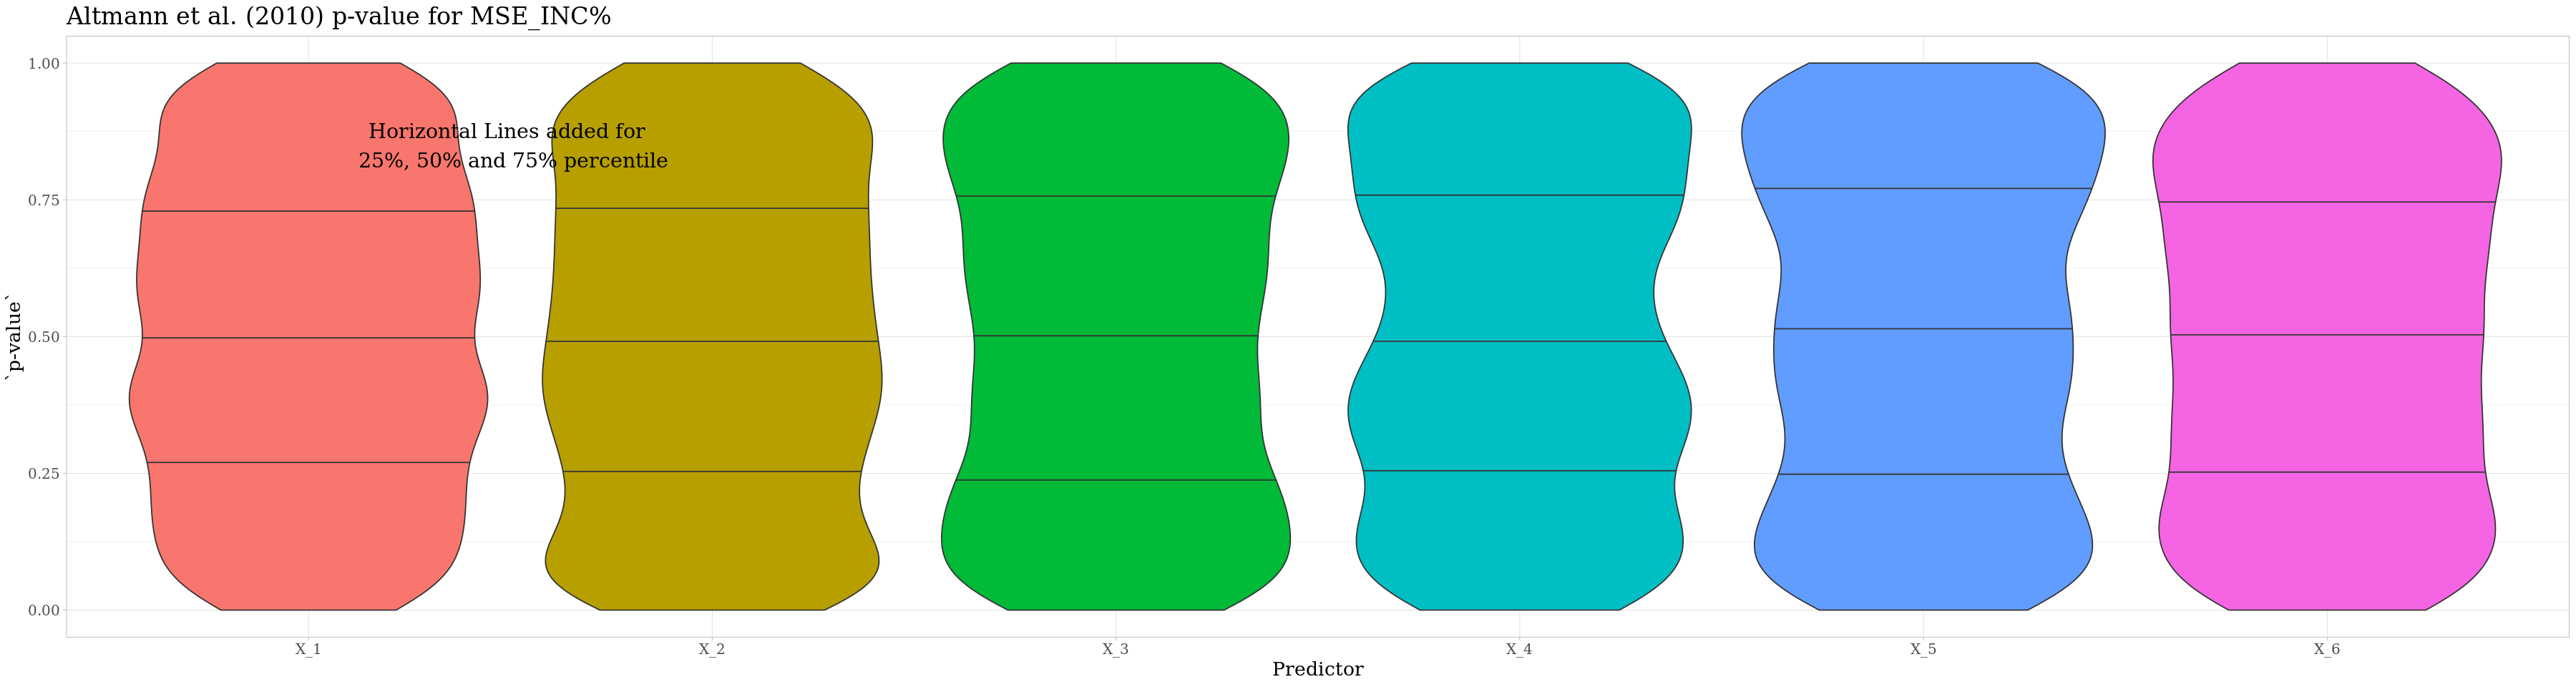

In [160]:
Altm_pval_INC_MSE_vis()

Using the same method to construct Null-importances for the increase in Node purity shows heavily skewed distributions again. Especially as the number of categories increases a high weight lies on low p-values which indicate a high variable importance of the corresponding predictor. The shape of the realized distribution is far from uniform. This shows that using the method of *Altmann, Toloşi, Sander, and Lengauer (2010)* in combination with the node purity increase importance measure form *randomForest()* is not suitable to perform variable selection. Interpretation is prohibited due to the non-uniform shape of the distribution and biases remain present due to the change in distribution as the number of predictors increases. As seen somewhat further down for the case of *Hapfelmeier and Ulm (2010)* and node-purity increase, there is much less distortion of the resulting distribution shown in the simulation results. <br>
This indicates the need for further theoretical consideration of the differences between the hypotheses addressed by the methods and their interaction with the importance measure of node purity increase.

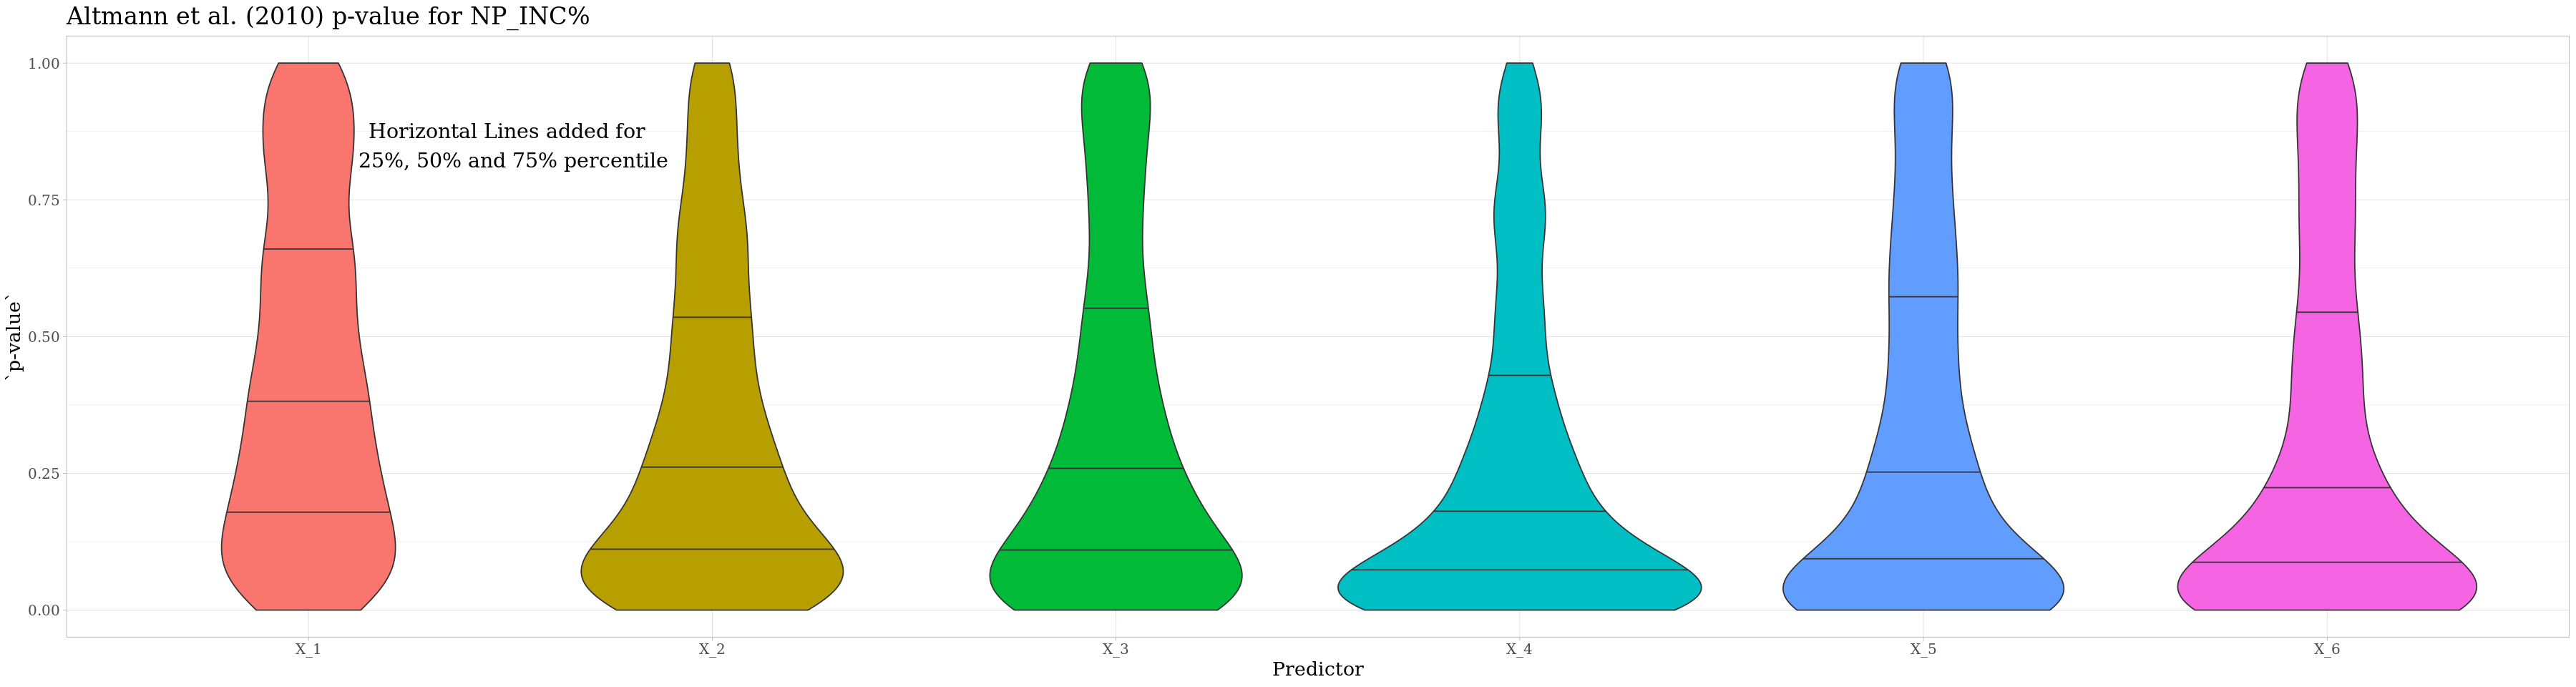

In [161]:
Altm_pval_INC_NP_vis()

For this version of the simulation, where Null Importances are generated for **CIT** based random forests using the methodology from *Altmann, Toloşi, Sander, and Lengauer (2010)*, I again find no reason to assume a violation of the uniform distribution of p-values.

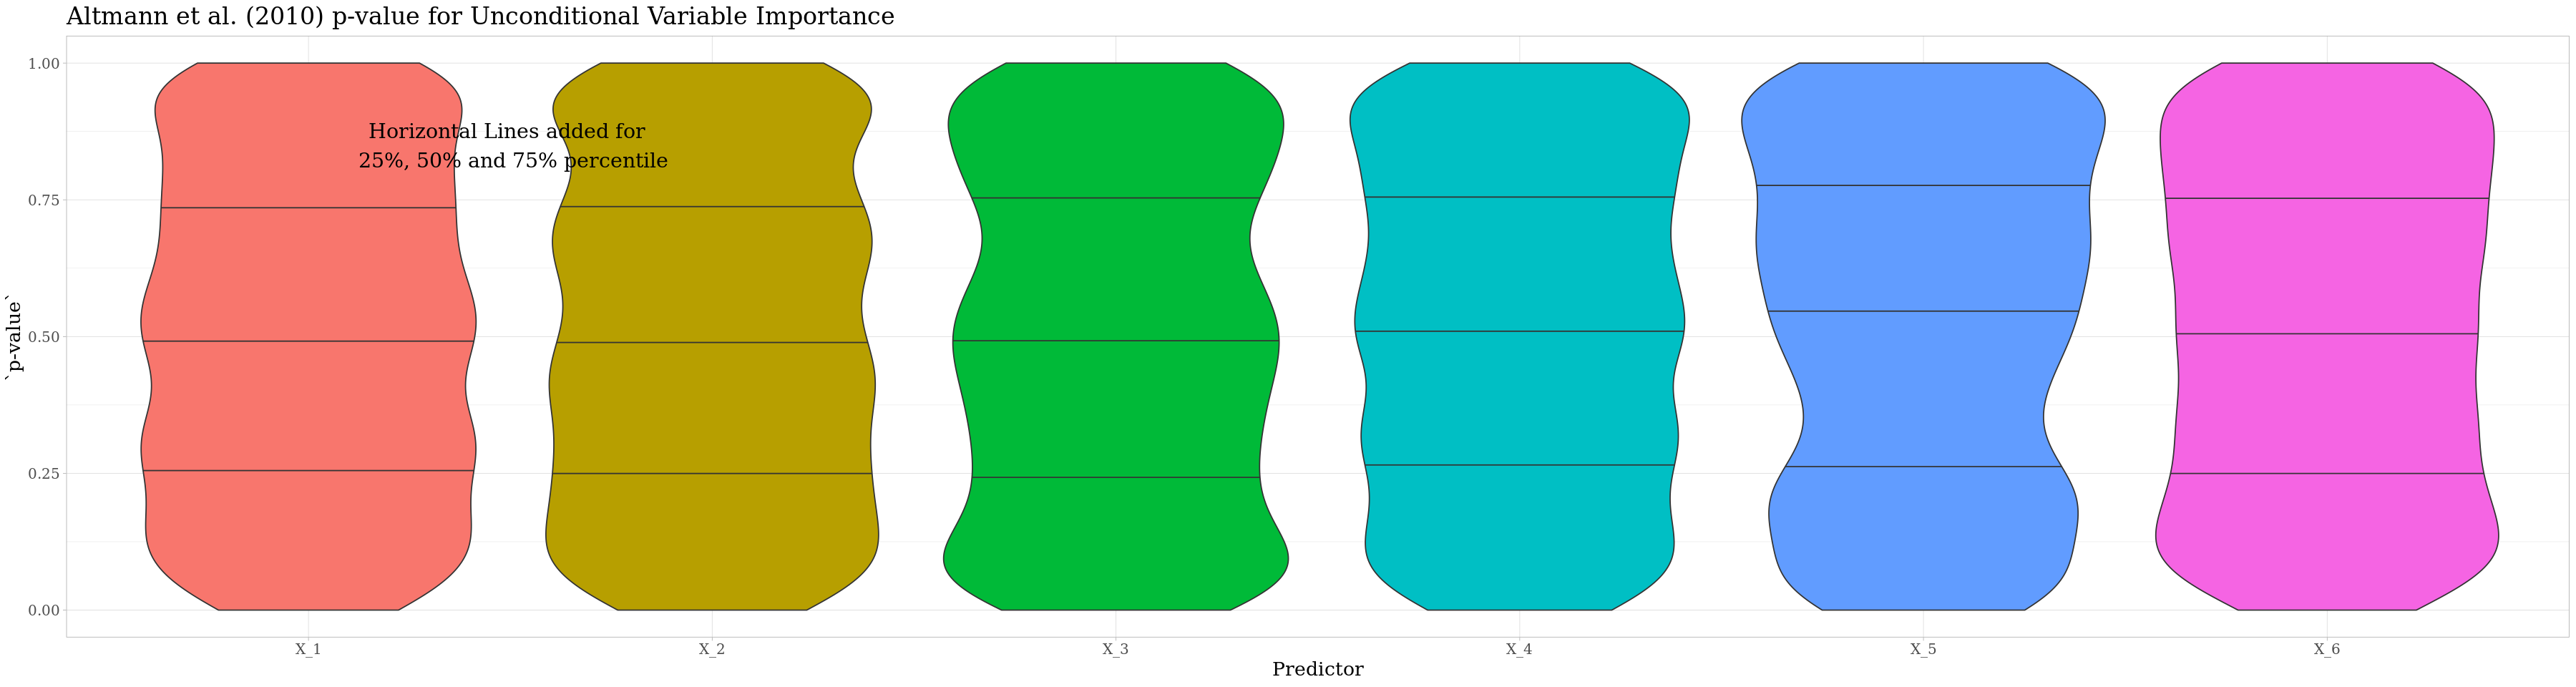

In [162]:
Altm_pval_UNCOND_vis()

#### Hapfelmeier and Ulm Method

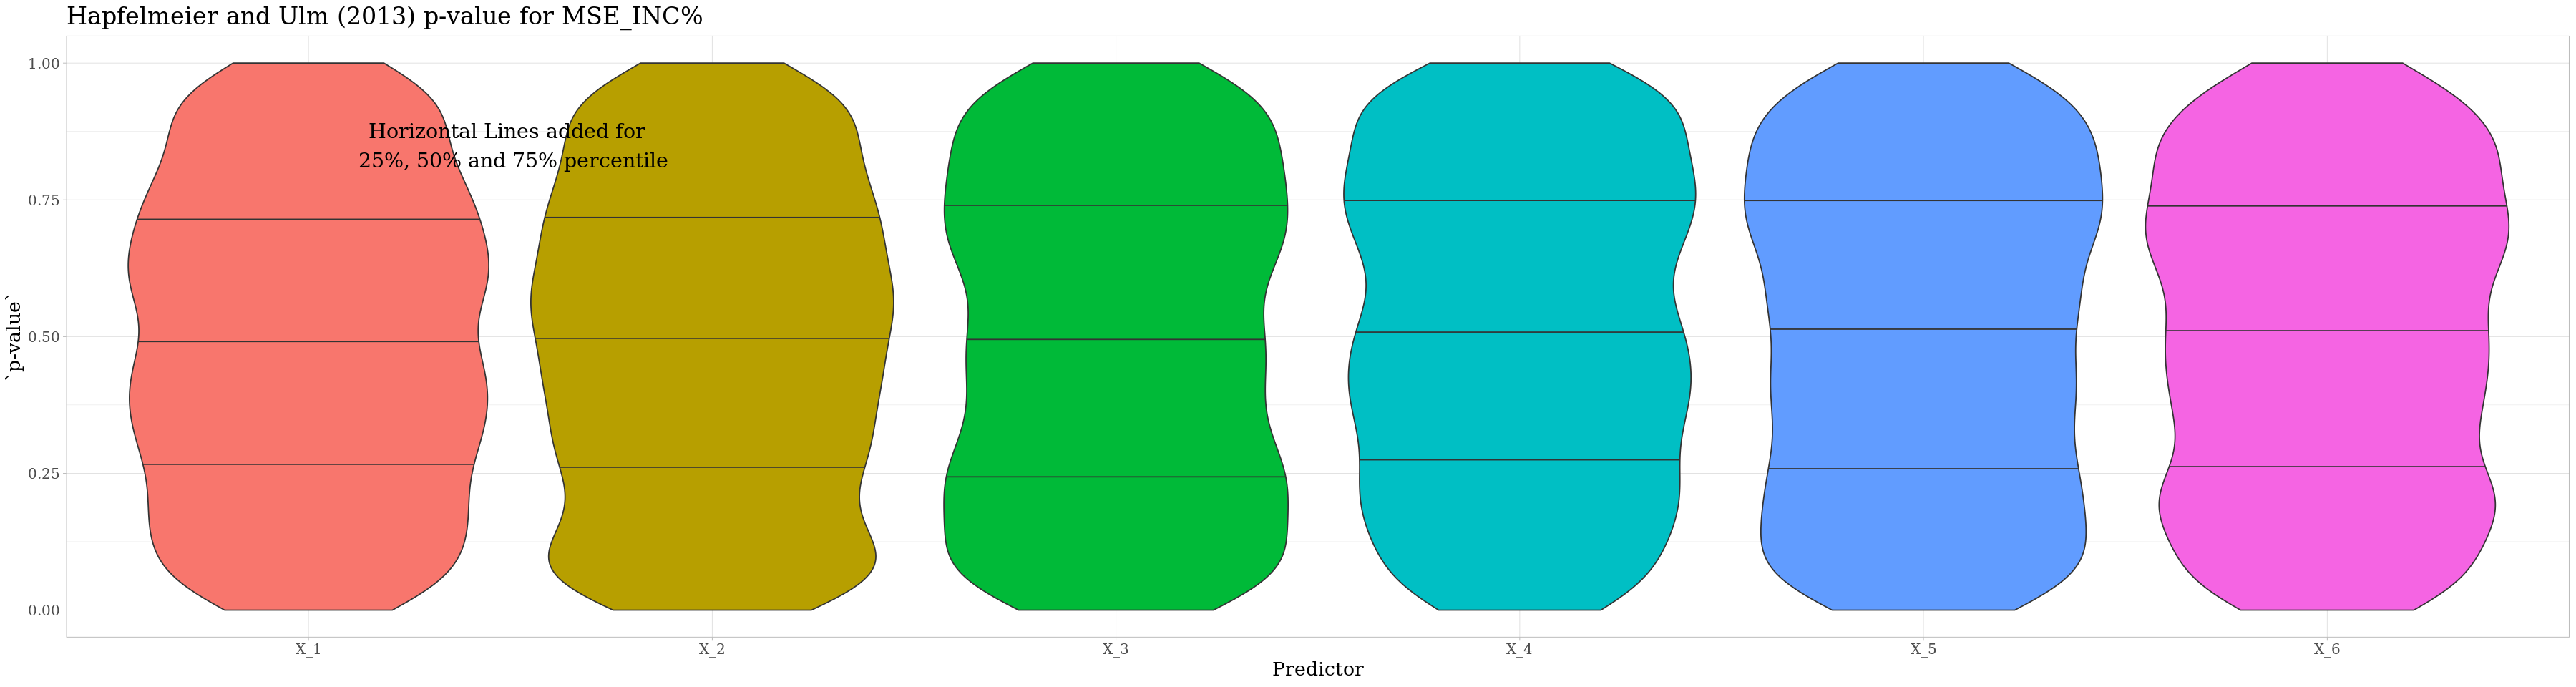

In [163]:
HU_pval_INC_MSE_vis()

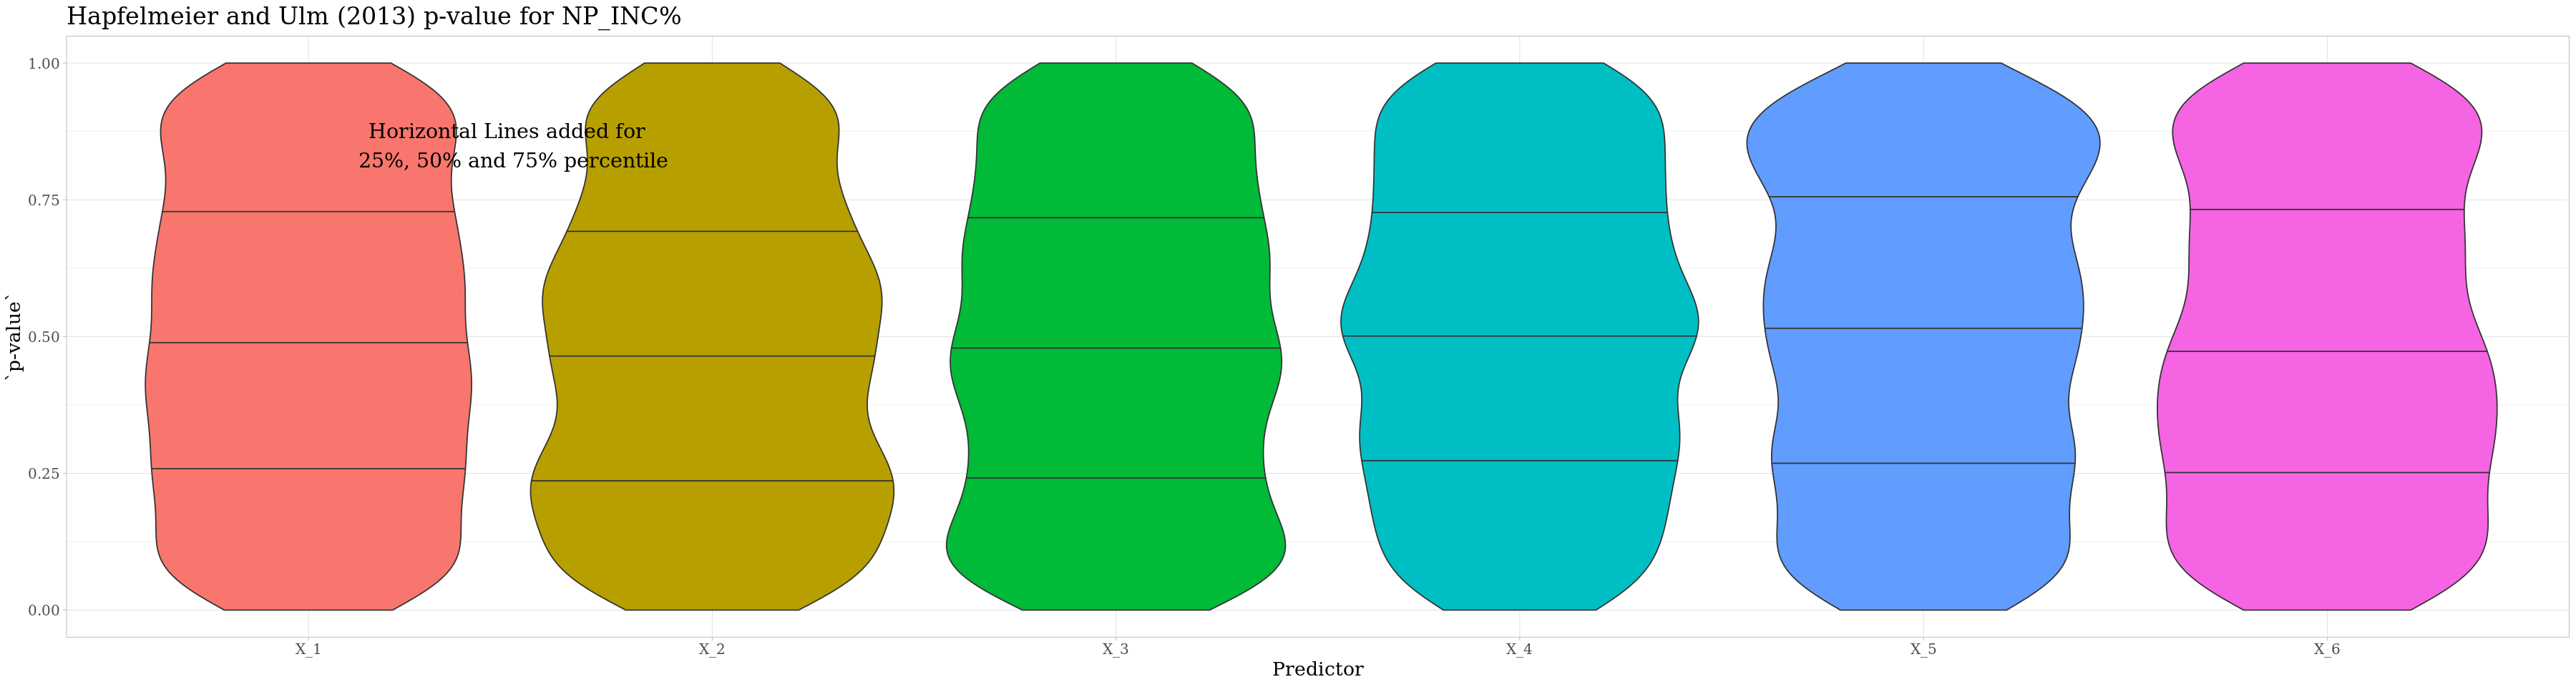

In [164]:
HU_pval_INC_NP_vis()

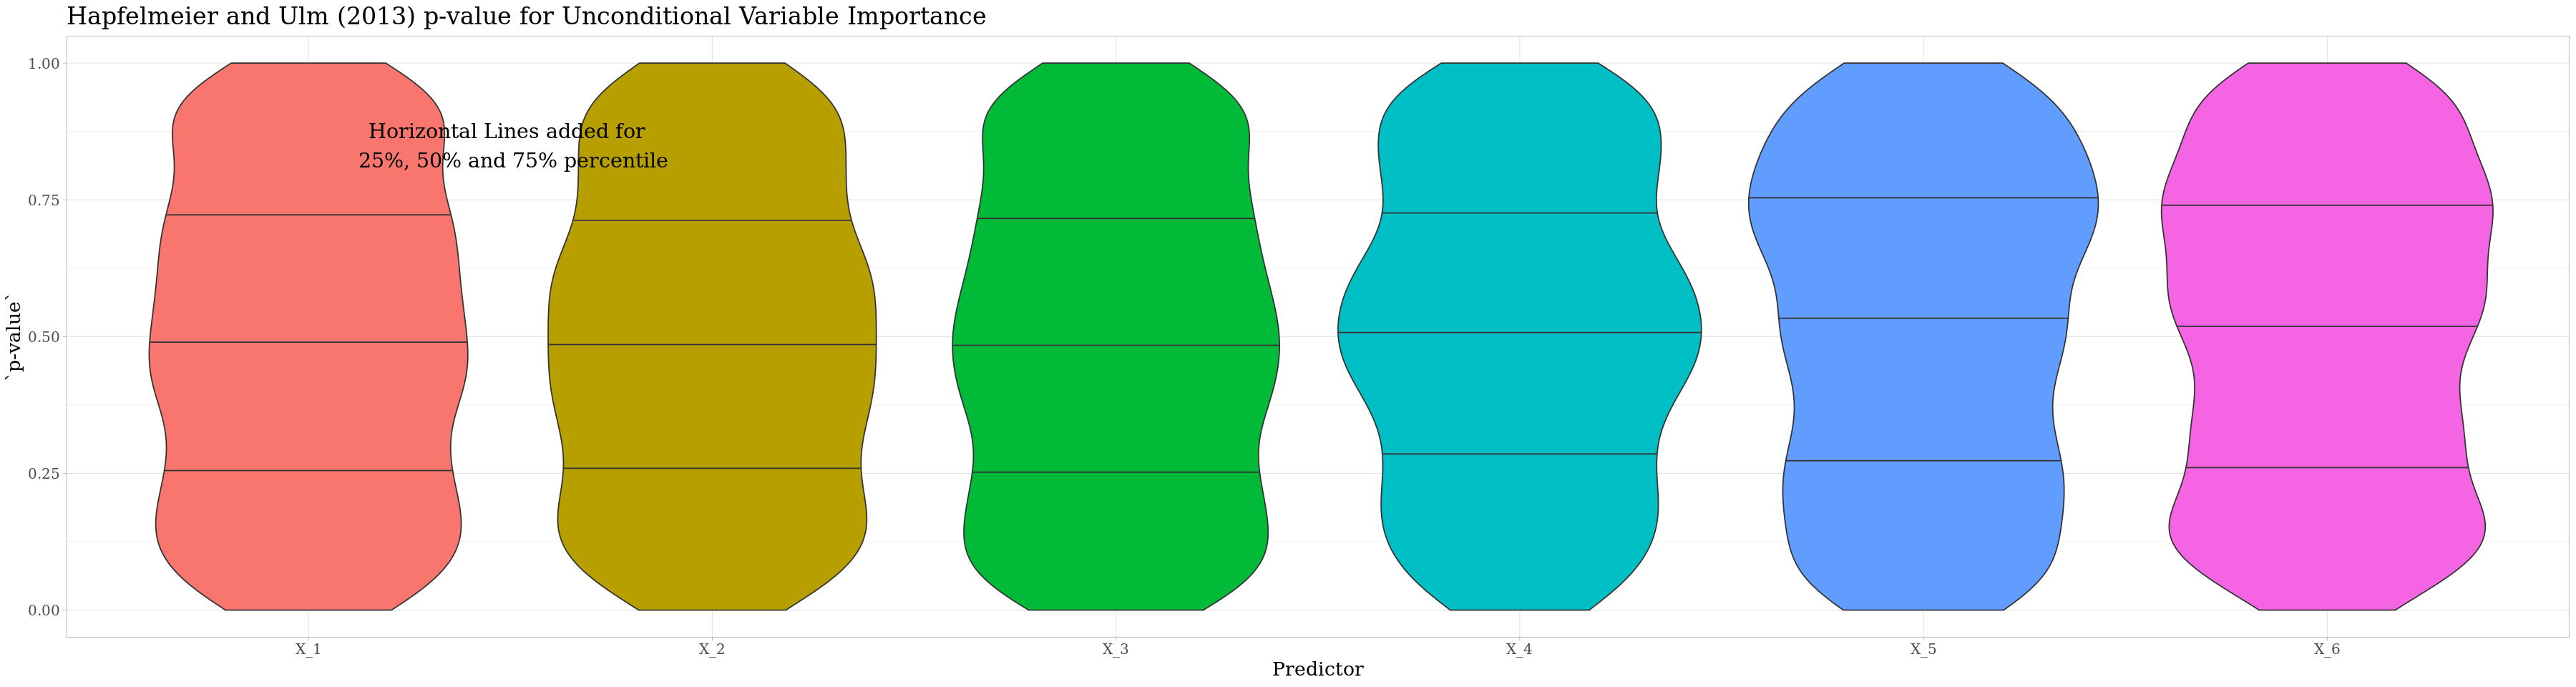

In [165]:
HU_pval_UNCOND_vis()

#### Simulation 2
---
This simulation is meant to analyze the perfomance of the different methods in differentiating between predictors that are actually causally linked to the response variable and those that are only correlated to intrinsically informative predictors. An importance measure that perfectly captures this distinction and shows no biases towards groups of correlated variables should therefore give similar weight to predictors 1, 3, 5 and 7 and similar but substantially smaller weight to 2, 4, 6 and 8. This idea of importance corresponds to the second notion introduced in the theoretical part of this project. *Strobl, Boulesteix, Kneib, Augustin, and Zeiles (2008)* argue that their conditional importance measure should be better in making this distinction and *Hapfelmeier and Ulm (2013)* mention the possibility to combine their method with conditional importance measures to adjust for differing notions of informative predictors. <br>
The different ways methods interact with data showing correlated predictors can be seen in the following.

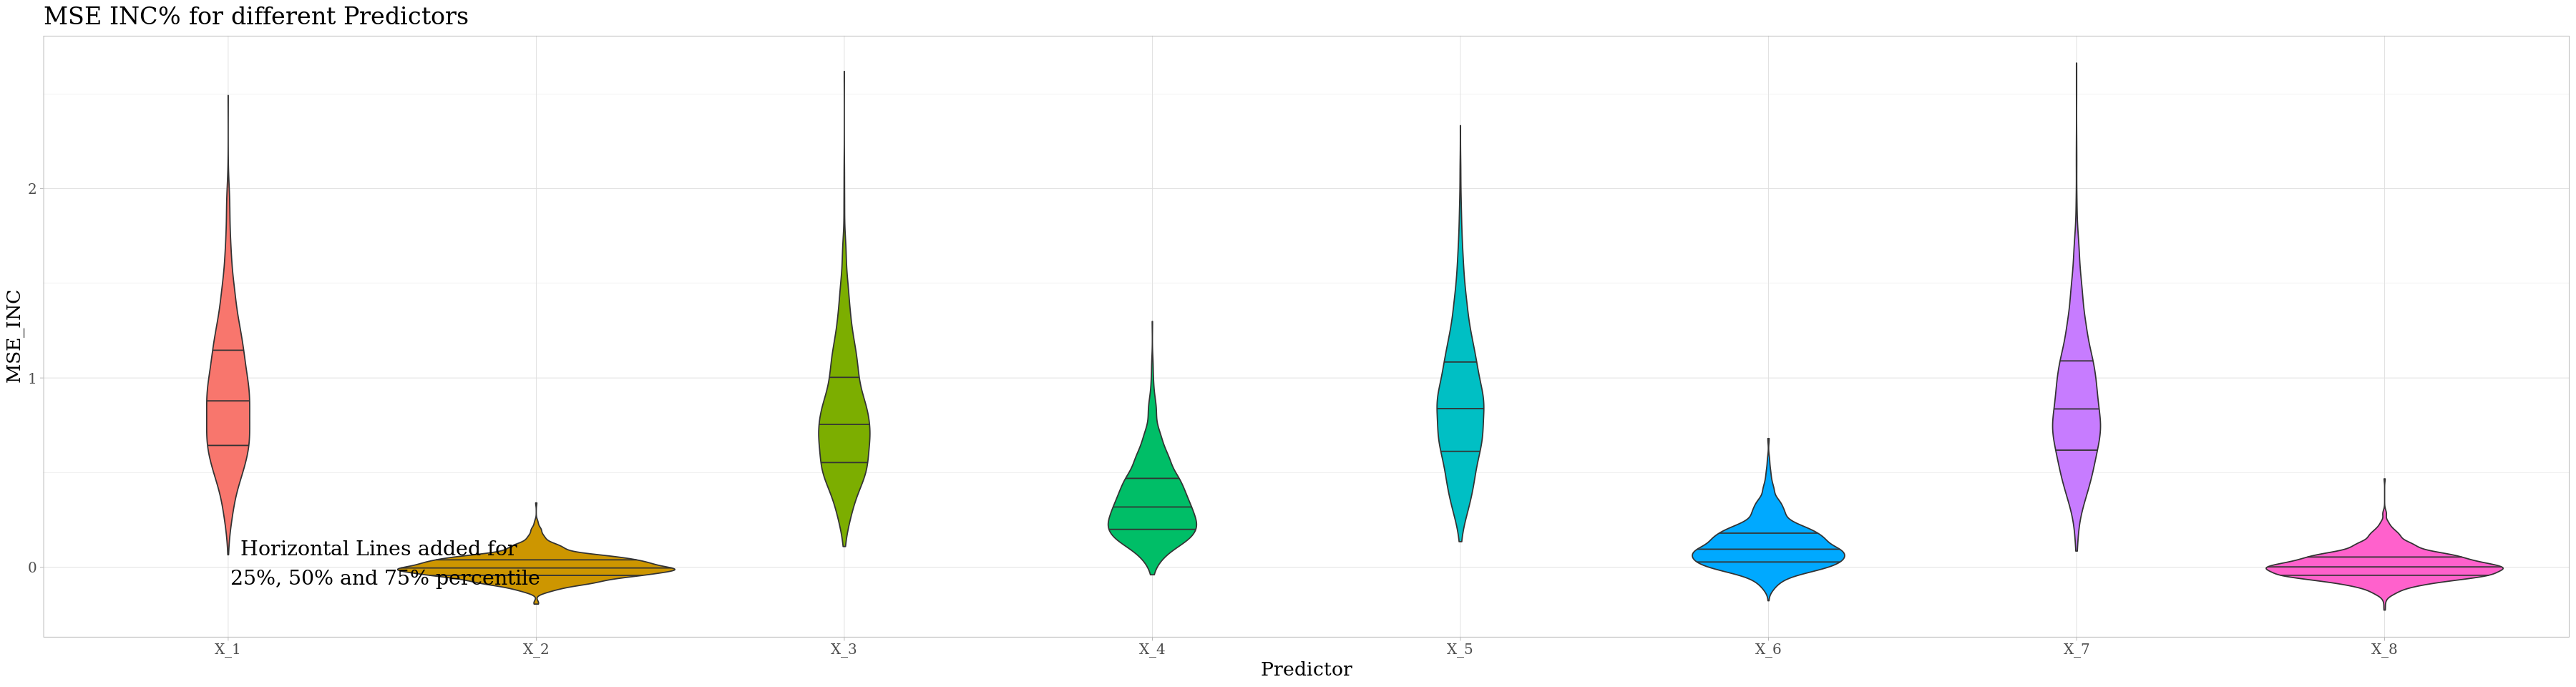

In [166]:
CART_rf_INC_MSE_vis_2()

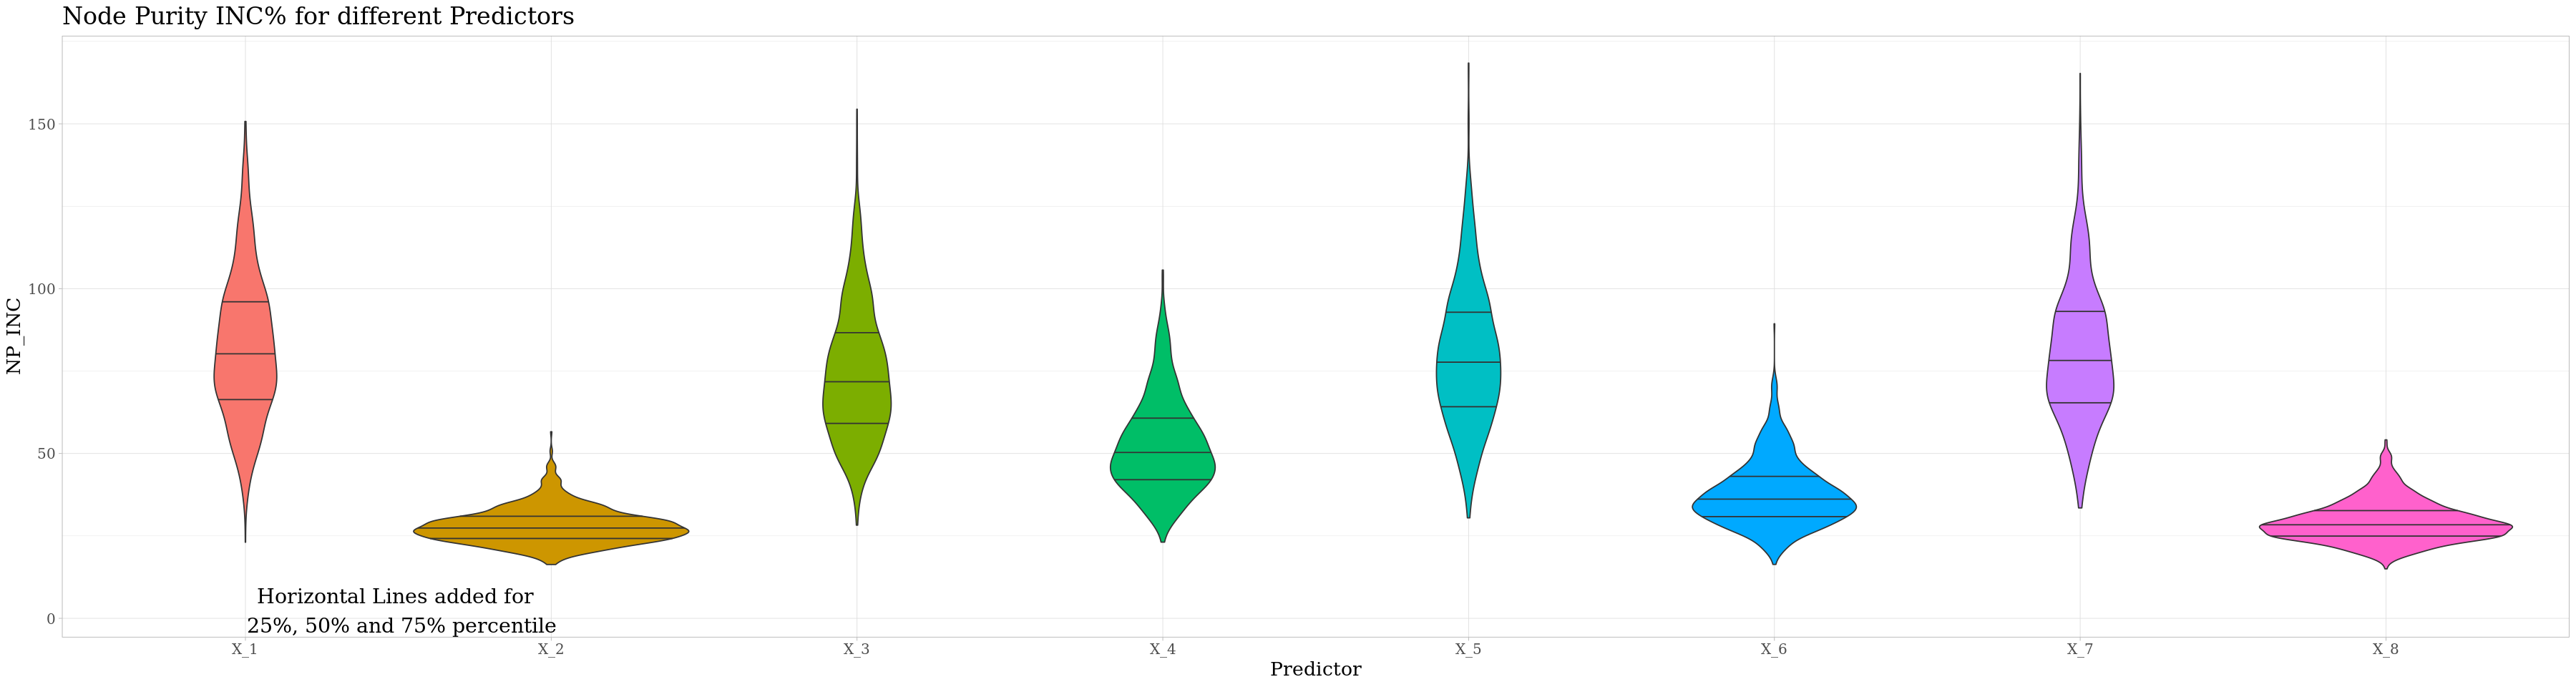

In [167]:
CART_rf_INC_NP_vis_2()

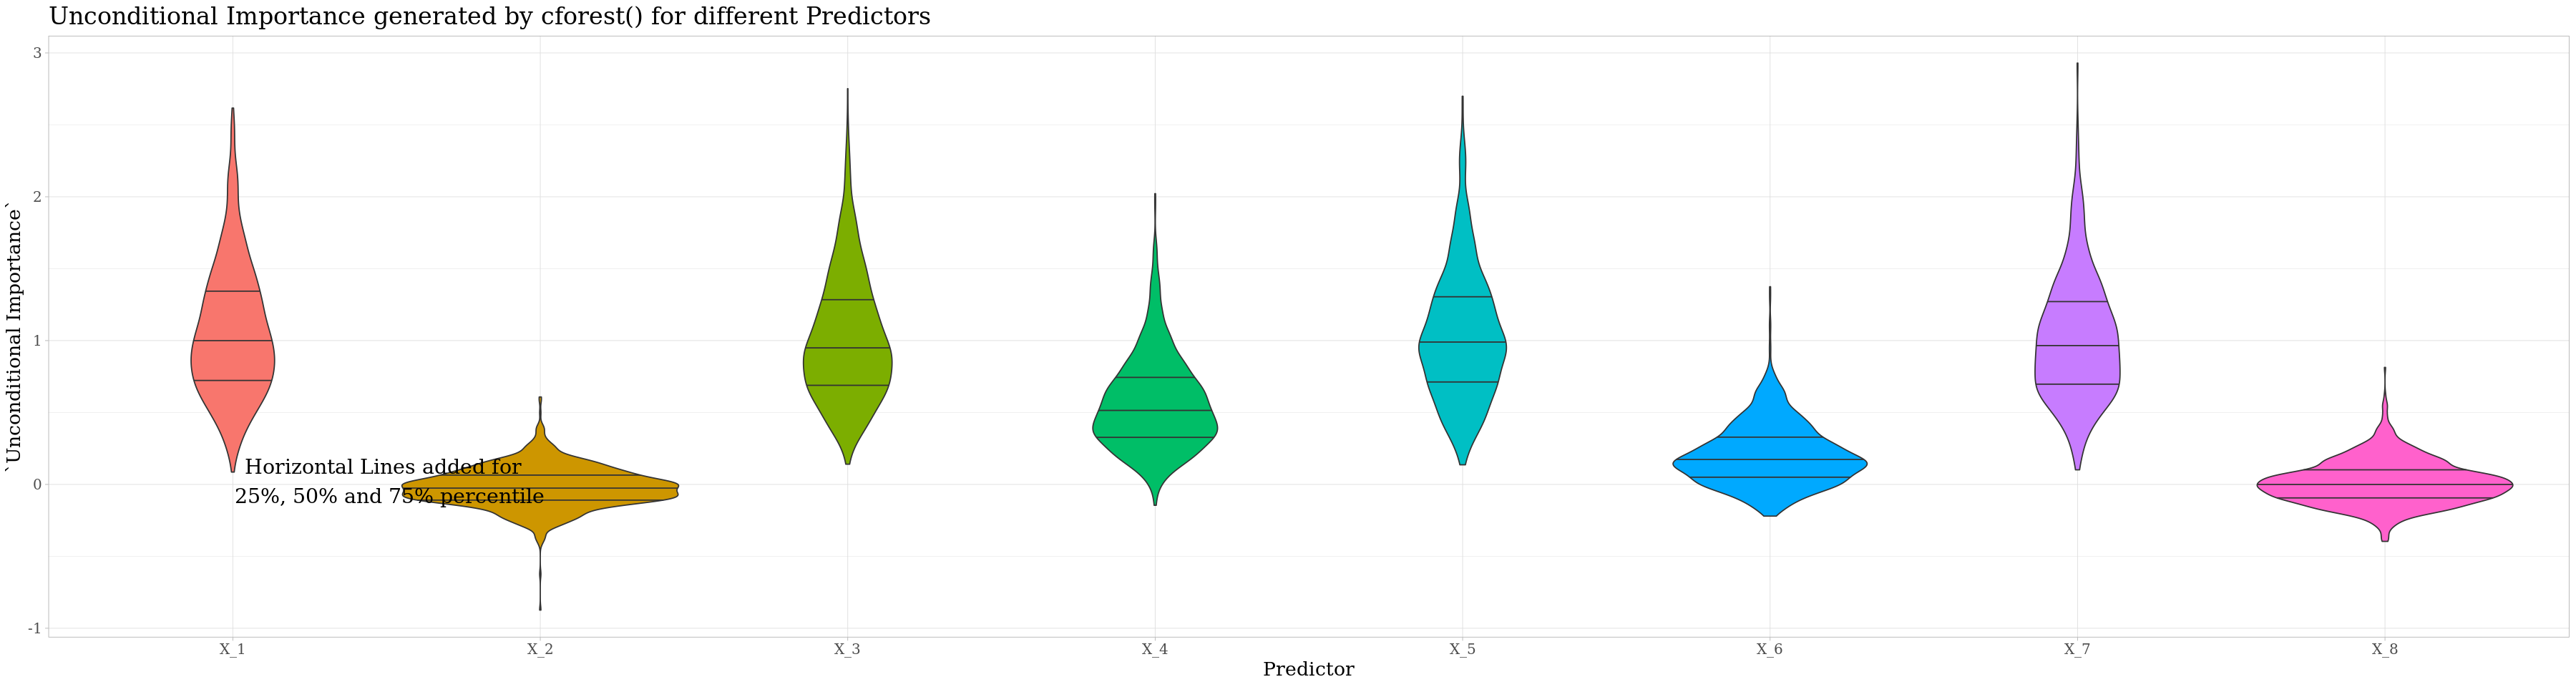

In [168]:
CIT_rf_UNCOND_IMP_vis_2()

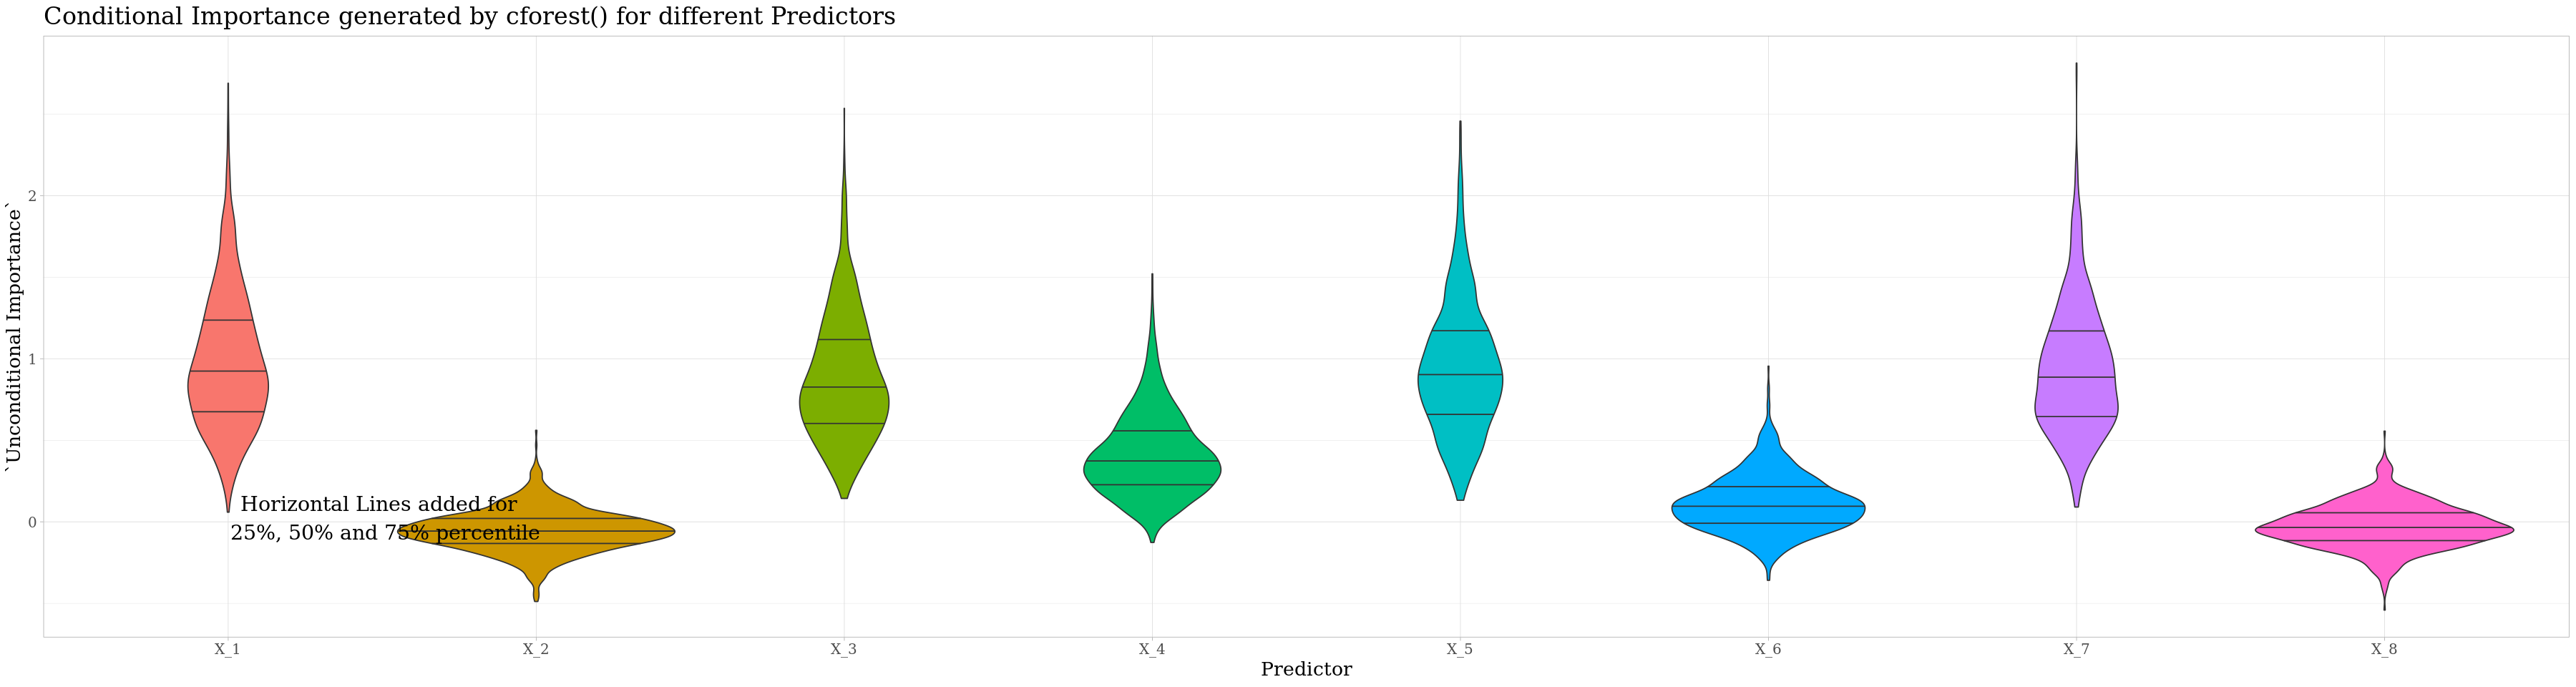

In [169]:
CIT_rf_COND_IMP_vis_2()

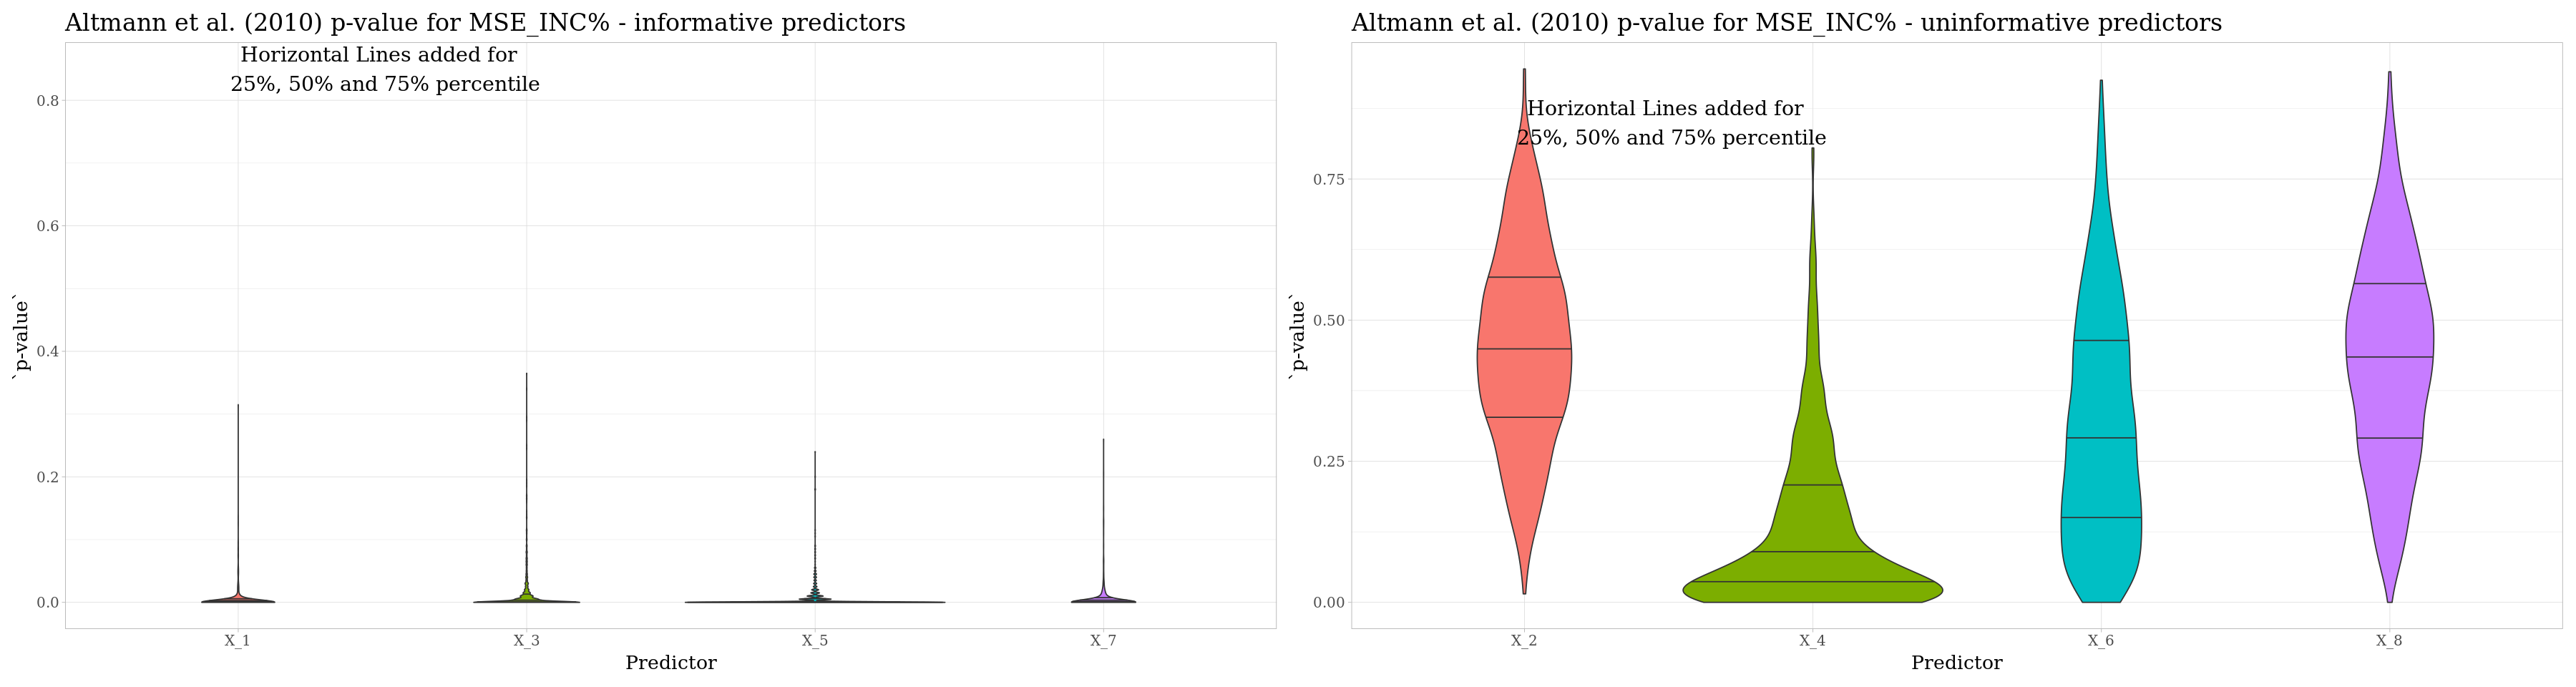

In [170]:
Altm_pval_INC_MSE_vis_2()

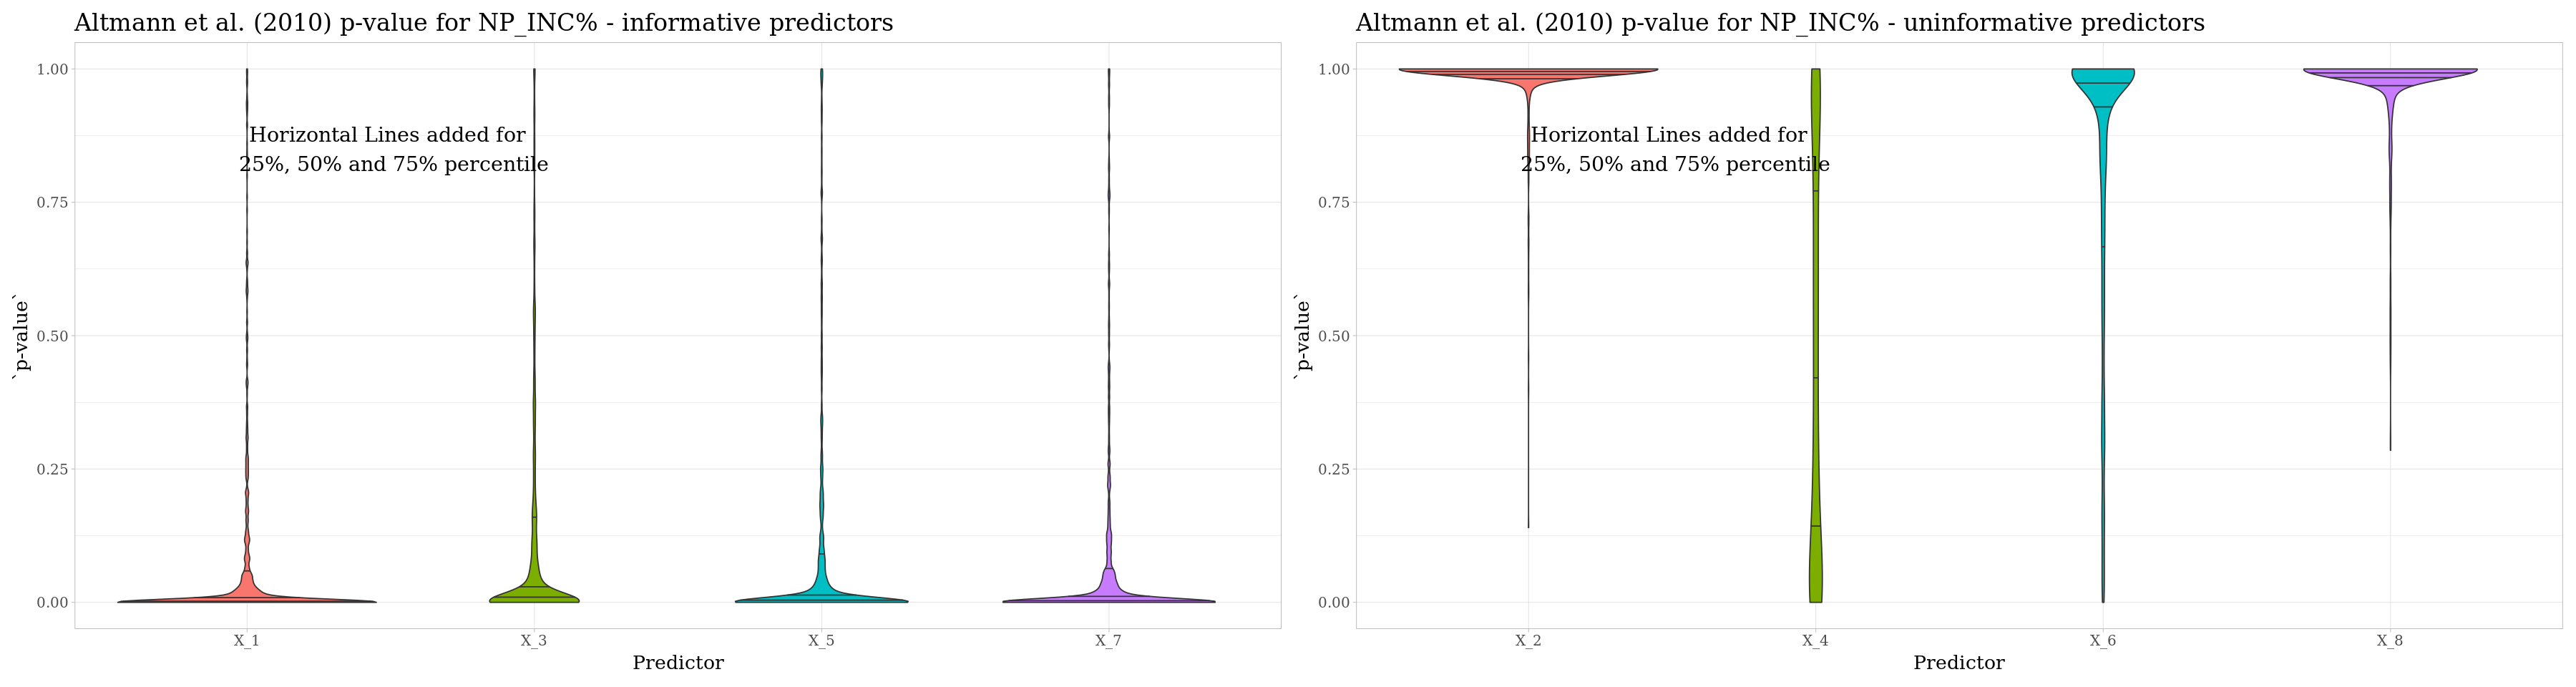

In [171]:
Altm_pval_INC_NP_vis_2()

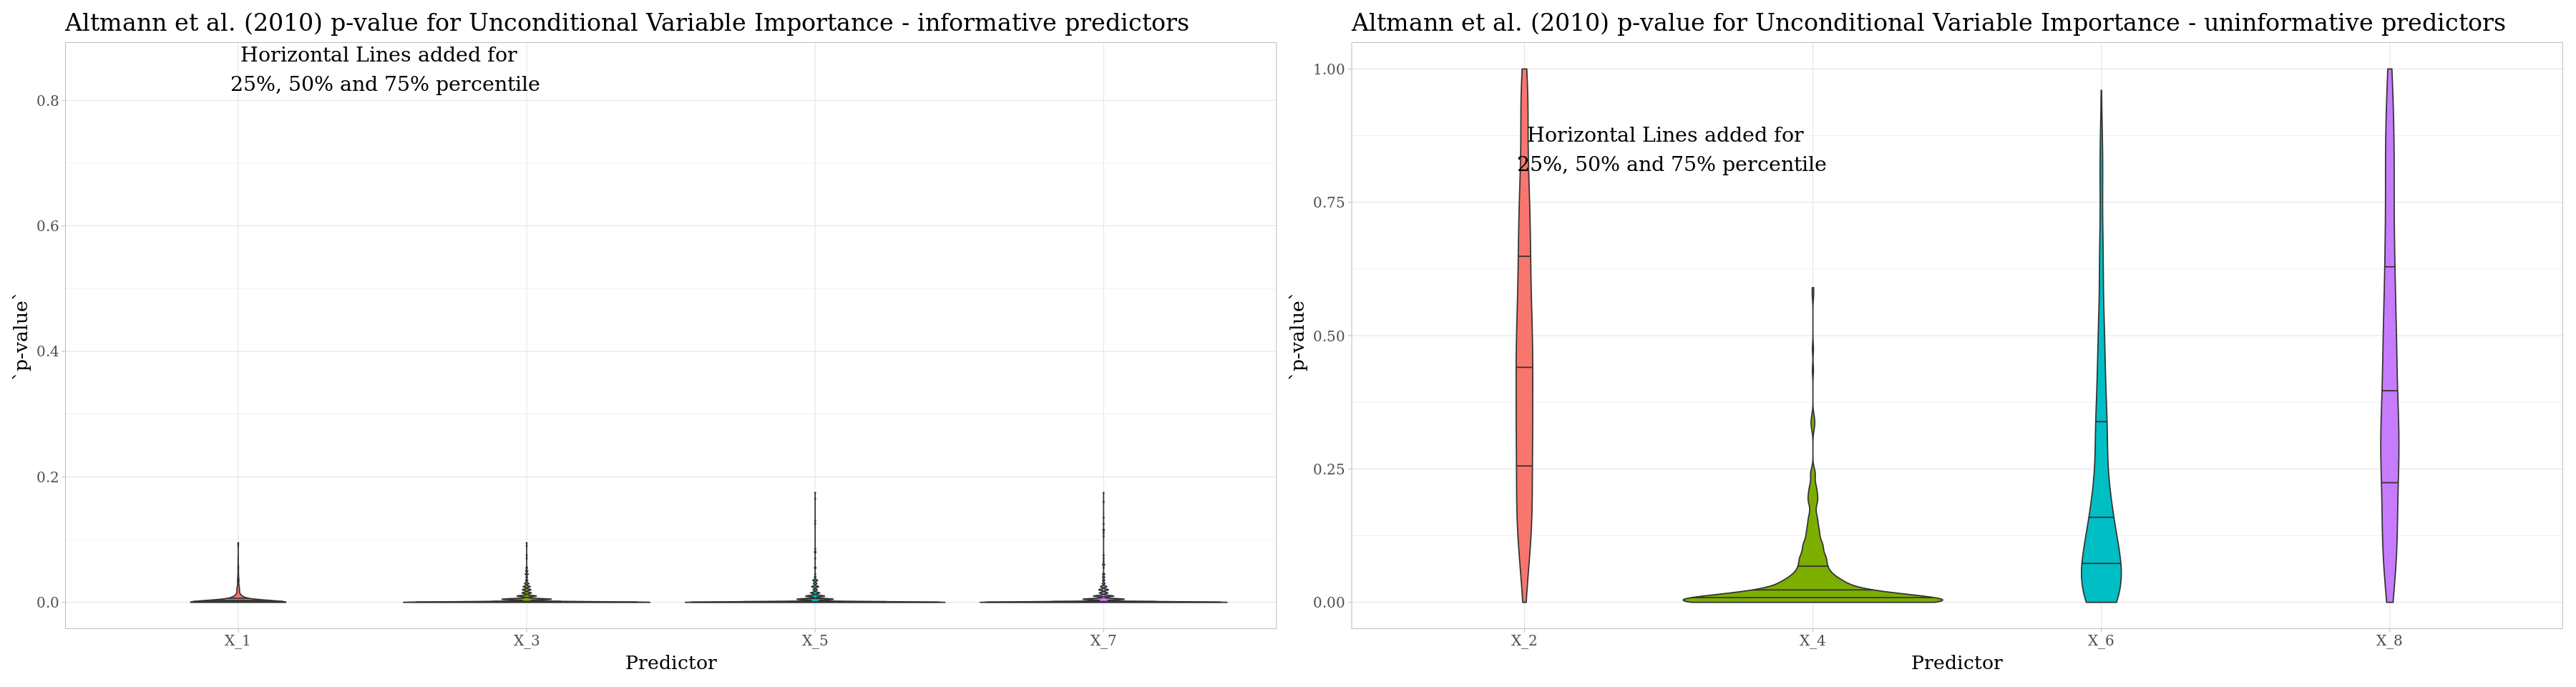

In [172]:
Altm_pval_UNCOND_vis_2()

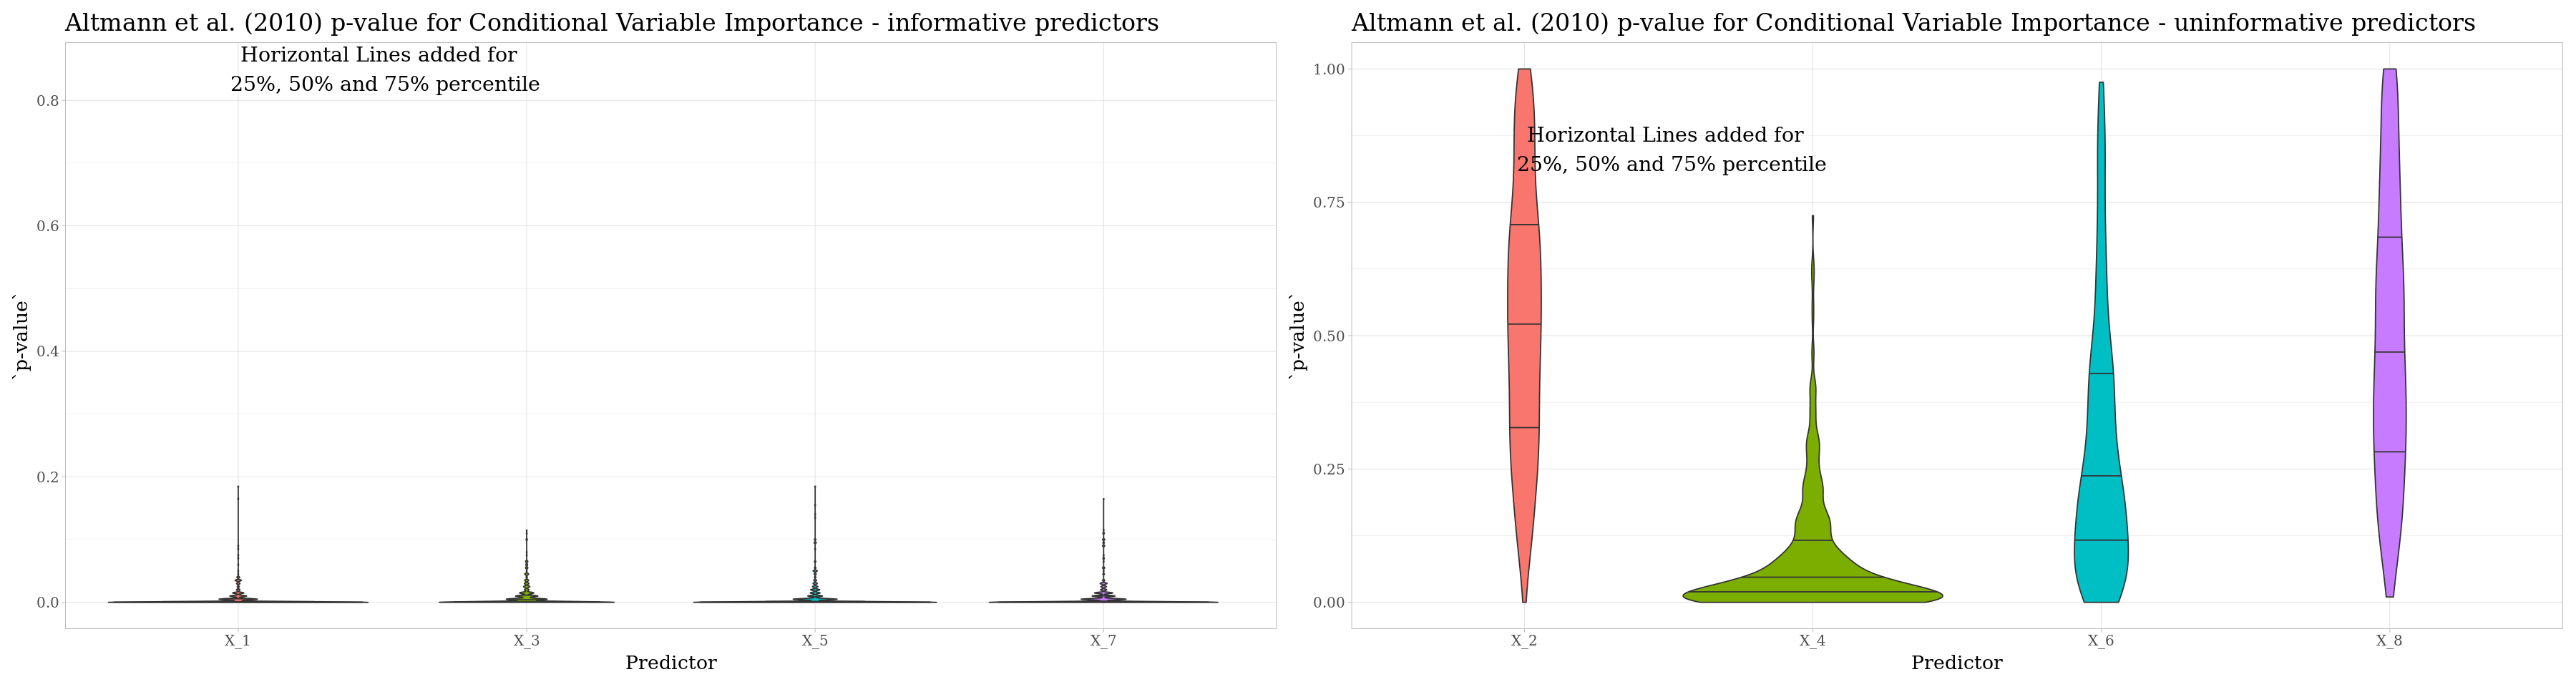

In [173]:
Altm_pval_COND_vis_2()

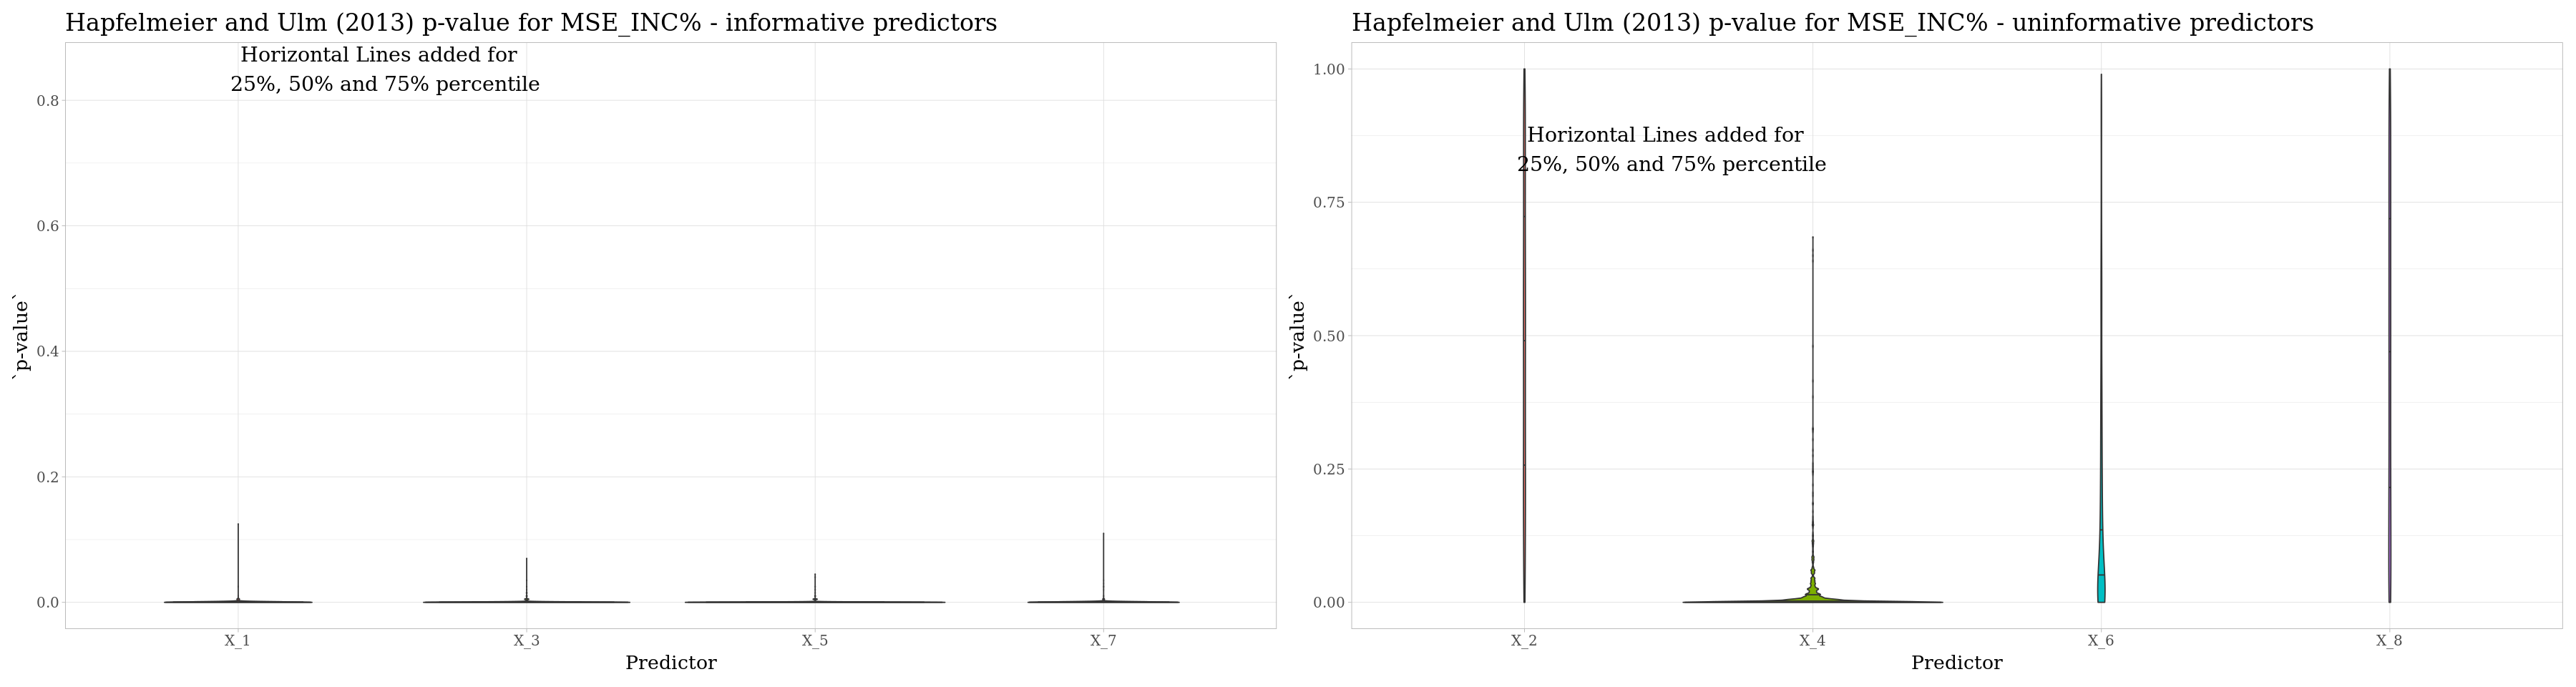

In [174]:
HU_pval_INC_MSE_vis_2()

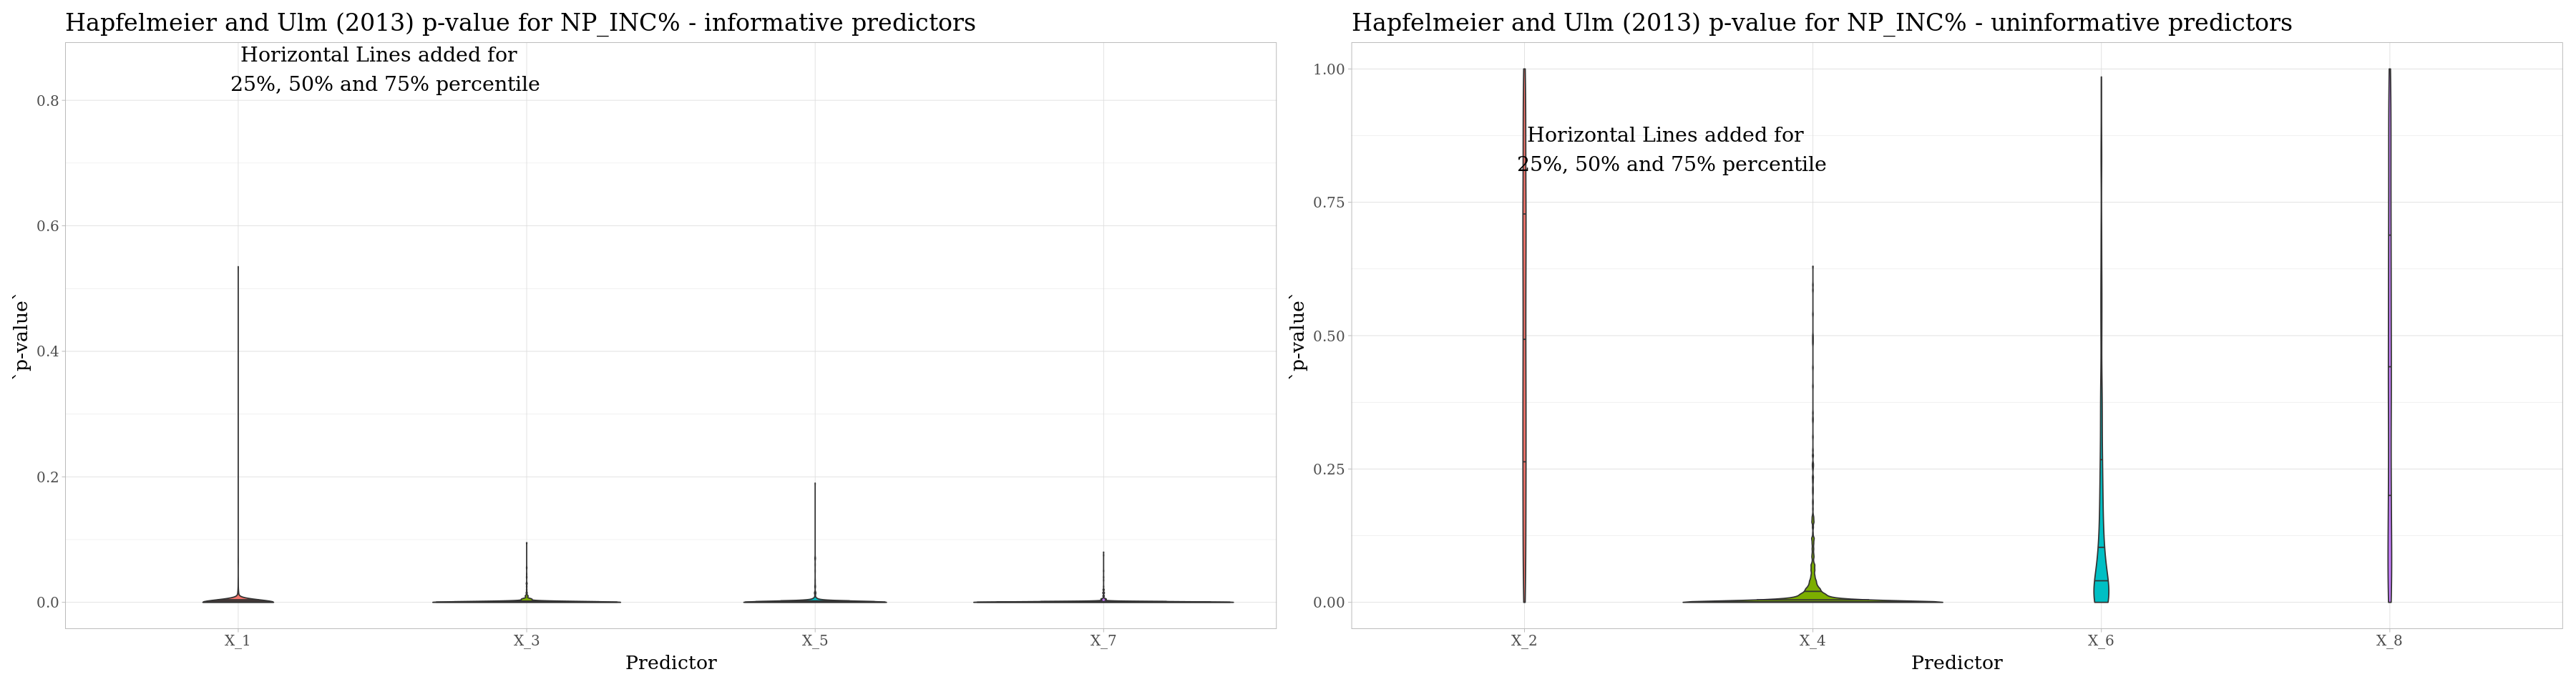

In [175]:
HU_pval_INC_NP_vis_2()

In [ ]:
HU_pval_UNCOND_vis_2()

In [ ]:
HU_pval_COND_vis_2()

## Application <a name="application"></a>
---
Typical applications of tree-based feature selection methods and especially random forest variable importance measures can be found in fields like biostatistics due to the prevalence of high dimensional data and the ability of tree based methods to deal with the corresponding problems. However, due to the typical size of datasets based on for example single cell sequencing which can be in the hundreds of gigabytes, I chose to analyze a slightly different data set. <br>
The data set in question was taken from https://hbiostat.org/data/ (or http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Diabetes.html) and deals with predictions of diabetes in African Americans based on multiple predictors including weight and other physical properties of patients. For further information on the data set consult *Willems, Saunders, Hunt, and Schorling (1997)* and *Schorling, Roach, Siegel, Baturka, Hunt, Guterbock, and Stewart (1997)*. The data set contains the following variables: <br>

| Identifier      	| Variable                                        	|
|----------	|---------------------------------------------------	|
| id       	| subject id                                        	|
| chol     	| Total Cholesterol                                 	|
| stab.glu 	| Stabilized Glucose                                	|
| hdl      	| High Density Lipoprotein                          	|
| ratio    	| Cholesterol/HDL Ratio                             	|
| glyhb    	| Glycosolated Hemoglobin                           	|
| location 	| a factor with levels (Buckingham,Louisa)          	|
| age      	| age (years)                                       	|
| gender   	| male or female                                    	|
| height   	| height (inches)                                   	|
| weight   	| weight (pounds)                                   	|
| frame    	| a factor with levels (small,medium,large)         	|
| bp.1s    	| First Systolic Blood Pressure                     	|
| bp.1d    	| First Diastolic Blood Pressure                    	|
| bp.2s    	| Second Diastolic Blood Pressure                   	|
| bp.2d    	| Second Diastolic Blood Pressure                   	|
| waist    	| waist in inches                                   	|
| hip      	| hip in inches                                     	|
| time.ppn 	| Postprandial Time when Labs were Drawn in minutes 	|

As missing values cannot be addressed by the methods presented in this project, I decided to remove the columns **bp.2s** and **bp.2d** due to regular occurence of **NA**s. <br>
The complementary information of the data set states that "Glycosolated hemoglobin > 7.0" is typically taken as a positive diagnosis for diabetes, this will be the continuous response variable. For technical reasons, the response variable has to be encoded as **Y**, therefore a renaming has to take place. I additionally drop all observations that contain missing values in any of the remaining variables. <br>

After this treatment, the data set contains 366 observations of 15 predictors and the response variable.

In [95]:
diabetes <-  suppressMessages(read_csv("Data/Application/diabetes.csv"))  %>% 
    select(-c("id", "bp.2d", "bp.2s")) %>% 
    filter_all(all_vars(!is.na(.)))

diabetes[c('location', 'gender', 'frame')] <- lapply(diabetes[c('location', 'gender', 'frame')], as.factor)

diabetes <- diabetes[, c(5, 1:4, 6:16)]
names(diabetes)[1] <- 'Y'

A typical subset of the data set could look like the following exerpt.

In [ ]:
head(diabetes)

#### Importance Measure Calculation
---
Calculating multiple importance measures as previously done in the simulation studies:

In [115]:
appl_rf <- randomForest(Y ~ ., diabetes, importance = TRUE)
appl_crf <- cforest(Y ~ ., diabetes, ntree = 500)

In [116]:
crf_UNCOND_imp <- varimp(appl_crf, conditional = FALSE)
crf_COND_imp <- varimp(appl_crf, conditional = TRUE)

Combining calculated importance measures into data.frame and saving results to "Data/Application/importances.RDS" :

In [117]:
appl_importances <- data.frame(IncMSE = appl_rf$importance[,1],
                               IncNP = appl_rf$importance[,2],
                               UNCOND = crf_UNCOND_imp,
                               COND = crf_COND_imp)

saveRDS(object = appl_importances, file = "Data/Application/importances.RDS")

Generating Null Importances following *Altmann, Toloşi, Sander, and Lengauer (2010)* for the four previously determined importance measures:

In [ ]:
run_1 <- FALSE

if(run_1 == TRUE){

cl <- parallel::makeForkCluster(n_cores - 1)

appl_Altm_CART <- Altm_Null_Imp(cl = cl, seed = 42, df = diabetes, ntree = 500,
                                    reps = 200, rf_type = 'randomForest')

appl_Altm_CART_NULLIMP <- Altm_NullImp_Transf(appl_Altm_CART, rf_type = 'randomForest')

saveRDS(object = appl_Altm_CART_NULLIMP, file = "Data/Application/Altmann/CART_NULLIMP.RDS")

appl_Altm_CIT <- Altm_Null_Imp(cl = cl, seed = 42, df = diabetes, ntree = 500,
                                    reps = 200, rf_type = 'cforest', conditional = TRUE)

appl_Altm_CIT_NULLIMP <- Altm_NullImp_Transf(appl_Altm_CIT, rf_type = 'cforest', conditional = TRUE)

saveRDS(object = appl_Altm_CIT_NULLIMP, file = "Data/Application/Altmann/CIT_NULLIMP.RDS")

stopCluster(cl)
}

Doing the same following *Hapfelmeier and Ulm (2013)*: <br>
(This run alone takes about 7 hours)

In [121]:
run_2 <- FALSE

if(run_2 == TRUE){
cl <- parallel::makeForkCluster(n_cores - 1)

appl_HU_CART <- HU_Null_Imp(cl = cl, seed = 42, df = diabetes, ntree = 500,
                            reps = 200, rf_type = 'randomForest')

appl_HU_CART_NULLIMP <- HU_NullImp_RF_Transf(appl_HU_CART, rf_type = 'randomForest')

saveRDS(object = appl_HU_CART_NULLIMP, file = "Data/Application/Hapfelmeier/CART_NULLIMP.RDS")

appl_HU_CIT <- HU_Null_Imp(cl = cl, seed = 42, df = diabetes, ntree = 500,
                           reps = 200, rf_type = 'cforest', conditional = TRUE)

appl_HU_CIT_NULLIMP <- HU_NullImp_RF_Transf(appl_HU_CIT, rf_type = 'cforest', conditional = TRUE)

saveRDS(object = appl_HU_CIT_NULLIMP, file = "Data/Application/Hapfelmeier/CIT_NULLIMP.RDS")

stopCluster(cl)
}

Calculating p-values as previously described.

In [141]:
appl_importances <- readRDS("Data/Application/importances.RDS")

appl_Altm_CART_NULLIMP <- readRDS("Data/Application/Altmann/CART_NULLIMP.RDS")
appl_Altm_CIT_NULLIMP <- readRDS("Data/Application/Altmann/CIT_NULLIMP.RDS")
appl_HU_CART_NULLIMP <- readRDS("Data/Application/Hapfelmeier/CART_NULLIMP.RDS")
appl_HU_CIT_NULLIMP <- readRDS("Data/Application/Hapfelmeier/CIT_NULLIMP.RDS")

num_predictors <- 15

appl_Altm_p_vals_INC_MSE <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = appl_importances[j,1], vec_null_imp = appl_Altm_CART_NULLIMP$MSE_inc[j,])))
            
appl_Altm_p_vals_INC_NP <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = appl_importances[j,2], vec_null_imp = appl_Altm_CART_NULLIMP$node_impur[j,])))
            
appl_Altm_p_vals_UNCOND_IMP <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = appl_importances[j,3], vec_null_imp = appl_Altm_CIT_NULLIMP$uncond[j,])))
            
appl_Altm_p_vals_COND_IMP <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = appl_importances[j,4], vec_null_imp = appl_Altm_CIT_NULLIMP$cond[j,])))
            
appl_Altm_pvals <- data.frame(INC_MSE = appl_Altm_p_vals_INC_MSE,
                              INC_NP = appl_Altm_p_vals_INC_NP,
                              UNCOND = appl_Altm_p_vals_UNCOND_IMP,
                              COND = appl_Altm_p_vals_COND_IMP)
            
saveRDS(object = appl_Altm_pvals, file = "Data/Application/Altm_p_values.RDS")

appl_HU_p_vals_INC_MSE <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = appl_importances[j,1], vec_null_imp = appl_HU_CART_NULLIMP$MSE_inc[j,])))
            
appl_HU_p_vals_INC_NP <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = appl_importances[j,2], vec_null_imp = appl_HU_CART_NULLIMP$node_impur[j,])))
            
appl_HU_p_vals_UNCOND_IMP <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = appl_importances[j,3], vec_null_imp = appl_HU_CIT_NULLIMP$uncond[j,])))
            
appl_HU_p_vals_COND_IMP <- unlist(
        map(.x = 1:num_predictors,
            .f = function(j) imp_p_val(imp = appl_importances[j,4], vec_null_imp = appl_HU_CIT_NULLIMP$cond[j,])))        

appl_HU_pvals <- data.frame(INC_MSE = appl_HU_p_vals_INC_MSE,
                              INC_NP = appl_HU_p_vals_INC_NP,
                              UNCOND = appl_HU_p_vals_UNCOND_IMP,
                              COND = appl_HU_p_vals_COND_IMP)     
            
saveRDS(object = appl_HU_pvals, file = "Data/Application/HU_p_values.RDS")

#### Results 
---
Applying these different methods to a real world data set reveals that even in a setting, that is not precisely tailored to reveal the flaws of each method, the differences can be large.

In [201]:
source("Auxiliary/Visualizations.R")

Starting with the importances generated by a single random forest based on **CART**, we can see that both methods put high importance on the level of stable glucose which is not surprising as this variable is medically quite close to the response variable. However, looking at the other predictors it becomes apparent, that even though the measures often share qualitative features, some important differences for example in the ordering of importances arise. One example is the importance given to the heigth of a patient which is considerably higher in relative terms in the importances determined by increases in node purity. <br>
To understand these differences, however, well-founded knowledge of the underlying subject and the specifics of these methods would be needed.

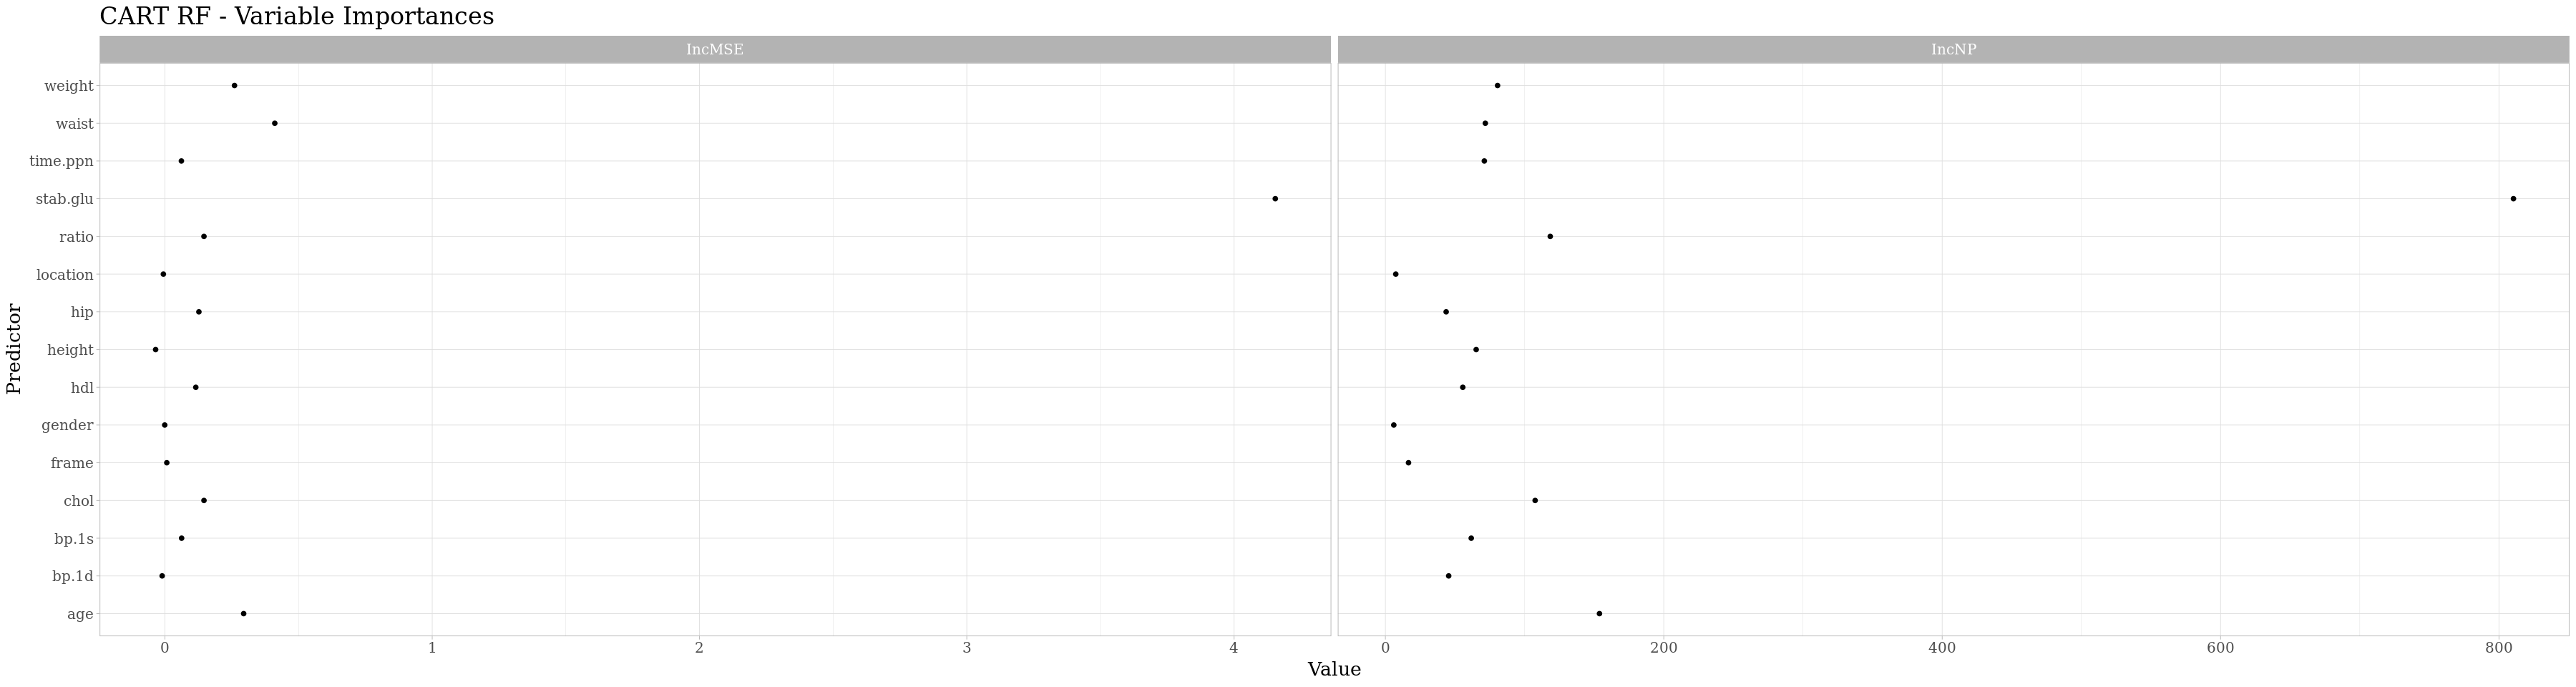

In [202]:
appl_CART_rf_VARIMP_vis()

When using a random forest based on **CIT**, calculating both unconditional and conditional importances, there are also interesting differences. <br>
Again high importance associated with stable glucose levels is indicated by both methods. Looking at the other predictors reveals, that unconditional importance also puts considerable importance on waist circumference, the ration of Cholesterol and High Density Lipoprotein, age, and to a limited extend cholesterol levels. Conditional importance in contrast only seems to indicate importance of age in addition to stable glucose levels. This could indicate problems of correlation leading to 

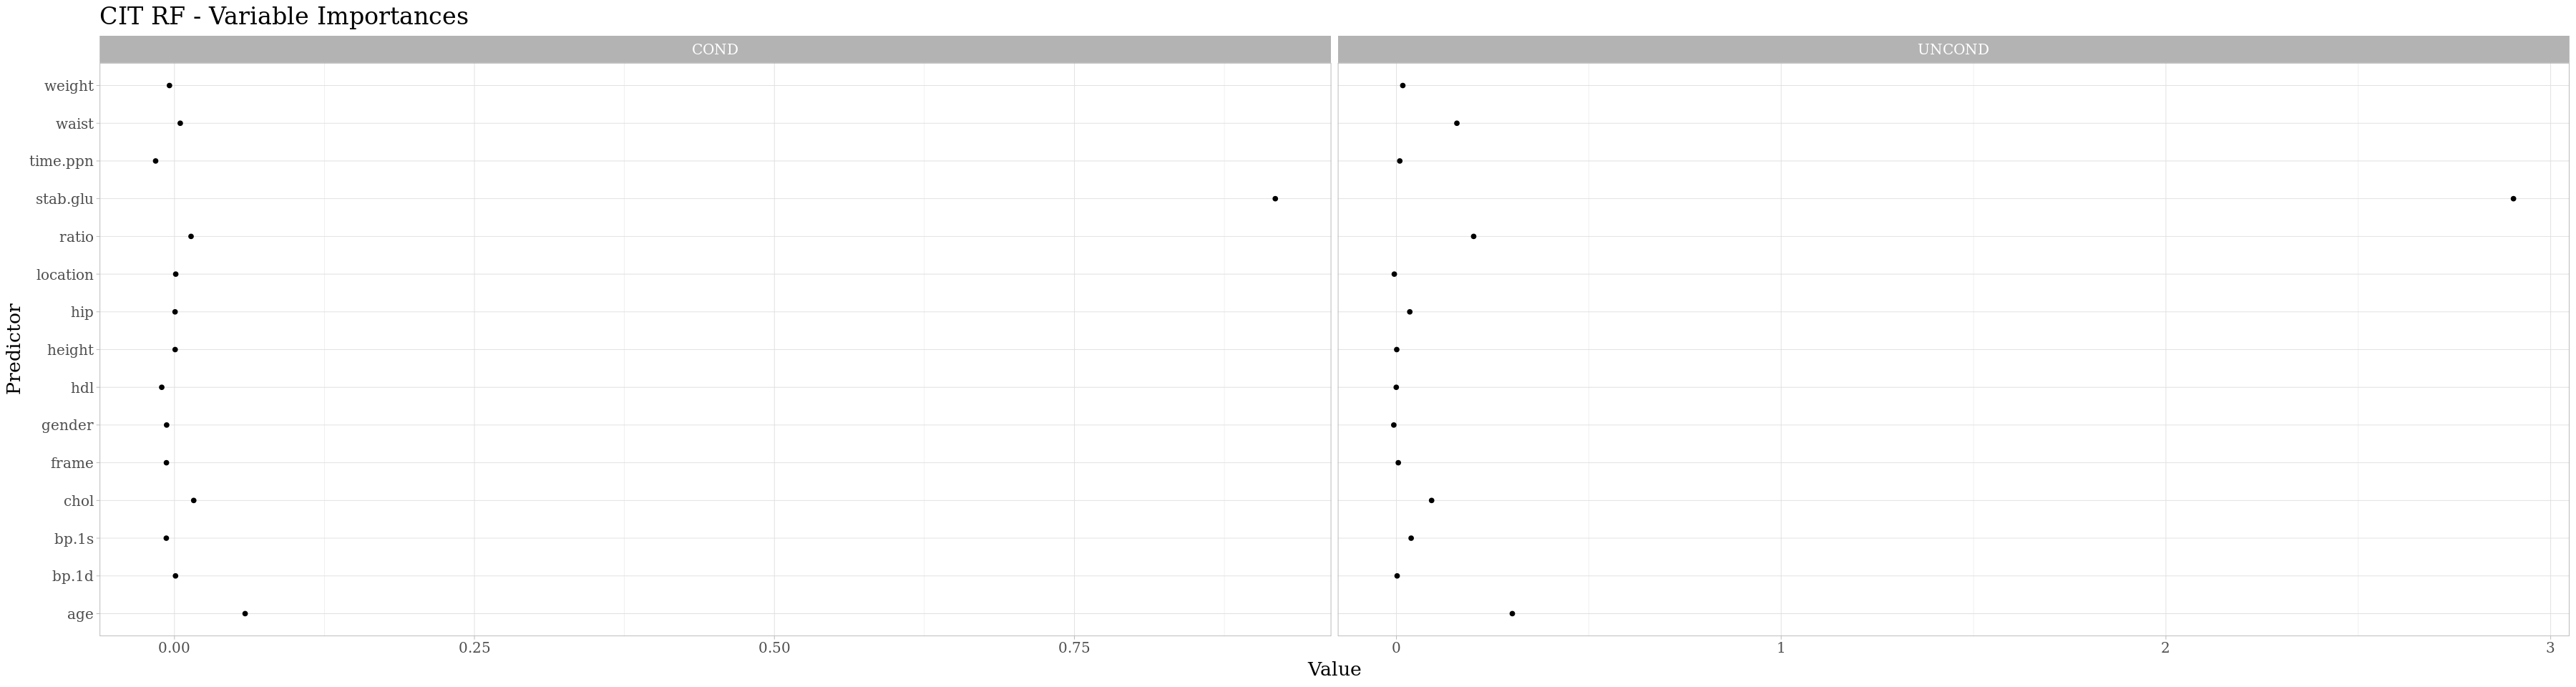

In [203]:
appl_CIT_rf_VARIMP_vis()

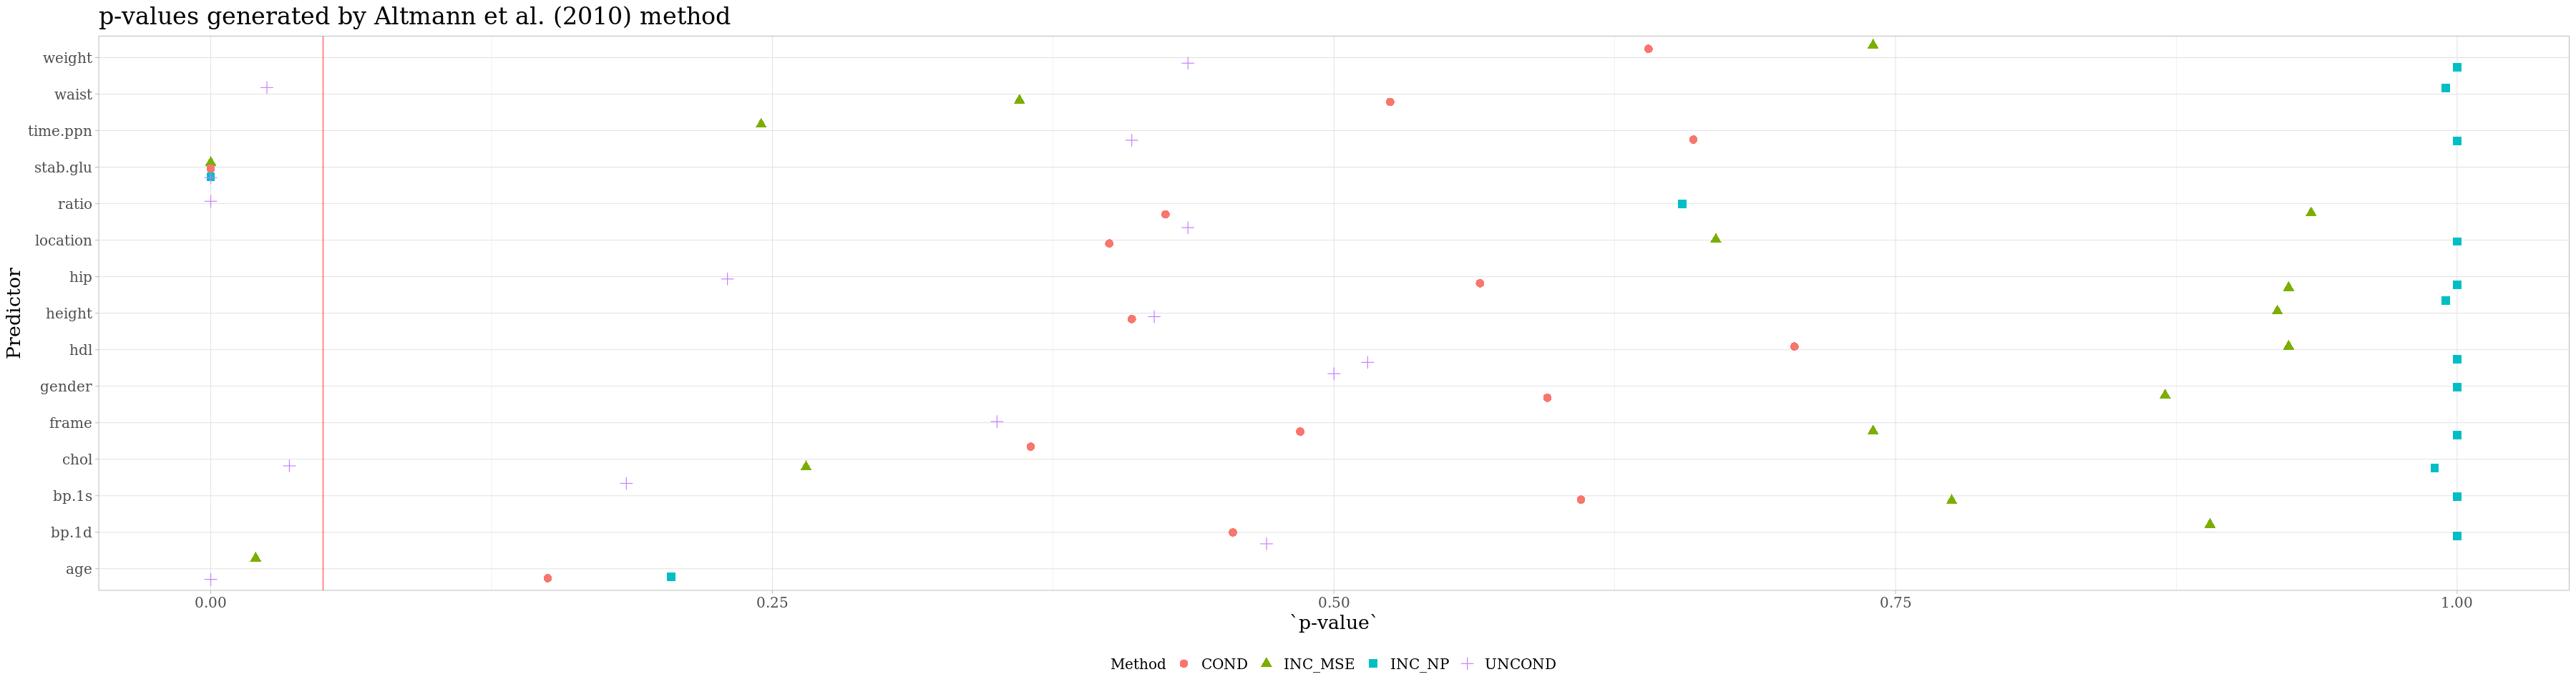

In [194]:
appl_Altm_vis()

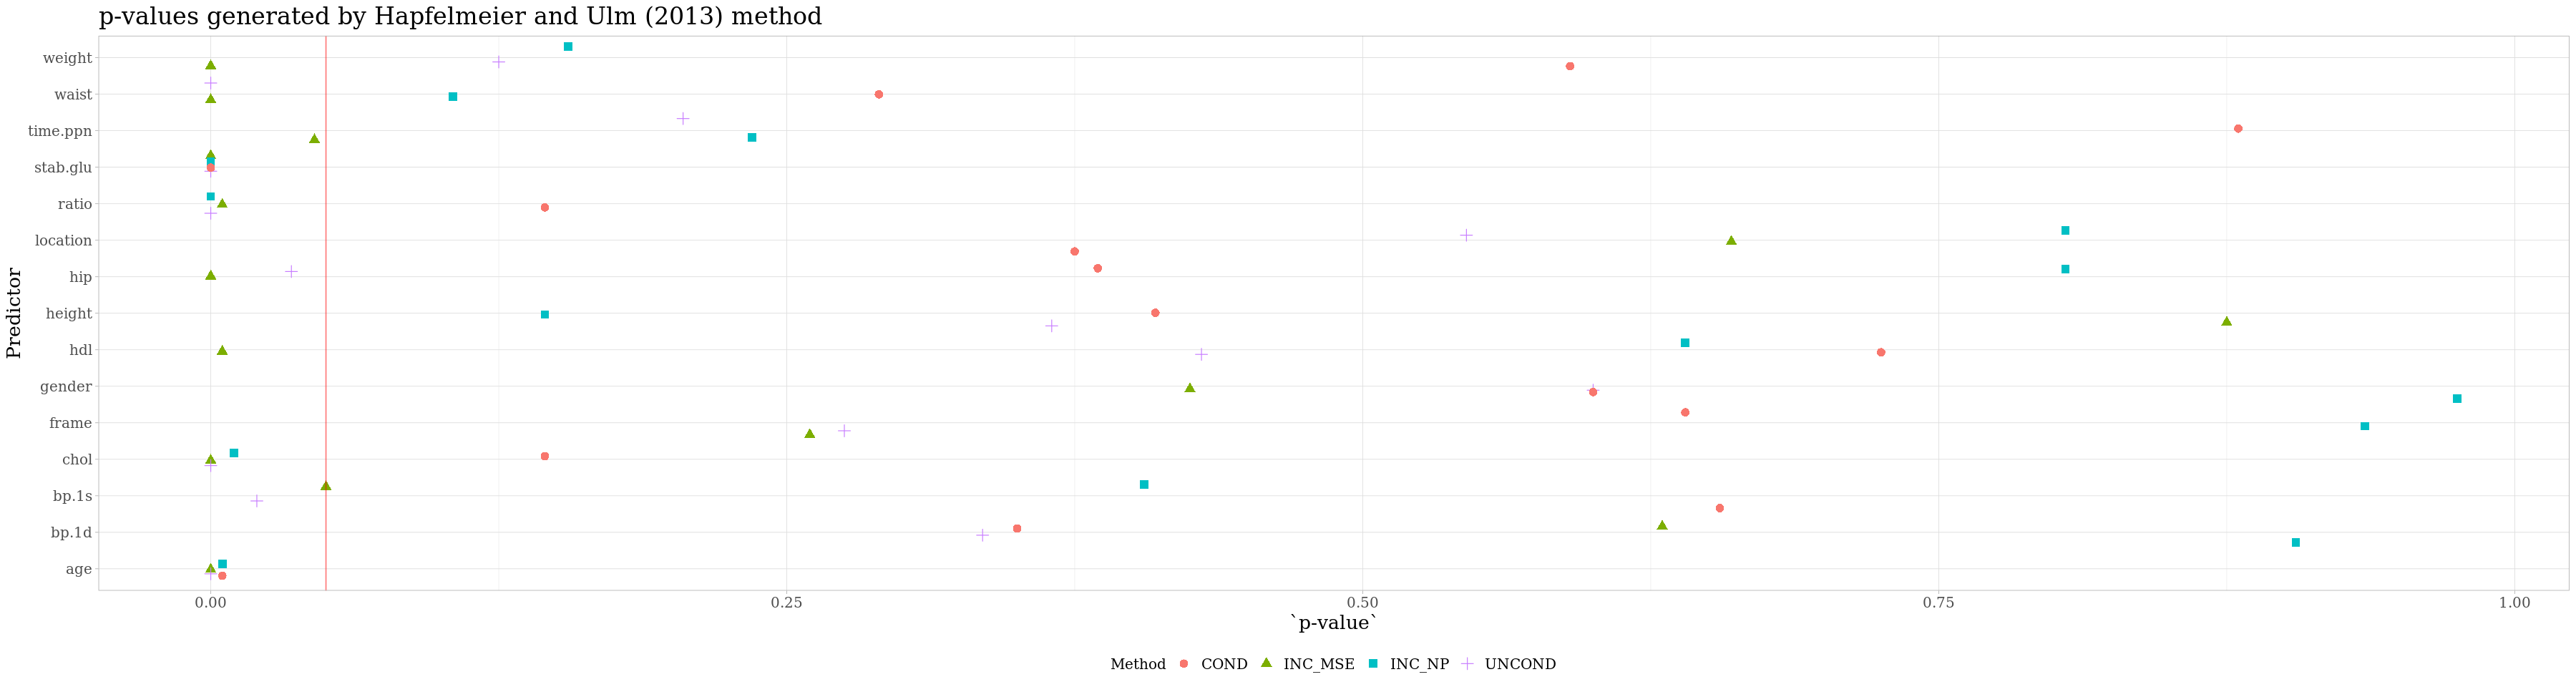

In [195]:
appl_HU_vis()

## Conclusion <a name="conclusion"></a>
---
The findings of this student project...

## Outlook and Possible Extensions <a name="outlook"></a>
---
Going beyond what is presented in this project has many fascinating possibilities. To name a few:
* **High-Dimensional Data**: As previously stated, tree-based methods are often especially interesting in high-dimensional settings due to their inherent strength in dealing with problems associated to data of this shape. Sadly, scientifically interesting simulations that mirror real world applications in this sense are not feasible when using existing implementations of **CIT** and its derivatives. These would either require a rewrite of these methods in a more performant way or the usage of significantly stronger hardware. Due to the inherent parallelizability of the methods presented in this project, the latter indicates the possibility of using a computing cluster to gain meaningful insight into the capabilities of these aforementioned methods in the setting of high-dimensional and extremely high-dimensional data sets.
* **Interactions of biases**: A more complex simulation that explores the interactions of the biases addresses in this project would be another logical next step. However, this would probably entail either a number of independent simulations with data generating processes of different structures or one precisely crafted simulation with a complex data generating process that ensures interpretability of the different effects and their interaction. This however would also make a more in depth theoretical analysis of the underlying causes and their interaction necessary that is out of the scope of this project.
* **Missing Data**: Further research in the direction of biases in random forest feature selection has been done to address problems of missing data. One interesting paper in this direction is *Hapfelmeier, Hothorn, Ulm and Strobl (2014)*, which could be incorporated into the simulation frameworks provided in this project. This would make a rewriting of the functions necessary but could reveal interesting information about feature selection when confronted with this typical feature of real world data.
* **Causality**: Further extending the ideas of differentiating the concepts of informative predictors and developping importance measures that are able to effectively deal with correlation can be an interesting subject in the context of causal inference as well. There is literature in the context of causal forests and similar concepts that explores ideas in this direction, but further research into new variable importance measures could be of great interest for econometric contexts.
* **Heuristics**: As the simulation part of this project has shown, some of the more complex methods are incredibly heavy in computational cost. Therefore, creating useful heuristics that approximate solutions created by methods formulating a precisely chosen Null hypothesis could be of great value. As the run-time of the method presented by *Hapfelmeier and Ulm (2013)* scales linearly in the number of predictors choosing a smaller subset of predictors with a less computationally expensive method before applying more expensive methods could considerably be of value in an applied context.

## Bibliography <a name="bibliography"></a>
---
* Altmann, André, Laura Toloşi, Oliver Sander, and Thomas Lengauer. “Permutation Importance: A Corrected Feature Importance Measure.” Bioinformatics (Oxford, England) 26, no. 10 (May 15, 2010): 1340–47. https://doi.org/10.1093/bioinformatics/btq134.
* Bickel, Peter J., and Jian-Jian Ren. “The Bootstrap in Hypothesis Testing.” State of the Art in Probability and Statistics, January 1, 2001, 91–112. https://doi.org/10.1214/lnms/1215090064.
* Breiman, Leo. “Random Forests.” Machine Learning 45, no. 1 (October 1, 2001): 5–32. https://doi.org/10.1023/A:1010933404324.
* Breiman, Leo, Jerome Friedman, Charles J. Stone, and R. A. Olshen. Classification and Regression Trees. Taylor & Francis, 1984.
* “Diabetes Dataset.” Accessed August 23, 2021. https://hbiostat.org/data/repo/diabetes.html.
* Dobra, Alin, and Johannes Gehrke. “Bias Correction in Classification Tree Construction.” In Proceedings of the Eighteenth International Conference on Machine Learning, 90–97. ICML ’01. San Francisco, CA, USA: Morgan Kaufmann Publishers Inc., 2001.
* Hapfelmeier, A., and K. Ulm. “A New Variable Selection Approach Using Random Forests.” Computational Statistics & Data Analysis 60 (April 1, 2013): 50–69. https://doi.org/10.1016/j.csda.2012.09.020.
* Hapfelmeier, Alexander, Torsten Hothorn, Kurt Ulm, and Carolin Strobl. “A New Variable Importance Measure for Random Forests with Missing Data.” Statistics and Computing 24, no. 1 (January 1, 2014): 21–34. https://doi.org/10.1007/s11222-012-9349-1.
* Ho, Tin Kam. “Random Decision Forests.” In Proceedings of 3rd International Conference on Document Analysis and Recognition, 1:278–82 vol.1, 1995. https://doi.org/10.1109/ICDAR.1995.598994.
* Hothorn, Torsten, Kurt Hornik, and Achim Zeileis. “Unbiased Recursive Partitioning: A Conditional Inference Framework.” Journal of Computational and Graphical Statistics 15, no. 3 (September 1, 2006): 651–74. https://doi.org/10.1198/106186006X133933.
* Hothorn, Torsten, and Achim Zeileis. “Partykit: A Modular Toolkit for Recursive Partytioning in R.” Journal of Machine Learning Research 16, no. 118 (2015): 3905–9.
* Ishwaran, Hemant. “Variable Importance in Binary Regression Trees and Forests.” Electronic Journal of Statistics 1, no. none (January 2007): 519–37. https://doi.org/10.1214/07-EJS039.
* James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An Introduction to Statistical Learning: With Applications in R. 1st ed. 2013, Corr. 7th printing 2017 edition. New York: Springer, 2013.
* Kononenko, Igor. “On Biases in Estimating Multi-Valued Attributes.” In Proceedings of the 14th International Joint Conference on Artificial Intelligence - Volume 2, 1034–40. IJCAI’95. San Francisco, CA, USA: Morgan Kaufmann Publishers Inc., 1995.
* Liaw, Andy, and Matthew Wiener. “Classification and Regression by RandomForest.” Forest 23 (November 30, 2001).
* “Manual On Setting Up, Using, And Understanding Random Forests V3.1.” Accessed August 8, 2021. https://www.stat.berkeley.edu/~breiman/Using_random_forests_V3.1.pdf.
* Schorling, J. B., J. Roach, M. Siegel, N. Baturka, D. E. Hunt, T. M. Guterbock, and H. L. Stewart. “A Trial of Church-Based Smoking Cessation Interventions for Rural African Americans.” Preventive Medicine 26, no. 1 (February 1997): 92–101. https://doi.org/10.1006/pmed.1996.9988.
* Strasser, Helmut, and Christian Weber. “On the Asymptotic Theory of Permutation Statistics.” Paper. Vienna: SFB Adaptive Information Systems and Modelling in Economics and Management Science, WU Vienna University of Economics and Business, 1999. https://epub.wu.ac.at/102/.
* Strobl, Carolin, Anne-Laure Boulesteix, Thomas Kneib, Thomas Augustin, and Achim Zeileis. “Conditional Variable Importance for Random Forests.” BMC Bioinformatics 9 (August 1, 2008): 307. https://doi.org/10.1186/1471-2105-9-307.
* Strobl, Carolin, Anne-Laure Boulesteix, Achim Zeileis, and Torsten Hothorn. “Bias in Random Forest Variable Importance Measures: Illustrations, Sources and a Solution.” BMC Bioinformatics 8, no. 1 (January 25, 2007): 25. https://doi.org/10.1186/1471-2105-8-25.
* Strobl, Carolin, and Achim Zeileis. “Danger: High Power! – Exploring the Statistical Properties of a Test for Random Forest Variable Importance.” COMPSTAT 2008 - Proceedings in Computational Statistics, January 1, 2008.
* Willems, J. P., J. T. Saunders, D. E. Hunt, and J. B. Schorling. “Prevalence of Coronary Heart Disease Risk Factors among Rural Blacks: A Community-Based Study.” Southern Medical Journal 90, no. 8 (August 1997): 814–20. https://doi.org/10.1097/00007611-199708000-00008.

